In [1]:
import gym
import json
import datetime as dt
from stable_baselines.common.policies import MlpPolicy
from stable_baselines.common.vec_env import DummyVecEnv
from stable_baselines import PPO2
#from stable_baselines import TRPO
from BedEpidemicIntervention.envs.BedEpidemicInterventionEnv import BedEpidemicInterventionEnv
import pandas as pd

import gym
import copy
#import torch
from torch.autograd import Variable
import random
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import clear_output
import math
import torchvision.transforms as T
import numpy as np
from DQN2 import DQN2
import time
from DQN import DQN

import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

def plot_res(values, title=''):   
    ''' Plot the reward curve and histogram of results over time.'''
    # Update the window after each episode
    #clear_output(wait=True)
    
    averaged_values = []
    k=100
    for i in range(len(values)):
        if i<k:
            averaged_values.append(values[i])
        else:
            averaged_values.append(sum(values[i-k:i])/k)
    #print(values)
    #print(averaged_values)
        
    # Define the figure
    f, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,5))
    f.suptitle(title)
    ax.plot(averaged_values, label='score per run')
    ax.axhline(195, c='red',ls='--', label='goal')
    ax.set_xlabel('Episodes')
    ax.set_ylabel('Reward')
    x = range(len(averaged_values))
    ax.legend()
    # Calculate the trend
    try:
        z = np.polyfit(x, averaged_values, 1)
        p = np.poly1d(z)
        ax[0].plot(x,p(x),"--", label='trend')
    except:
        print('')
    
   
    plt.show()

/Users/anupaalex/opt/anaconda3/envs/epi/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/anupaalex/opt/anaconda3/envs/epi/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/anupaalex/opt/anaconda3/envs/epi/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/anupaalex/opt/anaconda3/

In [2]:
def q_learning(env, model, episodes=1000, gamma=0.95, 
               epsilon=0.02, eps_decay=0.99,
               replay=False, replay_size=10000, 
               title = 'DQL', double=False, 
               n_update=10, soft=False, verbose=True):
    """Deep Q Learning algorithm using the DQN. """
    final = []
    memory = []
    episode_i=0
    last = False
    i=0
    sum_total_replay_time=0
    for episode in range(episodes):
        if i==episodes-1:
            last=True
        episode_i+=1
        if double and not soft:
            # Update target network every n_update steps
            if episode % n_update == 0:
                model.target_update()
        if double and soft:
            model.target_update()
        
        # Reset state
        state = env.reset()
        done = False
        total = 0
        
        while not done:
            # Implement greedy search policy to explore the state space
            if random.random() >= epsilon or last:
                q_values = model.predict(state)
                #print("Q values==",q_values)
                #rint("torch.argmax(q_values)",torch.argmax(q_values))

                action = torch.argmax(q_values).item()
                #print("Predicted action=",action)
            else:
                action = env.action_space.sample()
                #print("Sampled action",action)
            # Take action and add reward to total
            next_state, reward, done, _ = env.step(action)
            
            # Update total and memory
            total += reward
            memory.append((state, action, next_state, reward, done))
            if len(memory)>10000:
                memory = memory[len(memory)-10000:len(memory)]
            q_values = model.predict(state).tolist()
             
            if done:
                if not replay:
                    q_values[action] = reward
                    # Update network weights
                    #print("state==",state)
                    #print("q value==",q_values)
                    model.update(state, q_values)
                break

            if replay:
                t0=time.time()
                # Update network weights using replay memory
                model.replay(memory, replay_size, gamma)
                t1=time.time()
                sum_total_replay_time+=(t1-t0)
            else: 
                # Update network weights using the last step only
                q_values_next = model.predict(next_state)
                #print(q_values)
                #print(action)
                q_values[action] = reward + gamma * torch.max(q_values_next).item()
                #print("state==",state)
                #print("q value==",q_values)
                model.update(state, q_values)

            state = next_state
        
        # Update epsilon
        epsilon = max(epsilon * eps_decay, 0.02)
        final.append(total)
        if episode ==episodes-1:
            print("plotting reward")
            #plot_res(final, title)
        
        if verbose:
            print("episode: {}, total reward: {}".format(episode_i, total))
            if replay:
                print("Average replay time:", sum_total_replay_time/episode_i)
        i+=1
    return final
def dqn_train_render(time_steps,episodes,log_dir='dqn_log_dir',verbose=True):
    env = gym.make('BedEpidemicIntervention:bed-epidemic-intervention-v0')
    # Number of states
    n_state = env.observation_space.shape[0]
    # Number of actions
    n_action = env.action_space.n
    # Number of episodes
 
    # Number of hidden nodes in the DQN
    n_hidden = 64
    # Learning rate
    lr = 0.001
    simple_dqn = DQN(n_state, n_action, n_hidden, lr)
    y = q_learning(env, simple_dqn, episodes, gamma=.95, epsilon=0.05,replay=False,verbose=verbose)

    return y,simple_dqn

In [3]:
def ppo2_train_render(time_steps,log_dir='ppo2_log_dir'):
    env = gym.make('BedEpidemicIntervention:bed-epidemic-intervention-v0')
    env = Monitor(env, log_dir)
    callback = SaveOnBestTrainingRewardCallback(check_freq=1000, log_dir=log_dir)
    os.makedirs(log_dir, exist_ok=True)
    model = PPO2(MlpPolicy, env, verbose=1,learning_rate=0.001,n_steps=128, )
    model.learn(total_timesteps=time_steps,callback=callback)
    x, y = ts2xy(load_results(log_dir), 'timesteps')
    
    return y,model

In [4]:
def render_env(model):
    env = gym.make('BedEpidemicIntervention:bed-epidemic-intervention-v0')
    obs = env.reset()
    i=0
    done= False
    print("DQN**********************************************")
    while not done:
        q_values = model.predict(obs)
        action = torch.argmax(q_values).item()
        obs, rewards, done, info = env.step(action)
        i+=1
    env.render()

In [5]:
def get_averaged_rewards(rewards, k=10):
    averaged_rewards = []
    
    for i in range(len(rewards)):
        if i<k:
            averaged_rewards.append(rewards[i])
        else:
            averaged_rewards.append(sum(rewards[i-k:i])/k)
    return averaged_rewards


def run_algos_plot(time_steps,episodes=1000):
    env = gym.make('BedEpidemicIntervention:bed-epidemic-intervention-v0')
    
    dqn_rewards,dqn_model = dqn_train_render(time_steps,episodes)
    #ppo2_rewards,ppo2_model = ppo2_train_render(time_steps)
    dqn_averaged = get_averaged_rewards(dqn_rewards)
    #ppo2_averaged = get_averaged_rewards(ppo2_rewards)
    #min_len = min(len(dqn_averaged),len(ppo2_averaged))
    #dqn_averaged = dqn_averaged[:min_len]
    #ppo2_averaged = ppo2_averaged[:min_len]
    
    
    

    obs = env.reset()
    i=0
    done= False
    print("DQN**********************************************")
    while not done:
        q_values = dqn_model.predict(obs)
        action = torch.argmax(q_values).item()
        obs, rewards, done, info = env.step(action)
        i+=1
    env.render()
    '''  
    obs = env.reset()
    i=0
    done= False
    print("PPO2**********************************************")
    while not done:
        action, _states = ppo2_model.predict(obs)
        obs, rewards, done, info = env.step(action)
        i+=1
    env.render()
    '''
    f, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,5))
    
    ax.plot(dqn_averaged, label='DQN')
    ax.set_xlabel('Episodes')
    ax.set_ylabel('Last 10 Average Reward')
    
    ax.legend()
    # Calculate the trend
    
    plt.show()
    return dqn_model

In [6]:

def save_model(model,name):
    import pickle
    
    pickle.dump(model, open('models/%s.sav'%(name), 'wb'))
    
def run_algos_plot_batch(time_steps,episodes=1000,number_of_times=1,name=''):
    best_reward=-1000000000000
    for j in range(number_of_times):
        env = gym.make('BedEpidemicIntervention:bed-epidemic-intervention-v0')

        dqn_rewards,dqn_model = dqn_train_render(time_steps,episodes,verbose=False)
        #ppo2_rewards,ppo2_model = ppo2_train_render(time_steps)
        dqn_averaged = get_averaged_rewards(dqn_rewards)
        #ppo2_averaged = get_averaged_rewards(ppo2_rewards)
        #min_len = min(len(dqn_averaged),len(ppo2_averaged))
        #dqn_averaged = dqn_averaged[:min_len]
        #ppo2_averaged = ppo2_averaged[:min_len]




        obs = env.reset()
        i=0
        done= False
        print("DQN**********************************************",j)
        while not done:
            q_values = dqn_model.predict(obs)
            action = torch.argmax(q_values).item()
            obs, rewards, done, info = env.step(action)
            i+=1
        reward = env.render()
        '''  
        obs = env.reset()
        i=0
        done= False
        print("PPO2**********************************************")
        while not done:
            action, _states = ppo2_model.predict(obs)
            obs, rewards, done, info = env.step(action)
            i+=1
        env.render()
        '''
        f, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,5))

        ax.plot(dqn_averaged, label='DQN')
        ax.set_xlabel('Episodes')
        ax.set_ylabel('Last 10 Average Reward')

        ax.legend()
        # Calculate the trend

        plt.show()
        save_model(dqn_model,'%s _%d'%(name,i))
    

In [7]:
#Capacity based

In [8]:
#Capacity based inc in capacity

action dim== 4
plotting reward
DQN********************************************** 0
Reward =  796.0
Total infected : 0.0002564775595669579
Total cost 0
200
3.68112997362241e-05
200
3.68112997362241e-05


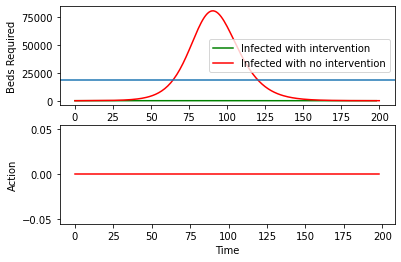

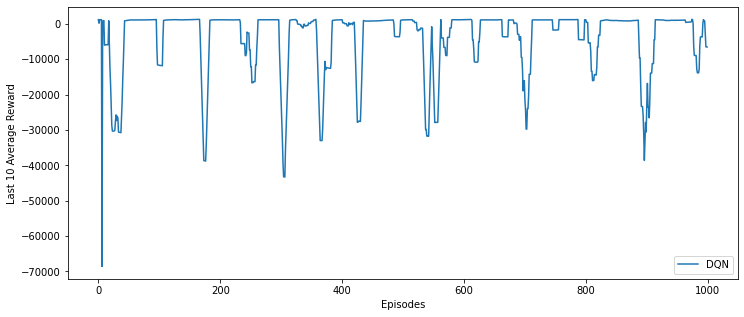

action dim== 4
plotting reward
DQN********************************************** 1
Reward =  1216.0
Total infected : 0.1208363238065025
Total cost 0
200
0.005933206572157514
200
0.005933206572157514


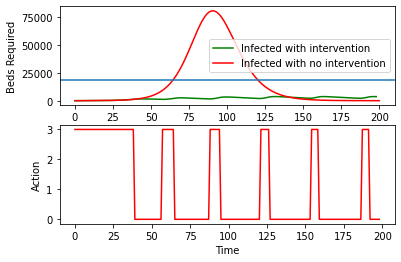

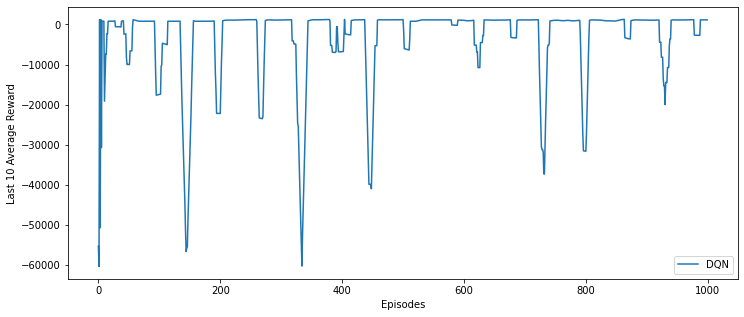

action dim== 4
plotting reward
DQN********************************************** 2
Reward =  1194.0
Total infected : 0.08916591767163475
Total cost 0
200
0.011483909838119246
200
0.011483909838119246


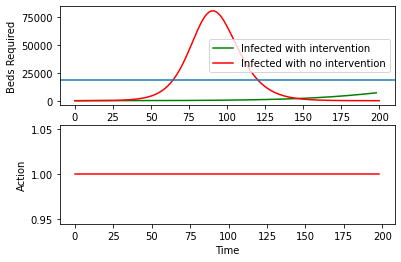

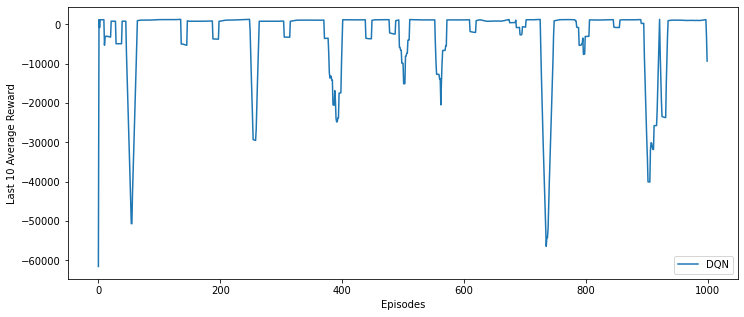

action dim== 4
plotting reward
DQN********************************************** 3
Reward =  1162.0
Total infected : 0.08686840395212815
Total cost 0
200
0.003784749798289034
200
0.003784749798289034


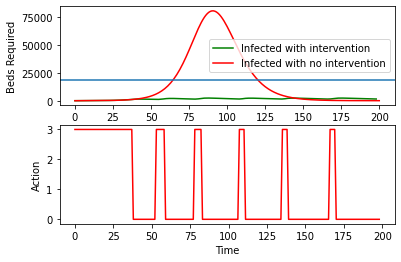

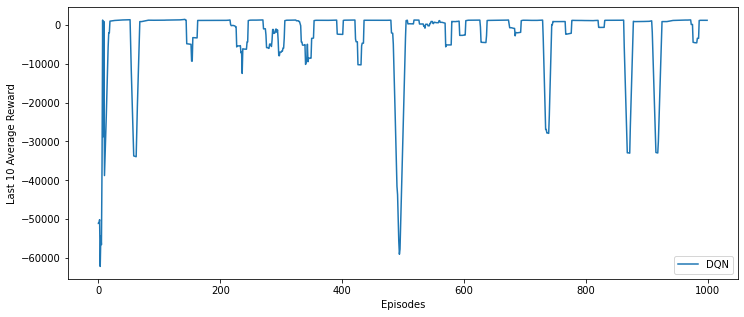

action dim== 4
plotting reward
DQN********************************************** 4
Reward =  1128.0
Total infected : 0.050671477677471224
Total cost 0
200
0.00232039904013469
200
0.00232039904013469


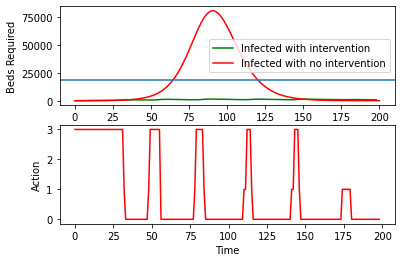

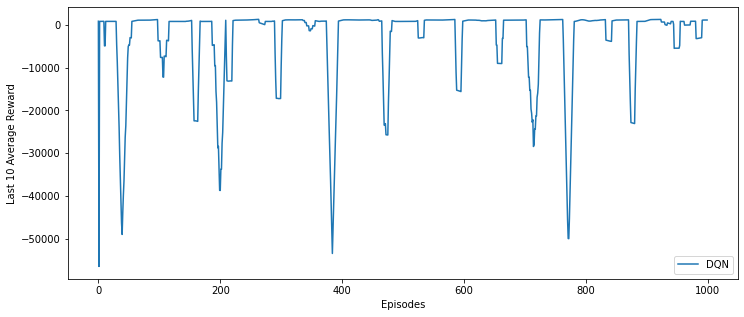

action dim== 4


KeyboardInterrupt: 

In [9]:
run_algos_plot_batch(30000,episodes=1000,number_of_times=10,name='capacity_1000')

action dim== 4
plotting reward
DQN********************************************** 0
Reward =  1498.0
Total infected : 0.6524519102974697
Total cost 0
200
0.030004791031149173
200
0.030004791031149173


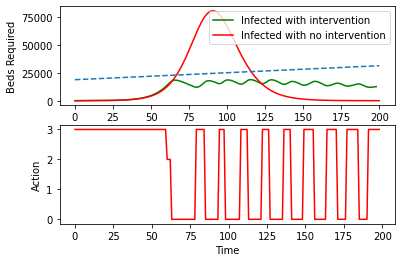

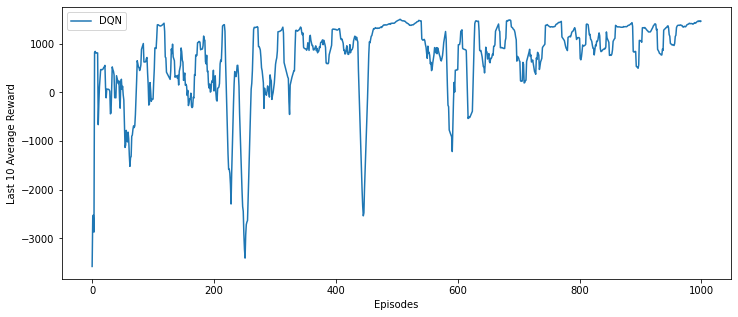

action dim== 4
plotting reward
DQN********************************************** 1
Reward =  1376.0
Total infected : 0.4193255699971165
Total cost 0
200
0.023351054023506006
200
0.023351054023506006


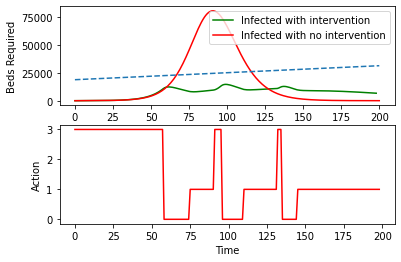

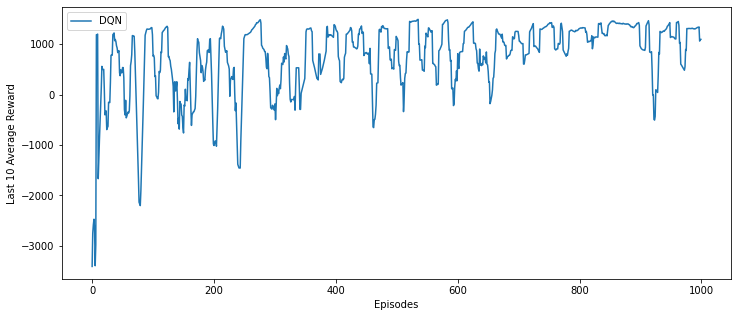

action dim== 4
plotting reward
DQN********************************************** 2
Reward =  1164.0
Total infected : 0.6302920129725235
Total cost 0
200
0.040438163601822515
200
0.040438163601822515


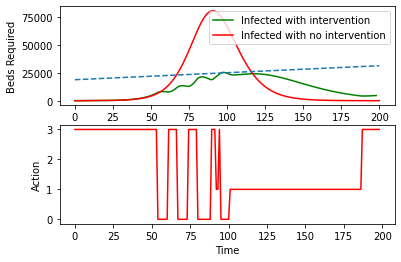

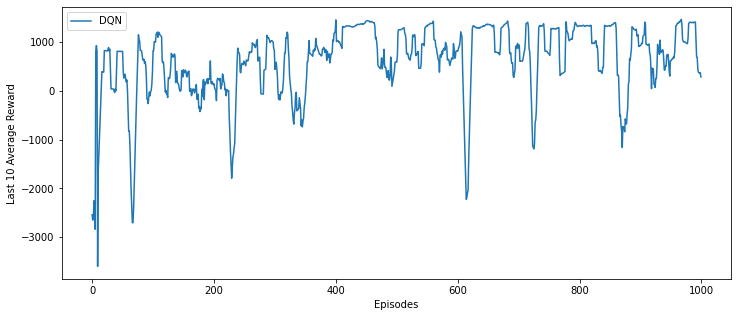

action dim== 4
plotting reward
DQN********************************************** 3
Reward =  1512.0
Total infected : 0.60995687156224
Total cost 0
200
0.028530476159852523
200
0.028530476159852523


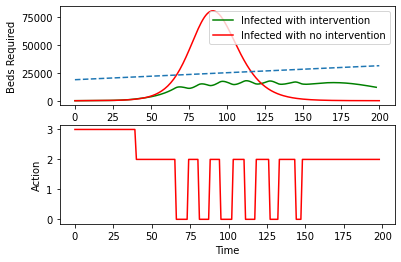

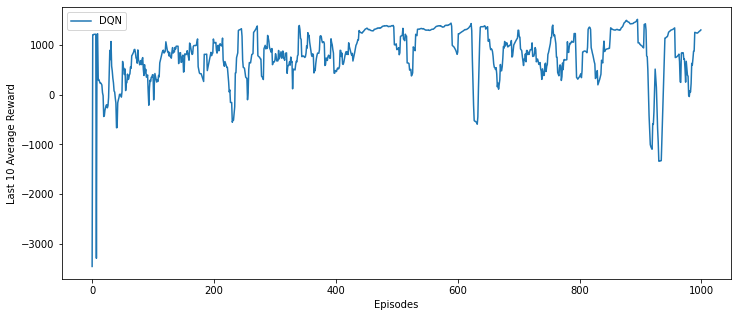

action dim== 4


In [ ]:
#Capacity based -100 inc in capacity
run_algos_plot_batch(30000,episodes=1000,number_of_times=10,name='capacity_100')

In [ ]:
#Capacity based inc in infection rate


## 1. Total number of infected people


action dim== 4
episode: 1, total reward: -432.0
episode: 2, total reward: -7474.0
episode: 3, total reward: -5830.0
episode: 4, total reward: 878.0
episode: 5, total reward: 834.0
episode: 6, total reward: 822.0
episode: 7, total reward: 824.0
episode: 8, total reward: 834.0
episode: 9, total reward: 830.0
episode: 10, total reward: 826.0
episode: 11, total reward: 842.0
episode: 12, total reward: 814.0
episode: 13, total reward: 828.0
episode: 14, total reward: 830.0
episode: 15, total reward: 826.0
episode: 16, total reward: 836.0
episode: 17, total reward: 834.0
episode: 18, total reward: 824.0
episode: 19, total reward: 830.0
episode: 20, total reward: 814.0
episode: 21, total reward: 806.0
episode: 22, total reward: 820.0
episode: 23, total reward: 828.0
episode: 24, total reward: 830.0
episode: 25, total reward: 818.0
episode: 26, total reward: 820.0
episode: 27, total reward: 832.0
episode: 28, total reward: 830.0
episode: 29, total reward: -5756.0
episode: 30, total reward: 820

episode: 244, total reward: -5816.0
episode: 245, total reward: -6248.0
episode: 246, total reward: -5652.0
episode: 247, total reward: -5714.0
episode: 248, total reward: -5556.0
episode: 249, total reward: 13544.0
episode: 250, total reward: -7294.0
episode: 251, total reward: -6208.0
episode: 252, total reward: 6804.0
episode: 253, total reward: 804.0
episode: 254, total reward: 816.0
episode: 255, total reward: 814.0
episode: 256, total reward: 810.0
episode: 257, total reward: 810.0
episode: 258, total reward: 818.0
episode: 259, total reward: 808.0
episode: 260, total reward: 818.0
episode: 261, total reward: 822.0
episode: 262, total reward: 810.0
episode: 263, total reward: 806.0
episode: 264, total reward: 804.0
episode: 265, total reward: 806.0
episode: 266, total reward: 816.0
episode: 267, total reward: 806.0
episode: 268, total reward: 802.0
episode: 269, total reward: 808.0
episode: 270, total reward: 824.0
episode: 271, total reward: 800.0
episode: 272, total reward: 814

episode: 484, total reward: 830.0
episode: 485, total reward: 800.0
episode: 486, total reward: 800.0
episode: 487, total reward: 818.0
episode: 488, total reward: -6988.0
episode: 489, total reward: 830.0
episode: 490, total reward: 826.0
episode: 491, total reward: 810.0
episode: 492, total reward: 814.0
episode: 493, total reward: 826.0
episode: 494, total reward: 804.0
episode: 495, total reward: 812.0
episode: 496, total reward: 806.0
episode: 497, total reward: 830.0
episode: 498, total reward: 824.0
episode: 499, total reward: -5364.0
episode: 500, total reward: 826.0
episode: 501, total reward: 812.0
episode: 502, total reward: 814.0
episode: 503, total reward: 800.0
episode: 504, total reward: 818.0
episode: 505, total reward: 800.0
episode: 506, total reward: 808.0
episode: 507, total reward: 804.0
episode: 508, total reward: 808.0
episode: 509, total reward: 808.0
episode: 510, total reward: 832.0
episode: 511, total reward: 800.0
episode: 512, total reward: 804.0
episode: 5

episode: 724, total reward: -5330.0
episode: 725, total reward: -7352.0
episode: 726, total reward: -7320.0
episode: 727, total reward: 810.0
episode: 728, total reward: 812.0
episode: 729, total reward: 812.0
episode: 730, total reward: 816.0
episode: 731, total reward: 824.0
episode: 732, total reward: 804.0
episode: 733, total reward: 806.0
episode: 734, total reward: 808.0
episode: 735, total reward: 804.0
episode: 736, total reward: 800.0
episode: 737, total reward: 812.0
episode: 738, total reward: 810.0
episode: 739, total reward: 818.0
episode: 740, total reward: 816.0
episode: 741, total reward: 812.0
episode: 742, total reward: 810.0
episode: 743, total reward: 806.0
episode: 744, total reward: 810.0
episode: 745, total reward: 812.0
episode: 746, total reward: -7196.0
episode: 747, total reward: 854.0
episode: 748, total reward: 806.0
episode: 749, total reward: 804.0
episode: 750, total reward: 802.0
episode: 751, total reward: 820.0
episode: 752, total reward: 804.0
episod

episode: 964, total reward: 816.0
episode: 965, total reward: 812.0
episode: 966, total reward: 816.0
episode: 967, total reward: 802.0
episode: 968, total reward: 826.0
episode: 969, total reward: 820.0
episode: 970, total reward: 816.0
episode: 971, total reward: 826.0
episode: 972, total reward: 810.0
episode: 973, total reward: 826.0
episode: 974, total reward: 800.0
episode: 975, total reward: 810.0
episode: 976, total reward: -6244.0
episode: 977, total reward: 854.0
episode: 978, total reward: 814.0
episode: 979, total reward: 816.0
episode: 980, total reward: 818.0
episode: 981, total reward: 824.0
episode: 982, total reward: 808.0
episode: 983, total reward: 816.0
episode: 984, total reward: 836.0
episode: 985, total reward: 812.0
episode: 986, total reward: 818.0
episode: 987, total reward: 800.0
episode: 988, total reward: 808.0
episode: 989, total reward: 816.0
episode: 990, total reward: 818.0
episode: 991, total reward: 814.0
episode: 992, total reward: -7318.0
episode: 9

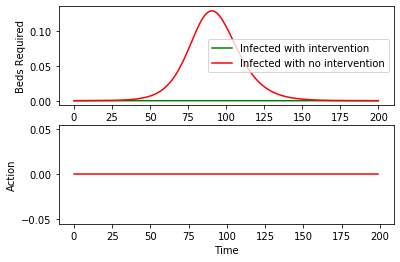

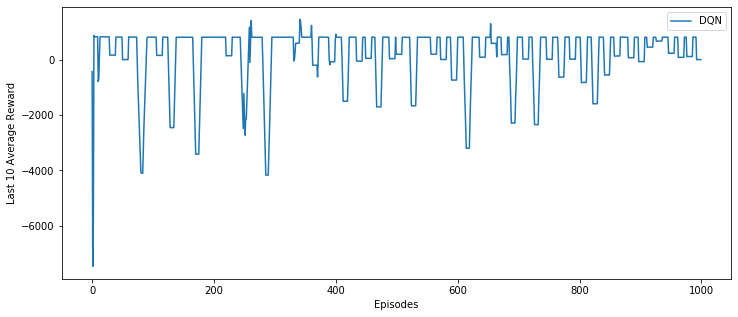

In [5]:
#DQN,PPO 
run_algos_plot(30000)

In [ ]:
#tota infected at any point


## 2. Economic budget 

action dim== 4
episode: 1, total reward: -13797937.23554736
episode: 2, total reward: -90591280.45097445
episode: 3, total reward: 2482.7501286524484
episode: 4, total reward: 2529.4090676388737
episode: 5, total reward: 2518.790164624799
episode: 6, total reward: 2523.201111258081
episode: 7, total reward: 2517.0378787962272
episode: 8, total reward: 2551.065821426833
episode: 9, total reward: 2515.197968191461
episode: 10, total reward: 2474.9504596500838
episode: 11, total reward: 2452.880720135689
episode: 12, total reward: 2488.639918683904
episode: 13, total reward: 2471.3330780068036
episode: 14, total reward: 2496.924089855989
episode: 15, total reward: 2556.6481030761433
episode: 16, total reward: 2461.0297204073363
episode: 17, total reward: 2469.114257157039
episode: 18, total reward: 2502.7546274706515
episode: 19, total reward: 2503.362126017881
episode: 20, total reward: 2491.245486721792
episode: 21, total reward: 2493.313262102859
episode: 22, total reward: 2521.2026547

episode: 179, total reward: -4999021.883880534
episode: 180, total reward: -17696997.81558483
episode: 181, total reward: -4999033.762870977
episode: 182, total reward: -4999031.82362541
episode: 183, total reward: -4899022.235590977
episode: 184, total reward: -4899026.0041018585
episode: 185, total reward: -4999033.77083762
episode: 186, total reward: -4899024.080354606
episode: 187, total reward: -4999033.771055214
episode: 188, total reward: -4999035.715835192
episode: 189, total reward: -4999031.7222323185
episode: 190, total reward: -55595874.105646625
episode: 191, total reward: -4999029.789649704
episode: 192, total reward: -4999026.929031159
episode: 193, total reward: -4899026.002220959
episode: 194, total reward: -4899024.088135039
episode: 195, total reward: -4999025.993149743
episode: 196, total reward: -4999039.625372498
episode: 197, total reward: -4899014.387418158
episode: 198, total reward: -4899024.976951082
episode: 199, total reward: -4999039.625372498
episode: 200

episode: 354, total reward: 2520.9008122690884
episode: 355, total reward: 2489.301861089859
episode: 356, total reward: 2542.6112622293053
episode: 357, total reward: 2512.65115478823
episode: 358, total reward: 2585.0503819857686
episode: 359, total reward: 2506.7864357114036
episode: 360, total reward: 2520.625273084555
episode: 361, total reward: 2515.356295381988
episode: 362, total reward: 2531.2732298391534
episode: 363, total reward: 2495.1595529640326
episode: 364, total reward: 2509.4215649471194
episode: 365, total reward: 2156.616097499492
episode: 366, total reward: -17897212.07282922
episode: 367, total reward: -35496880.98883279
episode: 368, total reward: -4999027.940190245
episode: 369, total reward: -4999024.0059016375
episode: 370, total reward: -4999037.658462639
episode: 371, total reward: -4999033.758185836
episode: 372, total reward: -4999018.285412027
episode: 373, total reward: -4899014.414787133
episode: 374, total reward: -4899020.2493430255
episode: 375, tot

episode: 529, total reward: -497525.48745285696
episode: 530, total reward: -697523.9047089656
episode: 531, total reward: -1197483.4523031714
episode: 532, total reward: -1397507.165746407
episode: 533, total reward: -62494855.958425045
episode: 534, total reward: -8197209.385753854
episode: 535, total reward: -5997325.32391753
episode: 536, total reward: -4497371.842946376
episode: 537, total reward: -3997411.582677866
episode: 538, total reward: -2897443.3269400722
episode: 539, total reward: -3297431.6326964577
episode: 540, total reward: -3597407.620292822
episode: 541, total reward: -2497467.4711824725
episode: 542, total reward: -3197417.173896729
episode: 543, total reward: -4898940.1315806825
episode: 544, total reward: -2897433.7909407173
episode: 545, total reward: -1797489.6945893941
episode: 546, total reward: -2097455.554936123
episode: 547, total reward: -1897473.9064431917
episode: 548, total reward: -34096100.20441813
episode: 549, total reward: -8097217.696860741
epis

episode: 704, total reward: -4999033.754696389
episode: 705, total reward: -4899018.263777461
episode: 706, total reward: -4899016.152678841
episode: 707, total reward: -15097117.711247178
episode: 708, total reward: -39496538.2035329
episode: 709, total reward: -4799018.281579984
episode: 710, total reward: -4899022.133141923
episode: 711, total reward: -4899024.040510586
episode: 712, total reward: -4999019.985982687
episode: 713, total reward: -5597397.575353283
episode: 714, total reward: -4799018.410782353
episode: 715, total reward: -4999027.839062003
episode: 716, total reward: -4999015.968283129
episode: 717, total reward: 3158.9113047700234
episode: 718, total reward: -7696191.22083715
episode: 719, total reward: -4899014.246374933
episode: 720, total reward: -39196608.060612395
episode: 721, total reward: -4999039.61407028
episode: 722, total reward: -4899029.876054634
episode: 723, total reward: -4999039.61407028
episode: 724, total reward: -4999025.981941187
episode: 725, t

episode: 879, total reward: -4899029.889318147
episode: 880, total reward: -4999033.747541162
episode: 881, total reward: -4999023.974853528
episode: 882, total reward: -48096314.38722041
episode: 883, total reward: -4899018.3489596825
episode: 884, total reward: -4999031.78613848
episode: 885, total reward: -4999031.794370261
episode: 886, total reward: -4999035.699855053
episode: 887, total reward: -4899010.511549623
episode: 888, total reward: -4899020.10355242
episode: 889, total reward: -6597443.6205525715
episode: 890, total reward: -4899014.292590494
episode: 891, total reward: 2826.6501464778703
episode: 892, total reward: -1096616.9929352568
episode: 893, total reward: -3897369.352956445
episode: 894, total reward: -5796268.866950877
episode: 895, total reward: -4898995.442236434
episode: 896, total reward: -63194904.467370026
episode: 897, total reward: -51195642.33337552
episode: 898, total reward: -63195016.45301592
episode: 899, total reward: -50295662.266253866
episode: 9

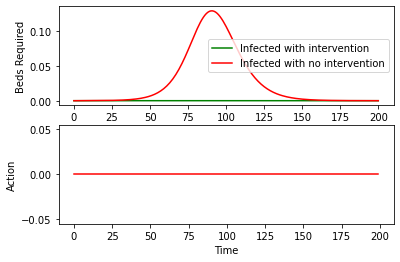

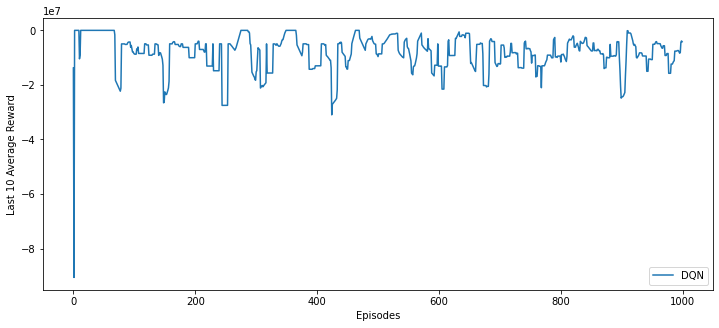

In [5]:
#DQN
# no limit on days..-new infection budget 1500 >budget, -10000
dqn_model = run_algos_plot(30000)

In [13]:
import pickle
filename = 'economic_no_limit_new_infection_budget_1500.sav'
pickle.dump(dqn_model, open(filename, 'wb'))
model = pickle.load(open(filename, 'rb'))

action dim== 4
episode: 1, total reward: -6549999.847187417
episode: 2, total reward: -479999.8419640321
episode: 3, total reward: -469999.8442443056
episode: 4, total reward: -489999.84026367345
episode: 5, total reward: -469999.8422906552
episode: 6, total reward: -489999.8411992582
episode: 7, total reward: -489999.8405346712
episode: 8, total reward: -469999.8436735351
episode: 9, total reward: 0.15160996498757429
episode: 10, total reward: 0.15296668602282137
episode: 11, total reward: -219999.8473401951
episode: 12, total reward: -439999.8472676198
episode: 13, total reward: -5019999.84826243
episode: 14, total reward: -479999.84112217807
episode: 15, total reward: -479999.8417427913
episode: 16, total reward: -479999.84154699347
episode: 17, total reward: -489999.84098275466
episode: 18, total reward: -10189999.848082028
episode: 19, total reward: -489999.84030204953
episode: 20, total reward: -499999.8400559891
episode: 21, total reward: -489999.84112967434
episode: 22, total r

episode: 176, total reward: -889999.847374052
episode: 177, total reward: -3029999.8473211597
episode: 178, total reward: -5789999.848347299
episode: 179, total reward: -809999.847813242
episode: 180, total reward: -789999.8476881287
episode: 181, total reward: -809999.8476043608
episode: 182, total reward: -809999.8476495899
episode: 183, total reward: -479999.84087797574
episode: 184, total reward: -839999.8475906877
episode: 185, total reward: 0.15312395369221243
episode: 186, total reward: 0.15330113890947256
episode: 187, total reward: 0.1528456386048007
episode: 188, total reward: 0.1530451386755062
episode: 189, total reward: 0.15271475796029202
episode: 190, total reward: 0.15326557367871207
episode: 191, total reward: 0.15295912882971746
episode: 192, total reward: 0.15321686508508886
episode: 193, total reward: 0.15226808296023503
episode: 194, total reward: 0.1527581472541834
episode: 195, total reward: 0.1533958465762245
episode: 196, total reward: 0.15307265952416393
episo

episode: 349, total reward: -5739999.848465198
episode: 350, total reward: -6069999.848456359
episode: 351, total reward: -489999.83986650937
episode: 352, total reward: -499999.840018837
episode: 353, total reward: -489999.83987725445
episode: 354, total reward: -489999.840087877
episode: 355, total reward: -489999.8402141871
episode: 356, total reward: -499999.83961602027
episode: 357, total reward: -489999.84047799744
episode: 358, total reward: -499999.83961602027
episode: 359, total reward: -489999.8400705485
episode: 360, total reward: -499999.83965889155
episode: 361, total reward: -489999.84015087626
episode: 362, total reward: -499999.839982447
episode: 363, total reward: -499999.83985693083
episode: 364, total reward: 0.15308680712702624
episode: 365, total reward: 0.15263717537053548
episode: 366, total reward: 0.15279982635205044
episode: 367, total reward: 0.15274144282074978
episode: 368, total reward: 0.1526372395381891
episode: 369, total reward: 0.15343685271434632
epi

episode: 522, total reward: -479999.84054598544
episode: 523, total reward: -499999.8397784657
episode: 524, total reward: -499999.83980057086
episode: 525, total reward: -489999.8404501722
episode: 526, total reward: -499999.839910301
episode: 527, total reward: -499999.8399499213
episode: 528, total reward: -499999.8398457086
episode: 529, total reward: 0.15339929835675534
episode: 530, total reward: 0.1526031560663575
episode: 531, total reward: 0.15327214412337087
episode: 532, total reward: 0.1529528880998287
episode: 533, total reward: 0.15345308615395162
episode: 534, total reward: 0.15339624453020556
episode: 535, total reward: 0.1529546305202597
episode: 536, total reward: 0.15272315532953804
episode: 537, total reward: 0.15269207128411297
episode: 538, total reward: 0.1532447901079841
episode: 539, total reward: 0.15285595862340648
episode: 540, total reward: -269999.8473719728
episode: 541, total reward: 0.15172636384700272
episode: 542, total reward: 0.15339741914380742
epi

episode: 695, total reward: -489999.84018865484
episode: 696, total reward: 0.1533549089626173
episode: 697, total reward: 0.15342868857052344
episode: 698, total reward: 0.15308064000979535
episode: 699, total reward: 0.1531145155830455
episode: 700, total reward: 0.153115892559633
episode: 701, total reward: 0.1525983491724591
episode: 702, total reward: 0.15283707137092514
episode: 703, total reward: 0.15258992215134182
episode: 704, total reward: 0.1532269085380773
episode: 705, total reward: 0.1532062409044481
episode: 706, total reward: 0.15333318056114292
episode: 707, total reward: 0.15332810104063224
episode: 708, total reward: 0.15336158596414437
episode: 709, total reward: 0.15271094232700913
episode: 710, total reward: 0.15346579330667875
episode: 711, total reward: 0.15327997029332932
episode: 712, total reward: 0.15314068425497954
episode: 713, total reward: -119999.84731833561
episode: 714, total reward: -709999.8467549057
episode: 715, total reward: -769999.8476874771
e

episode: 868, total reward: -499999.83992110397
episode: 869, total reward: -489999.840342874
episode: 870, total reward: -499999.84018464753
episode: 871, total reward: -489999.84025678807
episode: 872, total reward: -499999.83961602027
episode: 873, total reward: -499999.8399040576
episode: 874, total reward: -489999.8403804451
episode: 875, total reward: -489999.83994454663
episode: 876, total reward: -499999.8399954847
episode: 877, total reward: -499999.8397067858
episode: 878, total reward: -489999.8405277418
episode: 879, total reward: -489999.8405842258
episode: 880, total reward: -489999.8404542081
episode: 881, total reward: -25119999.848467767
episode: 882, total reward: 0.15266275130901863
episode: 883, total reward: 0.15336358965267174
episode: 884, total reward: 0.15301325084295775
episode: 885, total reward: 0.15345007389035506
episode: 886, total reward: 0.1531694808433529
episode: 887, total reward: 0.15265872286506585
episode: 888, total reward: 0.1528129597941271
epi

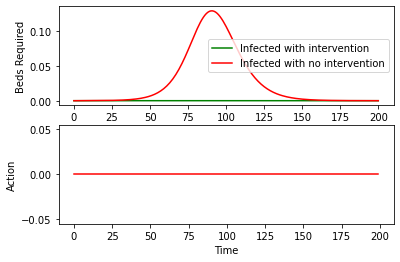

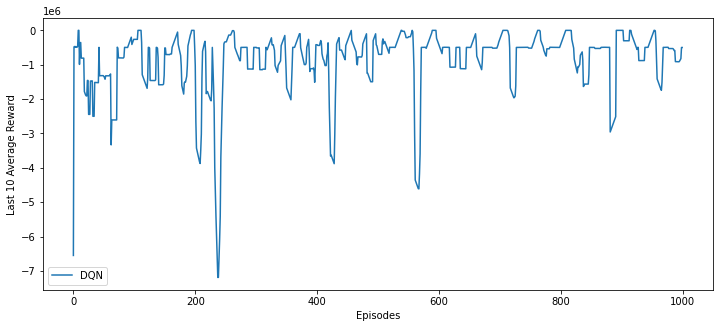

In [6]:
#DQN run again
# no limit on days..-0.001*new infection budget 1500 >budget, -10000
dqn_model = run_algos_plot(30000)


In [8]:
import pickle
filename = 'economic_no_limit_001new_infection_budget_1500.sav'
pickle.dump(dqn_model, open(filename, 'wb'))

action dim== 4
episode: 1, total reward: -70616.25415371233
episode: 2, total reward: -1973352.4134874113
episode: 3, total reward: -490021.1736332857
episode: 4, total reward: -480021.34713144036
episode: 5, total reward: -480019.95818785974
episode: 6, total reward: -490018.5562072614
episode: 7, total reward: -480019.21979913744
episode: 8, total reward: -480018.48824336566
episode: 9, total reward: -66644.05153673487
episode: 10, total reward: -66962.10629575718
episode: 11, total reward: -67784.70883484567
episode: 12, total reward: -68236.43295731442
episode: 13, total reward: -68386.51186215522
episode: 14, total reward: -67132.76296731998
episode: 15, total reward: -68000.54061627126
episode: 16, total reward: -66268.20564955725
episode: 17, total reward: -2238215.037682167
episode: 18, total reward: -490018.7564986201
episode: 19, total reward: -480022.15120523924
episode: 20, total reward: -480022.388097798
episode: 21, total reward: -480022.29087478673
episode: 22, total rew

episode: 177, total reward: -490020.10063042986
episode: 178, total reward: -490017.34685465635
episode: 179, total reward: -3296885.940677808
episode: 180, total reward: -867427.6818483169
episode: 181, total reward: -887088.0057536077
episode: 182, total reward: -897062.2290763328
episode: 183, total reward: -906813.9594766838
episode: 184, total reward: -2826270.7485965486
episode: 185, total reward: -5873490.900116902
episode: 186, total reward: -5811648.313135797
episode: 187, total reward: -5647693.4677844085
episode: 188, total reward: -480020.2266388065
episode: 189, total reward: -490017.296941951
episode: 190, total reward: -500016.74071351864
episode: 191, total reward: -500016.69103777694
episode: 192, total reward: -500016.4895987112
episode: 193, total reward: -490017.7860398912
episode: 194, total reward: -500017.29447630147
episode: 195, total reward: -500016.5639145136
episode: 196, total reward: -500016.50939474616
episode: 197, total reward: -490016.8859740234
episod

episode: 352, total reward: -66211.41689363868
episode: 353, total reward: -66020.84471280953
episode: 354, total reward: -65891.54159965127
episode: 355, total reward: -66028.64772673164
episode: 356, total reward: -66283.25318819718
episode: 357, total reward: -64461.47629883383
episode: 358, total reward: -957106.3230904771
episode: 359, total reward: -6247216.940391695
episode: 360, total reward: -9694648.036120566
episode: 361, total reward: -8746994.682763802
episode: 362, total reward: -16904073.275572233
episode: 363, total reward: -65588.28954969997
episode: 364, total reward: -66012.29938279215
episode: 365, total reward: -66231.04830564748
episode: 366, total reward: -64748.47069356542
episode: 367, total reward: -182723.90161959545
episode: 368, total reward: -66203.45728730364
episode: 369, total reward: -66265.79456167086
episode: 370, total reward: -66170.40779048172
episode: 371, total reward: -372897.92334800056
episode: 372, total reward: -66032.69209423602
episode: 3

episode: 526, total reward: -817752.7423786883
episode: 527, total reward: -847350.8893030682
episode: 528, total reward: -857590.3234193667
episode: 529, total reward: -907427.732492963
episode: 530, total reward: -917269.4118687699
episode: 531, total reward: -907242.732588301
episode: 532, total reward: -867384.721036833
episode: 533, total reward: -857381.2731036734
episode: 534, total reward: -66135.18521203933
episode: 535, total reward: -66210.7762663559
episode: 536, total reward: -66036.75979590851
episode: 537, total reward: -66200.33709476136
episode: 538, total reward: -65609.44181028822
episode: 539, total reward: -65762.85041508614
episode: 540, total reward: -65798.40129102462
episode: 541, total reward: -65698.98117941784
episode: 542, total reward: -66015.20304064469
episode: 543, total reward: -66206.75419757917
episode: 544, total reward: -63550.18214526197
episode: 545, total reward: -2660795.006614116
episode: 546, total reward: -887394.9127088832
episode: 547, tot

episode: 701, total reward: -65836.65054841449
episode: 702, total reward: -65678.8148429805
episode: 703, total reward: -65828.45919982018
episode: 704, total reward: -66175.52510878183
episode: 705, total reward: -65830.97116963999
episode: 706, total reward: -66030.96080335061
episode: 707, total reward: -64337.08766946533
episode: 708, total reward: -697419.7217861244
episode: 709, total reward: -500018.5739218619
episode: 710, total reward: -500016.5502268748
episode: 711, total reward: -500017.12115144805
episode: 712, total reward: -500016.88781292347
episode: 713, total reward: -65872.76392886153
episode: 714, total reward: -66064.44889467396
episode: 715, total reward: -66054.26498771728
episode: 716, total reward: -66225.183173032
episode: 717, total reward: -66277.34002822953
episode: 718, total reward: -66045.148980345
episode: 719, total reward: -64417.70454809752
episode: 720, total reward: -3672271.6375240097
episode: 721, total reward: -6374576.76840682
episode: 722, to

episode: 875, total reward: -3657645.6233678656
episode: 876, total reward: -500016.5265229359
episode: 877, total reward: -490018.2113160577
episode: 878, total reward: -490016.74733729014
episode: 879, total reward: -500016.48216795013
episode: 880, total reward: -500017.06786729954
episode: 881, total reward: -500016.48216795013
episode: 882, total reward: -490016.6302512325
episode: 883, total reward: -500016.63829758886
episode: 884, total reward: -490016.97153274657
episode: 885, total reward: -500017.05041043996
episode: 886, total reward: -480019.14787818305
episode: 887, total reward: -500018.40873492
episode: 888, total reward: -787445.8955352972
episode: 889, total reward: -480021.282920343
episode: 890, total reward: -500016.48216795013
episode: 891, total reward: -490018.5782741272
episode: 892, total reward: -500017.14943956723
episode: 893, total reward: -490017.8862171408
episode: 894, total reward: -490016.792113535
episode: 895, total reward: -490019.39459615765
episo

episode: 1048, total reward: -500019.2919407039
episode: 1049, total reward: -500016.55518347
episode: 1050, total reward: -490018.15021081426
episode: 1051, total reward: -500017.48913947673
episode: 1052, total reward: -490017.6206638263
episode: 1053, total reward: -65993.53029589144
episode: 1054, total reward: -66123.99140614702
episode: 1055, total reward: -60127.57838411425
episode: 1056, total reward: -67448.70364351038
episode: 1057, total reward: -306388.9705050664
episode: 1058, total reward: -1360872.9106214743
episode: 1059, total reward: -907300.2205510038
episode: 1060, total reward: -867580.3262481972
episode: 1061, total reward: -827350.3228128671
episode: 1062, total reward: -1055437.053127102
episode: 1063, total reward: -4634876.656652447
episode: 1064, total reward: -887178.8536539292
episode: 1065, total reward: -847493.2847655306
episode: 1066, total reward: -1582051.3115624194
episode: 1067, total reward: -857355.824703394
episode: 1068, total reward: -2059199.4

episode: 1218, total reward: -500016.48216795013
episode: 1219, total reward: -490016.55967127206
episode: 1220, total reward: -500016.5221579623
episode: 1221, total reward: -500016.5104108543
episode: 1222, total reward: -480020.30649641115
episode: 1223, total reward: -500016.5581401206
episode: 1224, total reward: -490017.4890716294
episode: 1225, total reward: -500016.85119288514
episode: 1226, total reward: -500016.48216795013
episode: 1227, total reward: -490017.75866871985
episode: 1228, total reward: -500016.48766277847
episode: 1229, total reward: -500016.6573905746
episode: 1230, total reward: -500016.4846765065
episode: 1231, total reward: -490016.7981763327
episode: 1232, total reward: -490019.0604348387
episode: 1233, total reward: -490016.6327229333
episode: 1234, total reward: -490017.8449244942
episode: 1235, total reward: -500016.50851483596
episode: 1236, total reward: -490019.3517235918
episode: 1237, total reward: -766989.5205522213
episode: 1238, total reward: -50

episode: 1388, total reward: -6973684.764554357
episode: 1389, total reward: -500016.4991319456
episode: 1390, total reward: -500016.48365759
episode: 1391, total reward: -490018.99593482894
episode: 1392, total reward: -500016.5289228402
episode: 1393, total reward: -500017.0049641053
episode: 1394, total reward: -500016.91057384346
episode: 1395, total reward: -500016.4842411412
episode: 1396, total reward: -710020.4535402647
episode: 1397, total reward: -500017.11550792726
episode: 1398, total reward: -500017.5249002585
episode: 1399, total reward: -11457825.47708972
episode: 1400, total reward: -490019.5840788753
episode: 1401, total reward: -500016.61297345883
episode: 1402, total reward: -6323636.53020928
episode: 1403, total reward: -500017.3748393576
episode: 1404, total reward: -500016.5560892649
episode: 1405, total reward: -780020.1932404455
episode: 1406, total reward: -490020.15612666536
episode: 1407, total reward: -1390030.0494007827
episode: 1408, total reward: -500016.

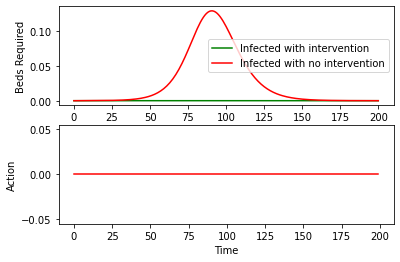

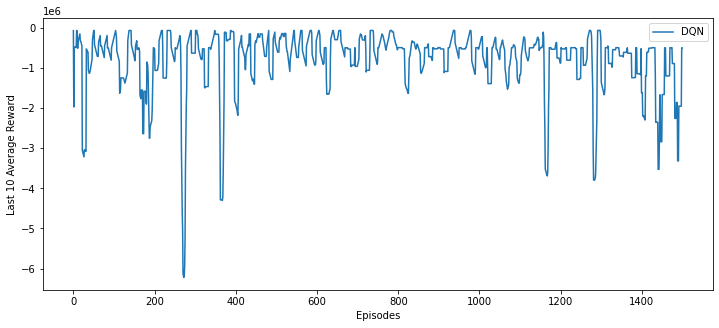

In [6]:
#DQN
# no limit on days..-0.001*active infection budget 1500 >budget, -10000
dqn_model = run_algos_plot(30000,episodes=1500)

In [ ]:
#DQN
#  limit on days..-0.001*active infection budget 1500 >budget, -10000
dqn_model = run_algos_plot(30000,episodes=1500)

In [ ]:
import pickle
filename = 'economic_no_limit_001active_infection_budget_1500.sav'
pickle.dump(dqn_model, open(filename, 'wb'))

action dim== 4
episode: 1, total reward: -69946.35448215253
episode: 2, total reward: -65055.22188833083
episode: 3, total reward: -64770.23427902778
episode: 4, total reward: -165621.00971602183
episode: 5, total reward: -510030.79598710296
episode: 6, total reward: -530020.0645207855
episode: 7, total reward: -67934.25683766777
episode: 8, total reward: -67930.51529292577
episode: 9, total reward: -69979.11748143507
episode: 10, total reward: -68824.90723921059
episode: 11, total reward: -67907.82934973523
episode: 12, total reward: -68403.40556205667
episode: 13, total reward: -67029.70932931239
episode: 14, total reward: -67090.66554478781
episode: 15, total reward: -68543.41662538289
episode: 16, total reward: -68598.61721092986
episode: 17, total reward: -68209.81680218586
episode: 18, total reward: -67809.32685511737
episode: 19, total reward: -66830.07888753724
episode: 20, total reward: -61113.97828779625
episode: 21, total reward: -60753.47145645915
episode: 22, total reward:

episode: 178, total reward: -1385389.8792762696
episode: 179, total reward: -2280017.2346098823
episode: 180, total reward: -2290017.9238560945
episode: 181, total reward: -2290017.614239373
episode: 182, total reward: -2300018.075532719
episode: 183, total reward: -2320017.652025173
episode: 184, total reward: -2330017.622644016
episode: 185, total reward: -2340020.93517003
episode: 186, total reward: -2340020.7997260676
episode: 187, total reward: -2360017.4738239385
episode: 188, total reward: -2034234.209399697
episode: 189, total reward: -2370018.8459317693
episode: 190, total reward: -2380021.013698185
episode: 191, total reward: -2400017.238363419
episode: 192, total reward: -2065851.7493804926
episode: 193, total reward: -2410018.1584063936
episode: 194, total reward: -2094996.2582376131
episode: 195, total reward: -2096339.006695605
episode: 196, total reward: -2113472.889418771
episode: 197, total reward: -2135105.0709095406
episode: 198, total reward: -2470017.601363962
epis

episode: 351, total reward: -3058440.1683110446
episode: 352, total reward: -1876524.4795948637
episode: 353, total reward: -1926798.9543102342
episode: 354, total reward: -1886813.3487842684
episode: 355, total reward: -1906485.084667851
episode: 356, total reward: -3730595.7491193744
episode: 357, total reward: -1936862.2765294425
episode: 358, total reward: -3147375.692672899
episode: 359, total reward: -3138621.8329896107
episode: 360, total reward: -4090053.7575994455
episode: 361, total reward: -3168168.2705849106
episode: 362, total reward: -4100040.383452076
episode: 363, total reward: -3207552.030001604
episode: 364, total reward: -2084571.0892514747
episode: 365, total reward: -3207915.934025592
episode: 366, total reward: -3217878.2418199
episode: 367, total reward: -3151769.159657666
episode: 368, total reward: -2234545.991542757
episode: 369, total reward: -4235990.111050406
episode: 370, total reward: -4190017.3537123026
episode: 371, total reward: -4200018.755926583
epis

episode: 525, total reward: -4882577.996770438
episode: 526, total reward: -4892767.659190507
episode: 527, total reward: -4791753.933782175
episode: 528, total reward: -4782132.659943918
episode: 529, total reward: -4753089.197763873
episode: 530, total reward: -4762977.940918964
episode: 531, total reward: -3881286.016623747
episode: 532, total reward: -4915912.985304911
episode: 533, total reward: -3890998.3248314466
episode: 534, total reward: -5879641.068907426
episode: 535, total reward: -5504061.963962465
episode: 536, total reward: -5506331.691806772
episode: 537, total reward: -5516566.569344204
episode: 538, total reward: -5544130.4332004255
episode: 539, total reward: -5542651.95607056
episode: 540, total reward: -5546586.107686088
episode: 541, total reward: -5559212.708709469
episode: 542, total reward: -3776656.3072585836
episode: 543, total reward: -5584797.707783964
episode: 544, total reward: -3756138.3348541
episode: 545, total reward: -5599614.447656123
episode: 546,

episode: 700, total reward: -5415228.011317617
episode: 701, total reward: -5365213.325379355
episode: 702, total reward: -5395420.593079938
episode: 703, total reward: -5425102.690809529
episode: 704, total reward: -5445035.961978691
episode: 705, total reward: -6522761.485018821
episode: 706, total reward: -7620984.092066393
episode: 707, total reward: -5466565.344997339
episode: 708, total reward: -6637769.999397933
episode: 709, total reward: -5524524.507193965
episode: 710, total reward: -6667585.711088465
episode: 711, total reward: -6745239.157282093
episode: 712, total reward: -5652225.937513538
episode: 713, total reward: -5632305.316385187
episode: 714, total reward: -5710833.043095154
episode: 715, total reward: -5730611.227967894
episode: 716, total reward: -5682144.3145657405
episode: 717, total reward: -5685535.04606042
episode: 718, total reward: -7360660.0571070295
episode: 719, total reward: -7363031.323784202
episode: 720, total reward: -5556369.414033191
episode: 721

episode: 875, total reward: -8297855.95672235
episode: 876, total reward: -8940063.261754388
episode: 877, total reward: -9319414.377867142
episode: 878, total reward: -8347071.21027871
episode: 879, total reward: -9280332.474489693
episode: 880, total reward: -8357582.2415787
episode: 881, total reward: -8358039.831931905
episode: 882, total reward: -9365187.344301261
episode: 883, total reward: -8387573.530636892
episode: 884, total reward: -7500785.4281997355
episode: 885, total reward: -8416674.670769664
episode: 886, total reward: -9406083.99797694
episode: 887, total reward: -7236117.702411648
episode: 888, total reward: -8274978.145157508
episode: 889, total reward: -8601711.007458834
episode: 890, total reward: -7275657.354114044
episode: 891, total reward: -8561346.356328383
episode: 892, total reward: -8833954.511309098
episode: 893, total reward: -8657755.81404943
episode: 894, total reward: -8619480.1531047
episode: 895, total reward: -9091298.765557649
episode: 896, total 

episode: 1049, total reward: -10057234.434446432
episode: 1050, total reward: -10057835.15364105
episode: 1051, total reward: -10104740.440187683
episode: 1052, total reward: -10124531.512667831
episode: 1053, total reward: -10112754.682895038
episode: 1054, total reward: -10097521.73389035
episode: 1055, total reward: -10144591.925155284
episode: 1056, total reward: -10164169.874153545
episode: 1057, total reward: -10680508.8104828
episode: 1058, total reward: -10752250.929726448
episode: 1059, total reward: -10186044.132759942
episode: 1060, total reward: -10772393.106049368
episode: 1061, total reward: -10168313.460879551
episode: 1062, total reward: -10187441.35310255
episode: 1063, total reward: -10187528.901421163
episode: 1064, total reward: -9260733.876980085
episode: 1065, total reward: -9104878.314604085
episode: 1066, total reward: -9016076.74578678
episode: 1067, total reward: -9243892.445397368
episode: 1068, total reward: -10860287.364129627
episode: 1069, total reward: -

episode: 1218, total reward: -10576186.906705867
episode: 1219, total reward: -10616530.477558512
episode: 1220, total reward: -12364317.14634977
episode: 1221, total reward: -12388145.151878107
episode: 1222, total reward: -12401766.548600728
episode: 1223, total reward: -12404062.141310848
episode: 1224, total reward: -10616284.46315565
episode: 1225, total reward: -12423883.276895873
episode: 1226, total reward: -10576288.659959042
episode: 1227, total reward: -10696044.588129668
episode: 1228, total reward: -10616138.33486586
episode: 1229, total reward: -10636281.975017263
episode: 1230, total reward: -12858611.971861782
episode: 1231, total reward: -10744715.755322017
episode: 1232, total reward: -12125409.392258864
episode: 1233, total reward: -12408664.842522299
episode: 1234, total reward: -11907328.248377156
episode: 1235, total reward: -11937212.044229532
episode: 1236, total reward: -12642216.068168059
episode: 1237, total reward: -12544828.744163707
episode: 1238, total re

episode: 1386, total reward: -14411867.509499695
episode: 1387, total reward: -13427716.089894
episode: 1388, total reward: -14331523.62632066
episode: 1389, total reward: -14061662.609328955
episode: 1390, total reward: -14453709.03624478
episode: 1391, total reward: -14457128.743766483
episode: 1392, total reward: -14087547.469874863
episode: 1393, total reward: -14091906.497388858
episode: 1394, total reward: -14123327.165517632
episode: 1395, total reward: -14123196.313454587
episode: 1396, total reward: -13517515.532780623
episode: 1397, total reward: -13537943.907453157
episode: 1398, total reward: -12462998.931531053
episode: 1399, total reward: -12531669.106689239
episode: 1400, total reward: -14557911.9562688
episode: 1401, total reward: -14181963.04816464
episode: 1402, total reward: -13358908.621215591
episode: 1403, total reward: -13408547.887442641
episode: 1404, total reward: -14595952.714659365
episode: 1405, total reward: -12652459.89292443
episode: 1406, total reward: 

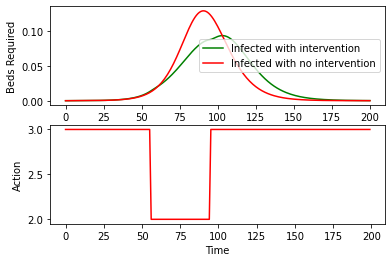

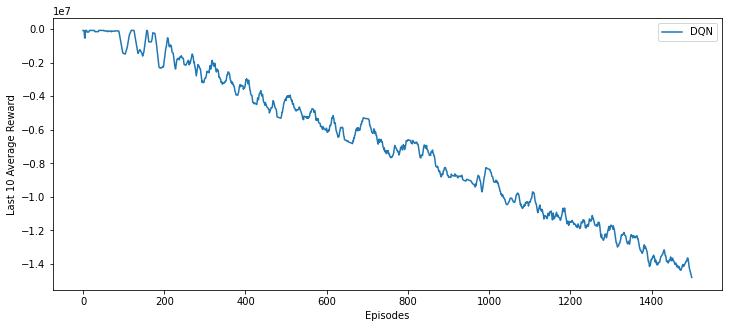

In [6]:
#DQN
#  limit on days.. budget 1500 >budget, -10000
dqn_model = run_algos_plot(30000,episodes=1500)

action dim== 4
episode: 1, total reward: -400884.0
episode: 2, total reward: -1728598.0
episode: 3, total reward: -1849508.0
episode: 4, total reward: -1887438.0
episode: 5, total reward: -1846398.0
episode: 6, total reward: -394432.0
episode: 7, total reward: -404406.0
episode: 8, total reward: -402444.0
episode: 9, total reward: -1787714.0
episode: 10, total reward: -381452.0
episode: 11, total reward: -388404.0
episode: 12, total reward: -374476.0
episode: 13, total reward: -390454.0
episode: 14, total reward: -2367570.0
episode: 15, total reward: -229644.0
episode: 16, total reward: -228682.0
episode: 17, total reward: -683806.0
episode: 18, total reward: -237184.0
episode: 19, total reward: -1593122.0
episode: 20, total reward: -228658.0
episode: 21, total reward: -228666.0
episode: 22, total reward: -233628.0
episode: 23, total reward: -224782.0
episode: 24, total reward: -1935544.0
episode: 25, total reward: -230706.0
episode: 26, total reward: -227654.0
episode: 27, total rewar

episode: 219, total reward: -237190.0
episode: 220, total reward: -237200.0
episode: 221, total reward: -237194.0
episode: 222, total reward: -237190.0
episode: 223, total reward: -236170.0
episode: 224, total reward: -237182.0
episode: 225, total reward: -236164.0
episode: 226, total reward: -227650.0
episode: 227, total reward: -228646.0
episode: 228, total reward: -227666.0
episode: 229, total reward: -229668.0
episode: 230, total reward: -228674.0
episode: 231, total reward: -227712.0
episode: 232, total reward: -227678.0
episode: 233, total reward: -228676.0
episode: 234, total reward: -5045020.0
episode: 235, total reward: -237194.0
episode: 236, total reward: -237176.0
episode: 237, total reward: -237176.0
episode: 238, total reward: -370602.0
episode: 239, total reward: -237190.0
episode: 240, total reward: -235152.0
episode: 241, total reward: -237200.0
episode: 242, total reward: -230118.0
episode: 243, total reward: -238158.0
episode: 244, total reward: -237194.0
episode: 24

episode: 435, total reward: -596900.0
episode: 436, total reward: -232616.0
episode: 437, total reward: -234592.0
episode: 438, total reward: -228636.0
episode: 439, total reward: -227642.0
episode: 440, total reward: -228636.0
episode: 441, total reward: -233804.0
episode: 442, total reward: -225732.0
episode: 443, total reward: -227654.0
episode: 444, total reward: -227666.0
episode: 445, total reward: -618758.0
episode: 446, total reward: -227646.0
episode: 447, total reward: -228640.0
episode: 448, total reward: -228634.0
episode: 449, total reward: -227648.0
episode: 450, total reward: -227644.0
episode: 451, total reward: -229624.0
episode: 452, total reward: -227644.0
episode: 453, total reward: -225764.0
episode: 454, total reward: -227654.0
episode: 455, total reward: -3269574.0
episode: 456, total reward: -237190.0
episode: 457, total reward: -236162.0
episode: 458, total reward: -235136.0
episode: 459, total reward: -227646.0
episode: 460, total reward: -232608.0
episode: 46

episode: 651, total reward: -229644.0
episode: 652, total reward: -227658.0
episode: 653, total reward: -323834.0
episode: 654, total reward: -414670.0
episode: 655, total reward: -237192.0
episode: 656, total reward: -237182.0
episode: 657, total reward: -237198.0
episode: 658, total reward: -237188.0
episode: 659, total reward: -236174.0
episode: 660, total reward: -237138.0
episode: 661, total reward: -368624.0
episode: 662, total reward: -232606.0
episode: 663, total reward: -232598.0
episode: 664, total reward: -228644.0
episode: 665, total reward: -222926.0
episode: 666, total reward: -227666.0
episode: 667, total reward: -227654.0
episode: 668, total reward: -407180.0
episode: 669, total reward: -229640.0
episode: 670, total reward: -229666.0
episode: 671, total reward: -227816.0
episode: 672, total reward: -227648.0
episode: 673, total reward: -833190.0
episode: 674, total reward: -229636.0
episode: 675, total reward: -227656.0
episode: 676, total reward: -228658.0
episode: 677

episode: 867, total reward: -397402.0
episode: 868, total reward: -231616.0
episode: 869, total reward: -226704.0
episode: 870, total reward: -227696.0
episode: 871, total reward: -798500.0
episode: 872, total reward: -402354.0
episode: 873, total reward: -411336.0
episode: 874, total reward: -229630.0
episode: 875, total reward: -228630
episode: 876, total reward: -227654.0
episode: 877, total reward: -227648.0
episode: 878, total reward: -546960.0
episode: 879, total reward: -409388.0
episode: 880, total reward: -842358.0
episode: 881, total reward: -230626.0
episode: 882, total reward: -229632.0
episode: 883, total reward: -228640.0
episode: 884, total reward: -228670.0
episode: 885, total reward: -226686.0
episode: 886, total reward: -228668.0
episode: 887, total reward: -226672.0
episode: 888, total reward: -234654.0
episode: 889, total reward: -694452.0
episode: 890, total reward: -228640.0
episode: 891, total reward: -228640.0
episode: 892, total reward: -223934.0
episode: 893, 

episode: 1081, total reward: -230654.0
episode: 1082, total reward: -252538.0
episode: 1083, total reward: -226706.0
episode: 1084, total reward: -313892.0
episode: 1085, total reward: -816026.0
episode: 1086, total reward: -228648.0
episode: 1087, total reward: -228638.0
episode: 1088, total reward: -263340.0
episode: 1089, total reward: -226702.0
episode: 1090, total reward: -471168.0
episode: 1091, total reward: -225754.0
episode: 1092, total reward: -227664.0
episode: 1093, total reward: -227654.0
episode: 1094, total reward: -229644.0
episode: 1095, total reward: -228660.0
episode: 1096, total reward: -224968.0
episode: 1097, total reward: -226854.0
episode: 1098, total reward: -230624.0
episode: 1099, total reward: -228648.0
episode: 1100, total reward: -242522.0
episode: 1101, total reward: -400916.0
episode: 1102, total reward: -225698.0
episode: 1103, total reward: -229652.0
episode: 1104, total reward: -227682.0
episode: 1105, total reward: -227652.0
episode: 1106, total rewa

episode: 1292, total reward: -237184.0
episode: 1293, total reward: -237194.0
episode: 1294, total reward: -235164.0
episode: 1295, total reward: -233640.0
episode: 1296, total reward: -320874.0
episode: 1297, total reward: -227660.0
episode: 1298, total reward: -226686.0
episode: 1299, total reward: -522948.0
episode: 1300, total reward: -394390.0
episode: 1301, total reward: -404336.0
episode: 1302, total reward: -411332.0
episode: 1303, total reward: -237182.0
episode: 1304, total reward: -236174.0
episode: 1305, total reward: -7373232.0
episode: 1306, total reward: -406318.0
episode: 1307, total reward: -398366.0
episode: 1308, total reward: -403364.0
episode: 1309, total reward: -403374.0
episode: 1310, total reward: -397392.0
episode: 1311, total reward: -383410.0
episode: 1312, total reward: -396380.0
episode: 1313, total reward: -400350.0
episode: 1314, total reward: -403358.0
episode: 1315, total reward: -400354.0
episode: 1316, total reward: -393400.0
episode: 1317, total rew

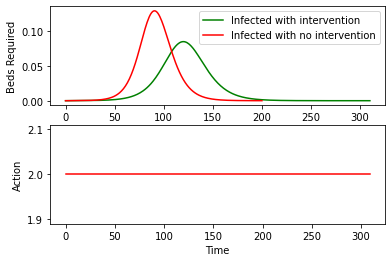

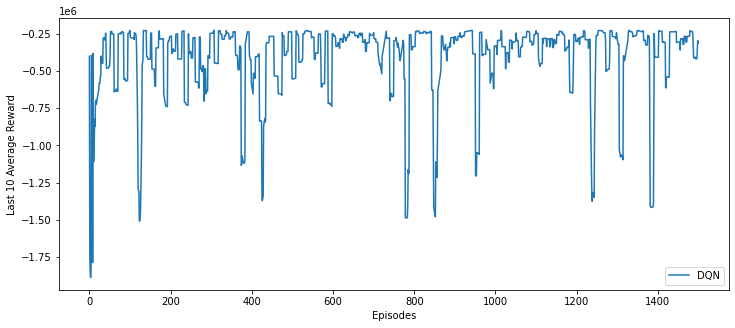

In [6]:
# no limit on days.. budget 1500 >budget, no  -ve for inf. rew based on economy and -ve when inf >x
dqn_model = run_algos_plot(30000,episodes=1500)

In [ ]:
#Econoomic budget 2nd try

action dim== 4
episode: 1, total reward: -9796.0
episode: 2, total reward: 200.0
episode: 3, total reward: 212.0
episode: 4, total reward: 208.0
episode: 5, total reward: -6798.0
episode: 6, total reward: -160.0
episode: 7, total reward: -188.0
episode: 8, total reward: -176.0
episode: 9, total reward: -186.0
episode: 10, total reward: -186.0
episode: 11, total reward: -160.0
Reward -60506.0
episode: 12, total reward: -60506.0
episode: 13, total reward: 196.0
Reward -35754.0
episode: 14, total reward: -36754.0
Reward -53216.0
episode: 15, total reward: -53216.0
Reward -54454.0
episode: 16, total reward: -54454.0
Reward -59504.0
episode: 17, total reward: -59504.0
episode: 18, total reward: -4798.0
episode: 19, total reward: 198.0
episode: 20, total reward: -30798.0
episode: 21, total reward: -134.0
episode: 22, total reward: -188.0
episode: 23, total reward: -196.0
episode: 24, total reward: -168.0
episode: 25, total reward: -176.0
episode: 26, total reward: -190.0
episode: 27, total r

episode: 232, total reward: -200.0
episode: 233, total reward: -204.0
episode: 234, total reward: -198.0
episode: 235, total reward: -164.0
episode: 236, total reward: -198.0
episode: 237, total reward: -198.0
episode: 238, total reward: -188.0
episode: 239, total reward: -194.0
episode: 240, total reward: -168.0
episode: 241, total reward: 184.0
episode: 242, total reward: 156.0
episode: 243, total reward: 140.0
episode: 244, total reward: 156.0
episode: 245, total reward: 134.0
episode: 246, total reward: 152.0
episode: 247, total reward: 132.0
episode: 248, total reward: -21720.0
Reward -54022.0
episode: 249, total reward: -54022.0
Reward -53028.0
episode: 250, total reward: -53028.0
Reward -52024.0
episode: 251, total reward: -52024.0
Reward -49452.0
episode: 252, total reward: -49452.0
episode: 253, total reward: 200.0
episode: 254, total reward: 194.0
episode: 255, total reward: 196.0
episode: 256, total reward: 194.0
episode: 257, total reward: 202.0
episode: 258, total reward: 

Reward -65260.0
episode: 461, total reward: -65260.0
Reward -54116.0
episode: 462, total reward: -54116.0
Reward -53194.0
episode: 463, total reward: -53194.0
Reward -53230.0
episode: 464, total reward: -53230.0
Reward -51304.0
episode: 465, total reward: -51304.0
Reward -67306.0
episode: 466, total reward: -67306.0
Reward -50500.0
episode: 467, total reward: -50500.0
episode: 468, total reward: 204.0
episode: 469, total reward: 200.0
episode: 470, total reward: 188.0
episode: 471, total reward: -4788.0
episode: 472, total reward: 240.0
Reward 292.0
episode: 473, total reward: 292.0
Reward 322.0
episode: 474, total reward: 322.0
Reward -30676.0
episode: 475, total reward: -30676.0
Reward 304.0
episode: 476, total reward: 304.0
Reward -18656.0
episode: 477, total reward: -18656.0
Reward -9646.0
episode: 478, total reward: -9646.0
Reward 380.0
episode: 479, total reward: 380.0
Reward -51556.0
episode: 480, total reward: -51556.0
episode: 481, total reward: 224.0
Reward -25692.0
episode: 

episode: 688, total reward: 150.0
episode: 689, total reward: 184.0
episode: 690, total reward: 84.0
episode: 691, total reward: 128.0
episode: 692, total reward: 122.0
episode: 693, total reward: 104.0
episode: 694, total reward: 118.0
episode: 695, total reward: 122.0
episode: 696, total reward: 160.0
episode: 697, total reward: 162.0
episode: 698, total reward: 124.0
episode: 699, total reward: 150.0
episode: 700, total reward: 184.0
episode: 701, total reward: 122.0
episode: 702, total reward: 146.0
episode: 703, total reward: 242.0
episode: 704, total reward: 22.0
episode: 705, total reward: -186.0
Reward -59616.0
episode: 706, total reward: -59616.0
episode: 707, total reward: 198.0
episode: 708, total reward: -5796.0
episode: 709, total reward: 198.0
episode: 710, total reward: -10794.0
episode: 711, total reward: 202.0
episode: 712, total reward: -164.0
Reward -25742.0
episode: 713, total reward: -26742.0
Reward -56296.0
episode: 714, total reward: -56296.0
Reward -44702.0
epis

episode: 921, total reward: -200.0
episode: 922, total reward: 194.0
episode: 923, total reward: 194.0
episode: 924, total reward: 192.0
episode: 925, total reward: -19754.0
Reward -52170.0
episode: 926, total reward: -52170.0
Reward -52142.0
episode: 927, total reward: -52142.0
Reward -53254.0
episode: 928, total reward: -53254.0
Reward -64398.0
episode: 929, total reward: -64398.0
Reward -46710.0
episode: 930, total reward: -46710.0
episode: 931, total reward: -180.0
episode: 932, total reward: -190.0
episode: 933, total reward: -196.0
episode: 934, total reward: -186.0
episode: 935, total reward: -194.0
episode: 936, total reward: -188.0
episode: 937, total reward: -60.0
episode: 938, total reward: -28.0
episode: 939, total reward: 78.0
episode: 940, total reward: 124.0
episode: 941, total reward: 106.0
episode: 942, total reward: 122.0
episode: 943, total reward: 106.0
episode: 944, total reward: 116.0
episode: 945, total reward: 122.0
episode: 946, total reward: 128.0
episode: 947

episode: 1150, total reward: -194.0
episode: 1151, total reward: -196.0
episode: 1152, total reward: -94.0
episode: 1153, total reward: -182.0
episode: 1154, total reward: -196.0
episode: 1155, total reward: -204.0
episode: 1156, total reward: -194.0
episode: 1157, total reward: -4.0
episode: 1158, total reward: -172.0
episode: 1159, total reward: -180.0
episode: 1160, total reward: -178.0
episode: 1161, total reward: -198.0
episode: 1162, total reward: -194.0
episode: 1163, total reward: -202.0
episode: 1164, total reward: -198.0
episode: 1165, total reward: -204.0
episode: 1166, total reward: 124.0
episode: 1167, total reward: 136.0
episode: 1168, total reward: 154.0
Reward -7760.0
episode: 1169, total reward: -8760.0
episode: 1170, total reward: 240.0
episode: 1171, total reward: 278.0
episode: 1172, total reward: 1298.0
episode: 1173, total reward: 1326.0
episode: 1174, total reward: 1290.0
episode: 1175, total reward: 1292.0
Reward 258.0
episode: 1176, total reward: -742.0
Reward 

episode: 1368, total reward: 132.0
episode: 1369, total reward: 122.0
episode: 1370, total reward: 124.0
episode: 1371, total reward: 134.0
episode: 1372, total reward: 94.0
episode: 1373, total reward: 120.0
episode: 1374, total reward: 156.0
episode: 1375, total reward: 168.0
episode: 1376, total reward: 190.0
episode: 1377, total reward: 166.0
episode: 1378, total reward: 156.0
episode: 1379, total reward: 180.0
episode: 1380, total reward: 166.0
episode: 1381, total reward: 174.0
episode: 1382, total reward: 180.0
episode: 1383, total reward: 184.0
episode: 1384, total reward: 188.0
episode: 1385, total reward: 246.0
episode: 1386, total reward: 244.0
episode: 1387, total reward: 170.0
episode: 1388, total reward: 220.0
episode: 1389, total reward: 210.0
episode: 1390, total reward: 178.0
episode: 1391, total reward: 200.0
episode: 1392, total reward: 202.0
episode: 1393, total reward: 184.0
episode: 1394, total reward: 222.0
episode: 1395, total reward: 138.0
episode: 1396, total 

episode: 1601, total reward: 190.0
episode: 1602, total reward: 208.0
episode: 1603, total reward: 196.0
episode: 1604, total reward: 230.0
episode: 1605, total reward: 232.0
episode: 1606, total reward: 1286.0
episode: 1607, total reward: 270.0
episode: 1608, total reward: 228.0
episode: 1609, total reward: 244.0
Reward -14636.0
episode: 1610, total reward: -14636.0
episode: 1611, total reward: 208.0
episode: 1612, total reward: 156.0
episode: 1613, total reward: 202.0
episode: 1614, total reward: 184.0
episode: 1615, total reward: 192.0
episode: 1616, total reward: 222.0
episode: 1617, total reward: 206.0
episode: 1618, total reward: 224.0
episode: 1619, total reward: -3722.0
episode: 1620, total reward: 162.0
episode: 1621, total reward: 266.0
Reward 286.0
episode: 1622, total reward: 286.0
Reward -39740.0
episode: 1623, total reward: -40740.0
episode: 1624, total reward: 106.0
episode: 1625, total reward: 44.0
episode: 1626, total reward: 64.0
episode: 1627, total reward: 86.0
epis

episode: 1831, total reward: -192.0
episode: 1832, total reward: -192.0
episode: 1833, total reward: -196.0
episode: 1834, total reward: 8.0
episode: 1835, total reward: -192.0
episode: 1836, total reward: -190.0
episode: 1837, total reward: -200.0
episode: 1838, total reward: -198.0
episode: 1839, total reward: -182.0
episode: 1840, total reward: -194.0
episode: 1841, total reward: 34.0
episode: 1842, total reward: 82.0
episode: 1843, total reward: 88.0
episode: 1844, total reward: 2.0
episode: 1845, total reward: -190.0
Reward -61538.0
episode: 1846, total reward: -61538.0
Reward -46358.0
episode: 1847, total reward: -46358.0
Reward -35494.0
episode: 1848, total reward: -35494.0
Reward 318.0
episode: 1849, total reward: 318.0
Reward 318.0
episode: 1850, total reward: 318.0
Reward 404.0
episode: 1851, total reward: 404.0
Reward -31482.0
episode: 1852, total reward: -31482.0
episode: 1853, total reward: 210.0
Reward -19690.0
episode: 1854, total reward: -19690.0
Reward -45556.0
episode

episode: 2050, total reward: 110.0
episode: 2051, total reward: 108.0
episode: 2052, total reward: 156.0
episode: 2053, total reward: 198.0
episode: 2054, total reward: 220.0
episode: 2055, total reward: -8722.0
episode: 2056, total reward: 170.0
episode: 2057, total reward: 246.0
episode: 2058, total reward: 234.0
Reward -3734.0
episode: 2059, total reward: -4734.0
episode: 2060, total reward: 274.0
Reward -7692.0
episode: 2061, total reward: -7692.0
episode: 2062, total reward: 238.0
episode: 2063, total reward: 228.0
episode: 2064, total reward: 244.0
episode: 2065, total reward: 202.0
episode: 2066, total reward: 212.0
episode: 2067, total reward: 192.0
episode: 2068, total reward: 210.0
episode: 2069, total reward: 206.0
episode: 2070, total reward: 186.0
episode: 2071, total reward: 190.0
episode: 2072, total reward: 198.0
episode: 2073, total reward: 188.0
episode: 2074, total reward: 154.0
episode: 2075, total reward: 210.0
episode: 2076, total reward: 216.0
episode: 2077, tota

episode: 2273, total reward: 212.0
episode: 2274, total reward: 234.0
episode: 2275, total reward: 254.0
episode: 2276, total reward: 232.0
episode: 2277, total reward: 282.0
episode: 2278, total reward: 280.0
episode: 2279, total reward: 1294.0
episode: 2280, total reward: 256.0
episode: 2281, total reward: 1290.0
episode: 2282, total reward: 1326.0
Reward 356.0
episode: 2283, total reward: 356.0
Reward -71364.0
episode: 2284, total reward: -71364.0
Reward -62412.0
episode: 2285, total reward: -62412.0
Reward -44732.0
episode: 2286, total reward: -45732.0
episode: 2287, total reward: -194.0
episode: 2288, total reward: -196.0
episode: 2289, total reward: -180.0
episode: 2290, total reward: -176.0
episode: 2291, total reward: 0.0
episode: 2292, total reward: -148.0
episode: 2293, total reward: -192.0
episode: 2294, total reward: -98.0
episode: 2295, total reward: -196.0
episode: 2296, total reward: -118.0
episode: 2297, total reward: -188.0
episode: 2298, total reward: -10.0
episode: 2

episode: 2501, total reward: 88.0
episode: 2502, total reward: -174.0
episode: 2503, total reward: -174.0
episode: 2504, total reward: -194.0
episode: 2505, total reward: -68.0
episode: 2506, total reward: -192.0
episode: 2507, total reward: -180.0
episode: 2508, total reward: -188.0
episode: 2509, total reward: -194.0
episode: 2510, total reward: -154.0
episode: 2511, total reward: -204.0
episode: 2512, total reward: -198.0
episode: 2513, total reward: -192.0
episode: 2514, total reward: -140.0
episode: 2515, total reward: -192.0
episode: 2516, total reward: -188.0
episode: 2517, total reward: -186.0
episode: 2518, total reward: -198.0
episode: 2519, total reward: -188.0
episode: 2520, total reward: -200.0
episode: 2521, total reward: -202.0
episode: 2522, total reward: 128.0
episode: 2523, total reward: -150.0
episode: 2524, total reward: -196.0
episode: 2525, total reward: -198.0
episode: 2526, total reward: 64.0
episode: 2527, total reward: -166.0
episode: 2528, total reward: -200.

episode: 2731, total reward: -192.0
episode: 2732, total reward: -196.0
episode: 2733, total reward: -186.0
episode: 2734, total reward: -188.0
episode: 2735, total reward: 70.0
episode: 2736, total reward: -166.0
episode: 2737, total reward: -188.0
episode: 2738, total reward: -188.0
episode: 2739, total reward: -66.0
episode: 2740, total reward: -192.0
episode: 2741, total reward: -192.0
episode: 2742, total reward: -200.0
episode: 2743, total reward: 38.0
episode: 2744, total reward: -178.0
episode: 2745, total reward: -196.0
episode: 2746, total reward: -200.0
episode: 2747, total reward: -190.0
episode: 2748, total reward: -194.0
episode: 2749, total reward: -204.0
episode: 2750, total reward: -184.0
episode: 2751, total reward: 0.0
episode: 2752, total reward: -174.0
episode: 2753, total reward: -184.0
Reward -55434.0
episode: 2754, total reward: -55434.0
Reward -52346.0
episode: 2755, total reward: -52346.0
episode: 2756, total reward: 118.0
episode: 2757, total reward: 108.0
ep

episode: 2952, total reward: 146.0
episode: 2953, total reward: 164.0
episode: 2954, total reward: 138.0
episode: 2955, total reward: 132.0
episode: 2956, total reward: 150.0
episode: 2957, total reward: 158.0
episode: 2958, total reward: 116.0
episode: 2959, total reward: 160.0
episode: 2960, total reward: 128.0
episode: 2961, total reward: 132.0
episode: 2962, total reward: 130.0
episode: 2963, total reward: 110.0
episode: 2964, total reward: 156.0
episode: 2965, total reward: 184.0
episode: 2966, total reward: 158.0
episode: 2967, total reward: 178.0
episode: 2968, total reward: 176.0
episode: 2969, total reward: 202.0
episode: 2970, total reward: -1756.0
Reward -66592.0
episode: 2971, total reward: -66592.0
Reward -59408.0
episode: 2972, total reward: -59408.0
Reward -61420.0
episode: 2973, total reward: -61420.0
Reward -61412.0
episode: 2974, total reward: -61412.0
Reward -41712.0
episode: 2975, total reward: -41712.0
episode: 2976, total reward: -198.0
episode: 2977, total reward

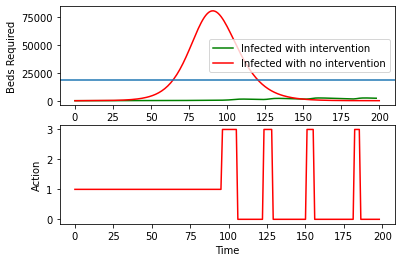

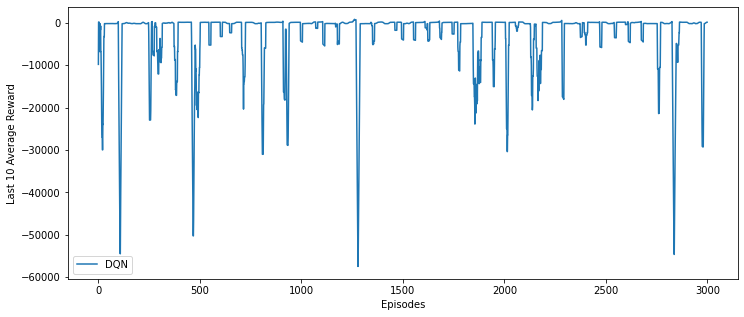

In [7]:

#limit on days.. budget 1500 =, no   -ve when capacity exceeded
dqn_model = run_algos_plot(30000,episodes=3000)


In [8]:
import pickle
filename = 'economic_days_limit_capacity_budget_1500.sav'
pickle.dump(dqn_model, open(filename, 'wb'))

action dim== 4
Reward -53670.0
episode: 1, total reward: -53670.0
episode: 2, total reward: -170.0
Reward -52684.0
episode: 3, total reward: -52684.0
episode: 4, total reward: -156.0
episode: 5, total reward: -182.0
episode: 6, total reward: -170.0
episode: 7, total reward: -166.0
episode: 8, total reward: -166.0
episode: 9, total reward: -164.0
episode: 10, total reward: -188.0
Reward -58656.0
episode: 11, total reward: -58656.0
episode: 12, total reward: 1200.0
Reward -37762.0
episode: 13, total reward: -37762.0
episode: 14, total reward: -156.0
episode: 15, total reward: -174.0
episode: 16, total reward: -196.0
episode: 17, total reward: -188.0
episode: 18, total reward: -192.0
episode: 19, total reward: -164.0
episode: 20, total reward: -176.0
episode: 21, total reward: -178.0
episode: 22, total reward: -176.0
episode: 23, total reward: -156.0
episode: 24, total reward: -188.0
episode: 25, total reward: -178.0
episode: 26, total reward: -170.0
episode: 27, total reward: -170.0
epis

episode: 226, total reward: 1192.0
episode: 227, total reward: 1182.0
episode: 228, total reward: 1148.0
episode: 229, total reward: 1166.0
episode: 230, total reward: 1160.0
episode: 231, total reward: 1128.0
episode: 232, total reward: 1122.0
episode: 233, total reward: 1090.0
episode: 234, total reward: 1110.0
episode: 235, total reward: 1108.0
episode: 236, total reward: 1080.0
episode: 237, total reward: 1096.0
episode: 238, total reward: 1096.0
episode: 239, total reward: 1102.0
episode: 240, total reward: 1082.0
episode: 241, total reward: 1144.0
episode: 242, total reward: -186.0
episode: 243, total reward: -198.0
episode: 244, total reward: 1096.0
episode: 245, total reward: 1144.0
episode: 246, total reward: 1148.0
episode: 247, total reward: 1130.0
episode: 248, total reward: 1102.0
episode: 249, total reward: 1116.0
episode: 250, total reward: 1110.0
episode: 251, total reward: 1100.0
episode: 252, total reward: 1100.0
episode: 253, total reward: -68.0
episode: 254, total r

episode: 452, total reward: 1180.0
episode: 453, total reward: 1062.0
episode: 454, total reward: -194.0
episode: 455, total reward: 1138.0
episode: 456, total reward: 1162.0
episode: 457, total reward: 1186.0
episode: 458, total reward: 1180.0
episode: 459, total reward: 1156.0
episode: 460, total reward: 1140.0
episode: 461, total reward: 1056.0
episode: 462, total reward: 1124.0
episode: 463, total reward: 1186.0
episode: 464, total reward: 1142.0
episode: 465, total reward: 1094.0
episode: 466, total reward: 1136.0
episode: 467, total reward: -62.0
episode: 468, total reward: 1048.0
episode: 469, total reward: 1096.0
episode: 470, total reward: 1088.0
episode: 471, total reward: 1102.0
episode: 472, total reward: 1094.0
episode: 473, total reward: 1072.0
episode: 474, total reward: 1108.0
episode: 475, total reward: 1114.0
episode: 476, total reward: 1120.0
episode: 477, total reward: 1118.0
episode: 478, total reward: 1082.0
episode: 479, total reward: 1118.0
episode: 480, total r

episode: 682, total reward: 1132.0
episode: 683, total reward: 1122.0
episode: 684, total reward: 1100.0
episode: 685, total reward: 1148.0
episode: 686, total reward: 1140.0
episode: 687, total reward: 1170.0
episode: 688, total reward: 1164.0
episode: 689, total reward: 1160.0
episode: 690, total reward: 1192.0
episode: 691, total reward: 1196.0
episode: 692, total reward: 1196.0
episode: 693, total reward: 1170.0
episode: 694, total reward: 1186.0
episode: 695, total reward: 1214.0
episode: 696, total reward: 1172.0
episode: 697, total reward: 1218.0
episode: 698, total reward: 1212.0
episode: 699, total reward: 1180.0
episode: 700, total reward: 1244.0
episode: 701, total reward: 1220.0
episode: 702, total reward: 1252.0
Reward -40694.0
episode: 703, total reward: -40694.0
episode: 704, total reward: 1150.0
episode: 705, total reward: 1134.0
episode: 706, total reward: 1120.0
episode: 707, total reward: 1128.0
episode: 708, total reward: 1152.0
episode: 709, total reward: 1110.0
ep

episode: 910, total reward: -200.0
episode: 911, total reward: -190.0
episode: 912, total reward: -194.0
Reward -46582.0
episode: 913, total reward: -46582.0
episode: 914, total reward: 1264.0
episode: 915, total reward: 1198.0
episode: 916, total reward: 1226.0
episode: 917, total reward: 1178.0
episode: 918, total reward: 1242.0
episode: 919, total reward: 1180.0
episode: 920, total reward: 1198.0
episode: 921, total reward: 1216.0
episode: 922, total reward: 1218.0
episode: 923, total reward: 1228.0
episode: 924, total reward: 1242.0
Reward 308.0
episode: 925, total reward: 308.0
Reward -11726.0
episode: 926, total reward: -11726.0
episode: 927, total reward: 1134.0
episode: 928, total reward: 1124.0
episode: 929, total reward: 1124.0
episode: 930, total reward: 1112.0
episode: 931, total reward: 1126.0
episode: 932, total reward: 1128.0
episode: 933, total reward: 1098.0
episode: 934, total reward: 1114.0
episode: 935, total reward: 1140.0
episode: 936, total reward: 1122.0
episode

episode: 1126, total reward: 1170.0
episode: 1127, total reward: 1212.0
episode: 1128, total reward: 1236.0
episode: 1129, total reward: 1272.0
episode: 1130, total reward: 1182.0
episode: 1131, total reward: 1158.0
episode: 1132, total reward: 1180.0
episode: 1133, total reward: 1178.0
episode: 1134, total reward: 1196.0
episode: 1135, total reward: 1232.0
Reward -8596.0
episode: 1136, total reward: -8596.0
Reward -3682.0
episode: 1137, total reward: -3682.0
episode: 1138, total reward: -19746.0
episode: 1139, total reward: 1202.0
episode: 1140, total reward: 1192.0
episode: 1141, total reward: 1196.0
episode: 1142, total reward: -204.0
episode: 1143, total reward: 1180.0
episode: 1144, total reward: -198.0
episode: 1145, total reward: 1192.0
episode: 1146, total reward: -186.0
episode: 1147, total reward: 1184.0
Reward -28672.0
episode: 1148, total reward: -28672.0
episode: 1149, total reward: 1194.0
Reward 336.0
episode: 1150, total reward: 336.0
Reward -54658.0
episode: 1151, total

episode: 1343, total reward: 1140.0
episode: 1344, total reward: 1142.0
episode: 1345, total reward: 1150.0
episode: 1346, total reward: 1148.0
episode: 1347, total reward: 1162.0
episode: 1348, total reward: 1136.0
episode: 1349, total reward: 1148.0
episode: 1350, total reward: 1068.0
episode: 1351, total reward: 1204.0
episode: 1352, total reward: 1152.0
episode: 1353, total reward: 1172.0
episode: 1354, total reward: 1158.0
episode: 1355, total reward: 1156.0
episode: 1356, total reward: 1186.0
episode: 1357, total reward: 1142.0
episode: 1358, total reward: 1208.0
episode: 1359, total reward: 1154.0
episode: 1360, total reward: 1210.0
episode: 1361, total reward: 1274.0
Reward -48746.0
episode: 1362, total reward: -48746.0
episode: 1363, total reward: -200.0
episode: 1364, total reward: -194.0
episode: 1365, total reward: -202.0
episode: 1366, total reward: -192.0
episode: 1367, total reward: -194.0
episode: 1368, total reward: -200.0
episode: 1369, total reward: -186.0
episode: 1

episode: 1565, total reward: 1126.0
episode: 1566, total reward: 1132.0
episode: 1567, total reward: 1118.0
episode: 1568, total reward: 1162.0
episode: 1569, total reward: 1104.0
episode: 1570, total reward: 1162.0
episode: 1571, total reward: 1158.0
episode: 1572, total reward: 1162.0
episode: 1573, total reward: 1190.0
episode: 1574, total reward: 1218.0
episode: 1575, total reward: 1214.0
episode: 1576, total reward: 1222.0
episode: 1577, total reward: 1216.0
episode: 1578, total reward: 1252.0
Reward -31678.0
episode: 1579, total reward: -31678.0
episode: 1580, total reward: -27784.0
episode: 1581, total reward: 1194.0
episode: 1582, total reward: -2798.0
Reward -31660.0
episode: 1583, total reward: -31660.0
Reward 360.0
episode: 1584, total reward: 360.0
episode: 1585, total reward: -194.0
episode: 1586, total reward: -130.0
Reward 352.0
episode: 1587, total reward: 352.0
episode: 1588, total reward: 1102.0
Reward -48676.0
episode: 1589, total reward: -48676.0
episode: 1590, tota

episode: 1785, total reward: 1188.0
episode: 1786, total reward: 1136.0
episode: 1787, total reward: 1150.0
episode: 1788, total reward: 1204.0
episode: 1789, total reward: 1132.0
episode: 1790, total reward: 1178.0
episode: 1791, total reward: 1174.0
episode: 1792, total reward: 1166.0
episode: 1793, total reward: 1172.0
episode: 1794, total reward: 1170.0
Reward -7706.0
episode: 1795, total reward: -7706.0
episode: 1796, total reward: -188.0
episode: 1797, total reward: 1218.0
episode: 1798, total reward: 1200.0
Reward -33744.0
episode: 1799, total reward: -33744.0
episode: 1800, total reward: 1118.0
episode: 1801, total reward: 1138.0
episode: 1802, total reward: 1090.0
episode: 1803, total reward: 1130.0
episode: 1804, total reward: 1060.0
episode: 1805, total reward: 1074.0
episode: 1806, total reward: 1102.0
episode: 1807, total reward: 1106.0
episode: 1808, total reward: 1144.0
episode: 1809, total reward: 1128.0
episode: 1810, total reward: 1078.0
episode: 1811, total reward: 1

episode: 2002, total reward: -180.0
episode: 2003, total reward: -200.0
episode: 2004, total reward: -194.0
episode: 2005, total reward: -204.0
episode: 2006, total reward: -198.0
episode: 2007, total reward: -198.0
episode: 2008, total reward: -80.0
episode: 2009, total reward: -186.0
episode: 2010, total reward: 1072.0
episode: 2011, total reward: 1120.0
episode: 2012, total reward: 1128.0
episode: 2013, total reward: 1094.0
episode: 2014, total reward: 1158.0
episode: 2015, total reward: 1156.0
episode: 2016, total reward: 1148.0
episode: 2017, total reward: 1146.0
episode: 2018, total reward: 1158.0
episode: 2019, total reward: 1160.0
episode: 2020, total reward: 1138.0
episode: 2021, total reward: 1162.0
episode: 2022, total reward: 1140.0
episode: 2023, total reward: 1118.0
episode: 2024, total reward: 1170.0
episode: 2025, total reward: 1182.0
episode: 2026, total reward: 1094.0
episode: 2027, total reward: 1130.0
episode: 2028, total reward: 1132.0
episode: 2029, total reward: 

Reward -61414.0
episode: 2224, total reward: -61414.0
Reward -57500.0
episode: 2225, total reward: -57500.0
Reward -60410.0
episode: 2226, total reward: -60410.0
Reward -53548.0
episode: 2227, total reward: -53548.0
episode: 2228, total reward: 1192.0
episode: 2229, total reward: 1198.0
episode: 2230, total reward: 1198.0
episode: 2231, total reward: 1198.0
episode: 2232, total reward: 1200.0
Reward 352.0
episode: 2233, total reward: 352.0
Reward -35652.0
episode: 2234, total reward: -35652.0
episode: 2235, total reward: 1194.0
Reward 366.0
episode: 2236, total reward: 366.0
Reward 448.0
episode: 2237, total reward: 448.0
Reward -58680.0
episode: 2238, total reward: -58680.0
episode: 2239, total reward: -194.0
episode: 2240, total reward: -192.0
episode: 2241, total reward: -192.0
episode: 2242, total reward: -182.0
episode: 2243, total reward: 1020.0
episode: 2244, total reward: 1104.0
episode: 2245, total reward: 1142.0
episode: 2246, total reward: 1092.0
episode: 2247, total reward:

episode: 2442, total reward: -190.0
episode: 2443, total reward: -196.0
episode: 2444, total reward: -176.0
Reward -73506.0
episode: 2445, total reward: -73506.0
episode: 2446, total reward: 1192.0
episode: 2447, total reward: 1196.0
episode: 2448, total reward: 1198.0
episode: 2449, total reward: 1192.0
episode: 2450, total reward: 1198.0
episode: 2451, total reward: 1196.0
episode: 2452, total reward: 1234.0
Reward 320.0
episode: 2453, total reward: 320.0
Reward -62630.0
episode: 2454, total reward: -62630.0
episode: 2455, total reward: -194.0
episode: 2456, total reward: -202.0
episode: 2457, total reward: -162.0
episode: 2458, total reward: -194.0
episode: 2459, total reward: -178.0
episode: 2460, total reward: 1008.0
episode: 2461, total reward: 1086.0
episode: 2462, total reward: 1148.0
episode: 2463, total reward: 1198.0
episode: 2464, total reward: 1174.0
episode: 2465, total reward: 1164.0
episode: 2466, total reward: 1150.0
episode: 2467, total reward: 1174.0
episode: 2468, t

episode: 2665, total reward: 1032.0
episode: 2666, total reward: 1048.0
episode: 2667, total reward: 1112.0
episode: 2668, total reward: 994.0
episode: 2669, total reward: 1096.0
episode: 2670, total reward: 1146.0
episode: 2671, total reward: 1044.0
episode: 2672, total reward: 1064.0
episode: 2673, total reward: 1110.0
episode: 2674, total reward: 1068.0
episode: 2675, total reward: 1114.0
episode: 2676, total reward: 1052.0
episode: 2677, total reward: 1132.0
episode: 2678, total reward: 1118.0
episode: 2679, total reward: 1154.0
episode: 2680, total reward: 1082.0
episode: 2681, total reward: 1120.0
episode: 2682, total reward: 1148.0
episode: 2683, total reward: 1056.0
episode: 2684, total reward: 1064.0
episode: 2685, total reward: 1186.0
episode: 2686, total reward: 1162.0
episode: 2687, total reward: 1144.0
episode: 2688, total reward: 1122.0
episode: 2689, total reward: 1156.0
episode: 2690, total reward: 1232.0
Reward -58606.0
episode: 2691, total reward: -58606.0
episode: 26

episode: 2889, total reward: 1076.0
episode: 2890, total reward: 1120.0
episode: 2891, total reward: 1126.0
episode: 2892, total reward: 1082.0
episode: 2893, total reward: 1084.0
episode: 2894, total reward: -36.0
episode: 2895, total reward: 1142.0
episode: 2896, total reward: 1136.0
episode: 2897, total reward: 1090.0
episode: 2898, total reward: 1104.0
episode: 2899, total reward: 1132.0
episode: 2900, total reward: 1030.0
episode: 2901, total reward: 1104.0
episode: 2902, total reward: -58.0
episode: 2903, total reward: 1134.0
episode: 2904, total reward: 1114.0
episode: 2905, total reward: 1102.0
episode: 2906, total reward: 1136.0
episode: 2907, total reward: 1120.0
episode: 2908, total reward: 1072.0
episode: 2909, total reward: 1114.0
episode: 2910, total reward: 1046.0
episode: 2911, total reward: 1122.0
episode: 2912, total reward: 1106.0
episode: 2913, total reward: 1064.0
episode: 2914, total reward: 1144.0
episode: 2915, total reward: 1056.0
episode: 2916, total reward: 1

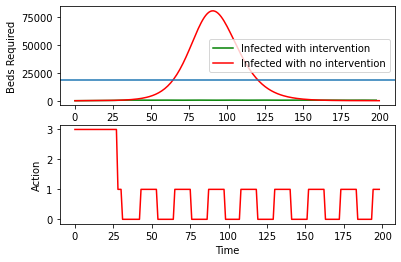

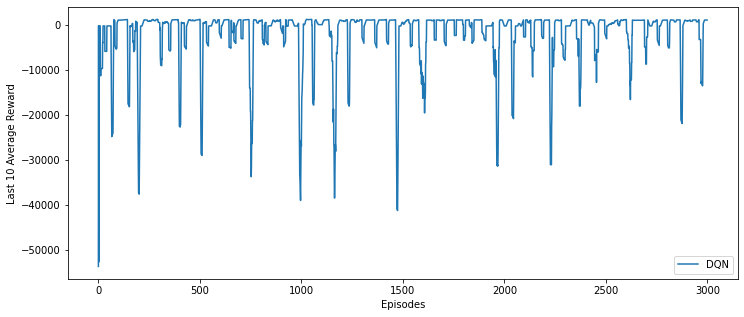

In [6]:
#limit on days.. budget 1500 =, no   -ve when capacity exceeded
dqn_model = run_algos_plot(30000,episodes=3000)
import pickle
filename = 'economic_days_limit_capacity_budget_1800.sav'
pickle.dump(dqn_model, open(filename, 'wb'))

action dim== 4
Reward -60490.0
episode: 1, total reward: -61490.0
episode: 2, total reward: -5800.0
Reward -38724.0
episode: 3, total reward: -39724.0
Reward -59390.0
episode: 4, total reward: -59390.0
episode: 5, total reward: -178.0
episode: 6, total reward: -168.0
episode: 7, total reward: -168.0
episode: 8, total reward: -182.0
episode: 9, total reward: -180.0
episode: 10, total reward: -174.0
episode: 11, total reward: -188.0
episode: 12, total reward: -178.0
episode: 13, total reward: -172.0
episode: 14, total reward: -166.0
episode: 15, total reward: -184.0
episode: 16, total reward: -194.0
episode: 17, total reward: -178.0
episode: 18, total reward: -176.0
episode: 19, total reward: -196.0
episode: 20, total reward: -180.0
episode: 21, total reward: -196.0
episode: 22, total reward: -160.0
episode: 23, total reward: -180.0
episode: 24, total reward: -192.0
episode: 25, total reward: -180.0
episode: 26, total reward: -184.0
episode: 27, total reward: 164.0
episode: 28, total rew

episode: 233, total reward: -178.0
episode: 234, total reward: -188.0
episode: 235, total reward: -196.0
episode: 236, total reward: -198.0
episode: 237, total reward: -202.0
episode: 238, total reward: -188.0
episode: 239, total reward: -196.0
episode: 240, total reward: -202.0
episode: 241, total reward: -192.0
episode: 242, total reward: -184.0
episode: 243, total reward: -194.0
episode: 244, total reward: -204.0
episode: 245, total reward: -192.0
episode: 246, total reward: -196.0
episode: 247, total reward: -188.0
episode: 248, total reward: -184.0
episode: 249, total reward: -200.0
episode: 250, total reward: -196.0
episode: 251, total reward: -200.0
episode: 252, total reward: -196.0
episode: 253, total reward: -34.0
episode: 254, total reward: -90.0
episode: 255, total reward: -194.0
episode: 256, total reward: -204.0
episode: 257, total reward: -92.0
episode: 258, total reward: -192.0
episode: 259, total reward: -194.0
episode: 260, total reward: 82.0
episode: 261, total rewar

episode: 468, total reward: -180.0
episode: 469, total reward: -196.0
episode: 470, total reward: -204.0
episode: 471, total reward: -186.0
episode: 472, total reward: -204.0
episode: 473, total reward: -192.0
episode: 474, total reward: -188.0
episode: 475, total reward: -196.0
episode: 476, total reward: 100.0
episode: 477, total reward: 100.0
episode: 478, total reward: 92.0
episode: 479, total reward: 98.0
episode: 480, total reward: 76.0
episode: 481, total reward: -178.0
episode: 482, total reward: -132.0
episode: 483, total reward: -196.0
episode: 484, total reward: -152.0
episode: 485, total reward: -184.0
episode: 486, total reward: 78.0
episode: 487, total reward: 66.0
episode: 488, total reward: 106.0
episode: 489, total reward: 102.0
episode: 490, total reward: 104.0
episode: 491, total reward: 96.0
episode: 492, total reward: -184.0
episode: 493, total reward: -160.0
episode: 494, total reward: -188.0
episode: 495, total reward: 62.0
episode: 496, total reward: 100.0
episo

Reward -40606.0
episode: 701, total reward: -41606.0
episode: 702, total reward: -192.0
episode: 703, total reward: -188.0
Reward -36744.0
episode: 704, total reward: -37744.0
Reward -52022.0
episode: 705, total reward: -52022.0
Reward -52020.0
episode: 706, total reward: -52020.0
Reward -53022.0
episode: 707, total reward: -53022.0
Reward -55012.0
episode: 708, total reward: -55012.0
Reward -53248.0
episode: 709, total reward: -53248.0
Reward -45736.0
episode: 710, total reward: -46736.0
episode: 711, total reward: -204.0
episode: 712, total reward: -188.0
episode: 713, total reward: -186.0
episode: 714, total reward: -182.0
episode: 715, total reward: -188.0
episode: 716, total reward: -194.0
episode: 717, total reward: -192.0
episode: 718, total reward: -202.0
episode: 719, total reward: -198.0
episode: 720, total reward: -92.0
episode: 721, total reward: -88.0
episode: 722, total reward: -50.0
episode: 723, total reward: -16.0
episode: 724, total reward: -8.0
episode: 725, total re

episode: 930, total reward: 124.0
episode: 931, total reward: 78.0
episode: 932, total reward: 118.0
episode: 933, total reward: 100.0
episode: 934, total reward: 114.0
episode: 935, total reward: 108.0
episode: 936, total reward: 130.0
episode: 937, total reward: 104.0
episode: 938, total reward: 98.0
episode: 939, total reward: 94.0
episode: 940, total reward: 122.0
episode: 941, total reward: 126.0
episode: 942, total reward: 58.0
episode: 943, total reward: 102.0
episode: 944, total reward: 136.0
episode: 945, total reward: 58.0
episode: 946, total reward: -196.0
episode: 947, total reward: -72.0
episode: 948, total reward: -192.0
episode: 949, total reward: -200.0
episode: 950, total reward: -202.0
episode: 951, total reward: 82.0
episode: 952, total reward: 152.0
episode: 953, total reward: -68.0
episode: 954, total reward: -188.0
episode: 955, total reward: -204.0
episode: 956, total reward: -98.0
episode: 957, total reward: -198.0
episode: 958, total reward: -192.0
episode: 959

episode: 1152, total reward: -184.0
episode: 1153, total reward: -186.0
episode: 1154, total reward: -182.0
episode: 1155, total reward: -182.0
episode: 1156, total reward: -192.0
episode: 1157, total reward: -202.0
episode: 1158, total reward: -186.0
episode: 1159, total reward: -204.0
episode: 1160, total reward: -182.0
episode: 1161, total reward: -202.0
episode: 1162, total reward: -192.0
episode: 1163, total reward: -194.0
episode: 1164, total reward: -200.0
episode: 1165, total reward: -188.0
episode: 1166, total reward: -190.0
episode: 1167, total reward: -184.0
episode: 1168, total reward: -190.0
episode: 1169, total reward: -192.0
episode: 1170, total reward: 210.0
Reward -50602.0
episode: 1171, total reward: -51602.0
episode: 1172, total reward: -8.0
episode: 1173, total reward: 190.0
episode: 1174, total reward: -196.0
episode: 1175, total reward: 192.0
episode: 1176, total reward: -90.0
episode: 1177, total reward: 196.0
episode: 1178, total reward: 0.0
episode: 1179, total

episode: 1372, total reward: -198.0
episode: 1373, total reward: -200.0
episode: 1374, total reward: -184.0
episode: 1375, total reward: -192.0
episode: 1376, total reward: -190.0
episode: 1377, total reward: -198.0
episode: 1378, total reward: -198.0
episode: 1379, total reward: -190.0
episode: 1380, total reward: -192.0
episode: 1381, total reward: -192.0
episode: 1382, total reward: -200.0
episode: 1383, total reward: -196.0
episode: 1384, total reward: -132.0
episode: 1385, total reward: -190.0
episode: 1386, total reward: -202.0
episode: 1387, total reward: -78.0
episode: 1388, total reward: -168.0
episode: 1389, total reward: -190.0
episode: 1390, total reward: -176.0
episode: 1391, total reward: -204.0
episode: 1392, total reward: -184.0
episode: 1393, total reward: -188.0
episode: 1394, total reward: -104.0
episode: 1395, total reward: -188.0
episode: 1396, total reward: -182.0
episode: 1397, total reward: -190.0
episode: 1398, total reward: -164.0
episode: 1399, total reward: 

Reward -56690.0
episode: 1595, total reward: -57690.0
episode: 1596, total reward: -194.0
episode: 1597, total reward: -196.0
episode: 1598, total reward: -198.0
episode: 1599, total reward: -188.0
episode: 1600, total reward: -196.0
episode: 1601, total reward: -196.0
episode: 1602, total reward: -194.0
episode: 1603, total reward: 44.0
episode: 1604, total reward: -170.0
episode: 1605, total reward: -194.0
episode: 1606, total reward: -200.0
episode: 1607, total reward: -96.0
episode: 1608, total reward: -190.0
episode: 1609, total reward: -188.0
episode: 1610, total reward: 16.0
episode: 1611, total reward: -180.0
episode: 1612, total reward: -200.0
episode: 1613, total reward: -80.0
episode: 1614, total reward: -192.0
episode: 1615, total reward: -190.0
episode: 1616, total reward: -196.0
episode: 1617, total reward: 46.0
episode: 1618, total reward: -186.0
episode: 1619, total reward: -24.0
episode: 1620, total reward: -188.0
episode: 1621, total reward: 22.0
episode: 1622, total 

episode: 1816, total reward: -182.0
episode: 1817, total reward: -196.0
episode: 1818, total reward: -190.0
episode: 1819, total reward: -194.0
episode: 1820, total reward: -200.0
episode: 1821, total reward: -190.0
episode: 1822, total reward: -190.0
episode: 1823, total reward: -194.0
episode: 1824, total reward: -196.0
episode: 1825, total reward: -196.0
episode: 1826, total reward: -202.0
episode: 1827, total reward: -164.0
episode: 1828, total reward: -198.0
episode: 1829, total reward: -188.0
episode: 1830, total reward: -188.0
episode: 1831, total reward: -202.0
episode: 1832, total reward: -200.0
episode: 1833, total reward: -180.0
episode: 1834, total reward: -188.0
episode: 1835, total reward: -190.0
episode: 1836, total reward: -204.0
episode: 1837, total reward: -188.0
episode: 1838, total reward: -194.0
episode: 1839, total reward: -146.0
episode: 1840, total reward: -204.0
episode: 1841, total reward: -202.0
episode: 1842, total reward: -188.0
episode: 1843, total reward:

episode: 2043, total reward: 110.0
episode: 2044, total reward: 190.0
episode: 2045, total reward: 128.0
episode: 2046, total reward: 178.0
episode: 2047, total reward: 104.0
episode: 2048, total reward: 142.0
episode: 2049, total reward: 96.0
episode: 2050, total reward: 130.0
episode: 2051, total reward: 82.0
episode: 2052, total reward: 120.0
episode: 2053, total reward: 106.0
episode: 2054, total reward: 120.0
episode: 2055, total reward: 108.0
episode: 2056, total reward: 100.0
episode: 2057, total reward: -60.0
episode: 2058, total reward: -190.0
episode: 2059, total reward: -198.0
episode: 2060, total reward: -194.0
episode: 2061, total reward: -198.0
episode: 2062, total reward: -134.0
episode: 2063, total reward: -196.0
episode: 2064, total reward: -198.0
episode: 2065, total reward: -188.0
episode: 2066, total reward: -36.0
episode: 2067, total reward: -182.0
episode: 2068, total reward: -186.0
episode: 2069, total reward: -172.0
episode: 2070, total reward: -200.0
episode: 2

episode: 2271, total reward: -196.0
episode: 2272, total reward: -192.0
episode: 2273, total reward: -190.0
episode: 2274, total reward: -200.0
episode: 2275, total reward: -192.0
episode: 2276, total reward: -198.0
episode: 2277, total reward: -186.0
episode: 2278, total reward: -200.0
episode: 2279, total reward: 160.0
episode: 2280, total reward: 204.0
Reward -59552.0
episode: 2281, total reward: -60552.0
episode: 2282, total reward: 184.0
episode: 2283, total reward: 194.0
episode: 2284, total reward: 196.0
episode: 2285, total reward: 188.0
episode: 2286, total reward: 194.0
episode: 2287, total reward: 210.0
episode: 2288, total reward: 200.0
episode: 2289, total reward: -190.0
episode: 2290, total reward: 184.0
episode: 2291, total reward: -202.0
episode: 2292, total reward: 182.0
episode: 2293, total reward: -186.0
episode: 2294, total reward: 214.0
episode: 2295, total reward: -188.0
episode: 2296, total reward: 194.0
episode: 2297, total reward: -182.0
episode: 2298, total re

episode: 2498, total reward: -192.0
episode: 2499, total reward: -186.0
episode: 2500, total reward: 88.0
episode: 2501, total reward: 174.0
episode: 2502, total reward: 106.0
episode: 2503, total reward: 128.0
episode: 2504, total reward: 118.0
episode: 2505, total reward: 126.0
episode: 2506, total reward: 150.0
episode: 2507, total reward: 148.0
episode: 2508, total reward: 118.0
episode: 2509, total reward: 210.0
episode: 2510, total reward: 226.0
episode: 2511, total reward: 236.0
episode: 2512, total reward: 262.0
episode: 2513, total reward: 182.0
episode: 2514, total reward: 232.0
episode: 2515, total reward: 222.0
episode: 2516, total reward: 212.0
episode: 2517, total reward: 244.0
episode: 2518, total reward: 246.0
Reward -47732.0
episode: 2519, total reward: -48732.0
episode: 2520, total reward: -194.0
episode: 2521, total reward: -184.0
episode: 2522, total reward: -192.0
episode: 2523, total reward: -194.0
episode: 2524, total reward: -198.0
episode: 2525, total reward: -

episode: 2719, total reward: 246.0
episode: 2720, total reward: 236.0
episode: 2721, total reward: 260.0
episode: 2722, total reward: 276.0
episode: 2723, total reward: 290.0
episode: 2724, total reward: 294.0
Reward -23628.0
episode: 2725, total reward: -24628.0
episode: 2726, total reward: 198.0
episode: 2727, total reward: 194.0
episode: 2728, total reward: 292.0
Reward -15694.0
episode: 2729, total reward: -16694.0
episode: 2730, total reward: -162.0
episode: 2731, total reward: -196.0
episode: 2732, total reward: -190.0
episode: 2733, total reward: 178.0
episode: 2734, total reward: -186.0
episode: 2735, total reward: 182.0
episode: 2736, total reward: -204.0
episode: 2737, total reward: 186.0
episode: 2738, total reward: -6.0
episode: 2739, total reward: 186.0
episode: 2740, total reward: 230.0
episode: 2741, total reward: 272.0
episode: 2742, total reward: 140.0
episode: 2743, total reward: -194.0
episode: 2744, total reward: 200.0
episode: 2745, total reward: -194.0
episode: 27

episode: 2946, total reward: 70.0
episode: 2947, total reward: -158.0
episode: 2948, total reward: -188.0
episode: 2949, total reward: 78.0
episode: 2950, total reward: -160.0
episode: 2951, total reward: -200.0
episode: 2952, total reward: -188.0
episode: 2953, total reward: -194.0
episode: 2954, total reward: -192.0
episode: 2955, total reward: -190.0
episode: 2956, total reward: -96.0
episode: 2957, total reward: -198.0
episode: 2958, total reward: -204.0
episode: 2959, total reward: -188.0
episode: 2960, total reward: -198.0
episode: 2961, total reward: -198.0
episode: 2962, total reward: -86.0
Reward -48622.0
episode: 2963, total reward: -49622.0
episode: 2964, total reward: -180.0
episode: 2965, total reward: -188.0
episode: 2966, total reward: 44.0
episode: 2967, total reward: -188.0
episode: 2968, total reward: -184.0
episode: 2969, total reward: -192.0
episode: 2970, total reward: -196.0
episode: 2971, total reward: -190.0
episode: 2972, total reward: -198.0
episode: 2973, tot

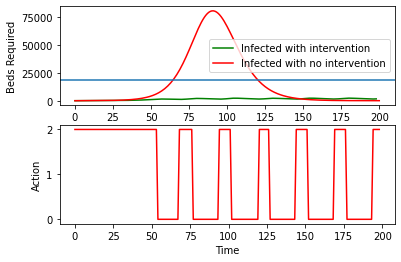

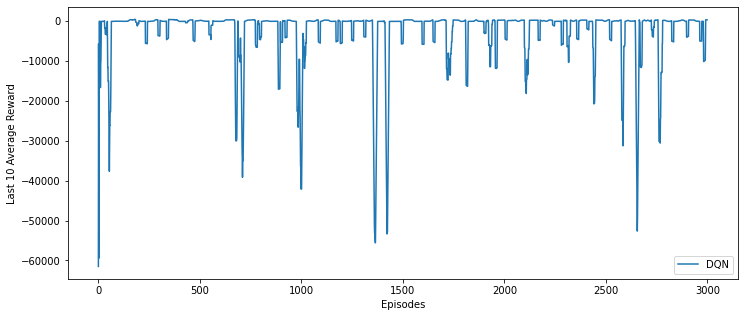

In [7]:
#limit on days.. budget 1500 =, no   -ve when capacity exceeded
dqn_model = run_algos_plot(30000,episodes=3000)
import pickle
filename = 'economic_days_limit_capacity_budget_1200.sav'
pickle.dump(dqn_model, open(filename, 'wb'))

action dim== 4
Reward -5616.0
episode: 1, total reward: -6616.0
Reward -5652.0
episode: 2, total reward: -6652.0
episode: 3, total reward: -170.0
Reward -4492.0
episode: 4, total reward: -4492.0
episode: 5, total reward: 210.0
episode: 6, total reward: -2382.0
Reward -4394.0
episode: 7, total reward: -4394.0
episode: 8, total reward: -130.0
episode: 9, total reward: -162.0
Reward -5492.0
episode: 10, total reward: -6492.0
episode: 11, total reward: 198.0
episode: 12, total reward: 202.0
episode: 13, total reward: 192.0
episode: 14, total reward: 202.0
Reward -5836.0
episode: 15, total reward: -6836.0
episode: 16, total reward: -2702.0
episode: 17, total reward: -164.0
episode: 18, total reward: -194.0
episode: 19, total reward: -190.0
episode: 20, total reward: -188.0
episode: 21, total reward: -172.0
episode: 22, total reward: -184.0
episode: 23, total reward: -178.0
episode: 24, total reward: -192.0
episode: 25, total reward: -134.0
episode: 26, total reward: -168.0
episode: 27, tota

episode: 224, total reward: 240.0
episode: 225, total reward: 176.0
episode: 226, total reward: 222.0
episode: 227, total reward: 196.0
episode: 228, total reward: 132.0
episode: 229, total reward: 294.0
episode: 230, total reward: 216.0
episode: 231, total reward: 214.0
episode: 232, total reward: 318.0
episode: 233, total reward: 218.0
episode: 234, total reward: 262.0
episode: 235, total reward: 282.0
episode: 236, total reward: 368.0
episode: 237, total reward: 318.0
episode: 238, total reward: 264.0
episode: 239, total reward: 258.0
episode: 240, total reward: 242.0
episode: 241, total reward: 284.0
episode: 242, total reward: 310.0
Reward -3934.0
episode: 243, total reward: -4934.0
Reward -2090.0
episode: 244, total reward: -3090.0
episode: 245, total reward: 290.0
episode: 246, total reward: 296.0
Reward 338.0
episode: 247, total reward: -662.0
episode: 248, total reward: 320.0
episode: 249, total reward: 334.0
episode: 250, total reward: 340.0
episode: 251, total reward: 360.0


episode: 453, total reward: 172.0
episode: 454, total reward: 148.0
episode: 455, total reward: 150.0
episode: 456, total reward: 158.0
episode: 457, total reward: 134.0
episode: 458, total reward: 142.0
episode: 459, total reward: 152.0
episode: 460, total reward: 156.0
episode: 461, total reward: 120.0
episode: 462, total reward: 178.0
episode: 463, total reward: 116.0
episode: 464, total reward: 156.0
episode: 465, total reward: 100.0
episode: 466, total reward: 152.0
episode: 467, total reward: 122.0
episode: 468, total reward: 116.0
episode: 469, total reward: 114.0
episode: 470, total reward: 100.0
episode: 471, total reward: 110.0
episode: 472, total reward: 134.0
episode: 473, total reward: 150.0
episode: 474, total reward: 196.0
episode: 475, total reward: 144.0
episode: 476, total reward: 182.0
episode: 477, total reward: 204.0
episode: 478, total reward: 266.0
Reward -4738.0
episode: 479, total reward: -5738.0
episode: 480, total reward: 142.0
episode: 481, total reward: 94.

Reward 324.0
episode: 664, total reward: -676.0
Reward 326.0
episode: 665, total reward: -674.0
Reward 334.0
episode: 666, total reward: -666.0
Reward 336.0
episode: 667, total reward: -664.0
Reward 324.0
episode: 668, total reward: -676.0
Reward 324.0
episode: 669, total reward: -676.0
Reward 350.0
episode: 670, total reward: -650.0
Reward -3902.0
episode: 671, total reward: -4902.0
episode: 672, total reward: 224.0
episode: 673, total reward: 254.0
episode: 674, total reward: 146.0
episode: 675, total reward: 144.0
episode: 676, total reward: 154.0
episode: 677, total reward: 136.0
episode: 678, total reward: 142.0
episode: 679, total reward: 160.0
episode: 680, total reward: 166.0
episode: 681, total reward: 152.0
episode: 682, total reward: 158.0
episode: 683, total reward: 170.0
episode: 684, total reward: 158.0
episode: 685, total reward: 166.0
episode: 686, total reward: 158.0
episode: 687, total reward: 156.0
episode: 688, total reward: 156.0
episode: 689, total reward: 108.0
e

episode: 891, total reward: 298.0
episode: 892, total reward: 306.0
Reward 324.0
episode: 893, total reward: -676.0
episode: 894, total reward: 272.0
episode: 895, total reward: 320.0
episode: 896, total reward: 342.0
episode: 897, total reward: 334.0
Reward 296.0
episode: 898, total reward: -704.0
episode: 899, total reward: 306.0
episode: 900, total reward: 280.0
episode: 901, total reward: 250.0
episode: 902, total reward: 292.0
episode: 903, total reward: 308.0
episode: 904, total reward: 298.0
Reward -494.0
episode: 905, total reward: -1494.0
episode: 906, total reward: 254.0
episode: 907, total reward: 280.0
episode: 908, total reward: 328.0
episode: 909, total reward: 366.0
episode: 910, total reward: 212.0
episode: 911, total reward: 230.0
episode: 912, total reward: -336.0
Reward -2584.0
episode: 913, total reward: -3584.0
episode: 914, total reward: 142.0
episode: 915, total reward: 148.0
episode: 916, total reward: 166.0
episode: 917, total reward: 168.0
episode: 918, total 

episode: 1117, total reward: 164.0
episode: 1118, total reward: 172.0
episode: 1119, total reward: 174.0
episode: 1120, total reward: 202.0
episode: 1121, total reward: 188.0
episode: 1122, total reward: 204.0
episode: 1123, total reward: 210.0
episode: 1124, total reward: 166.0
episode: 1125, total reward: 204.0
episode: 1126, total reward: 218.0
episode: 1127, total reward: -1934.0
Reward -4492.0
episode: 1128, total reward: -5492.0
episode: 1129, total reward: 264.0
Reward -4852.0
episode: 1130, total reward: -5852.0
Reward -1922.0
episode: 1131, total reward: -2922.0
Reward -5038.0
episode: 1132, total reward: -6038.0
Reward -126.0
episode: 1133, total reward: -1126.0
Reward -1430.0
episode: 1134, total reward: -2430.0
Reward 388.0
episode: 1135, total reward: -612.0
Reward -6970.0
episode: 1136, total reward: -7970.0
Reward -5098.0
episode: 1137, total reward: -5098.0
Reward 372.0
episode: 1138, total reward: -628.0
Reward 368.0
episode: 1139, total reward: -632.0
Reward -5398.0
e

Reward -3464.0
episode: 1333, total reward: -4464.0
episode: 1334, total reward: 252.0
episode: 1335, total reward: 258.0
episode: 1336, total reward: 200.0
episode: 1337, total reward: 310.0
episode: 1338, total reward: 270.0
episode: 1339, total reward: 290.0
episode: 1340, total reward: 292.0
episode: 1341, total reward: 274.0
episode: 1342, total reward: 294.0
episode: 1343, total reward: 256.0
episode: 1344, total reward: 272.0
episode: 1345, total reward: 176.0
episode: 1346, total reward: 274.0
Reward 314.0
episode: 1347, total reward: -686.0
Reward -710.0
episode: 1348, total reward: -1710.0
Reward -1428.0
episode: 1349, total reward: -2428.0
episode: 1350, total reward: 158.0
episode: 1351, total reward: 130.0
episode: 1352, total reward: 164.0
episode: 1353, total reward: 148.0
episode: 1354, total reward: 238.0
episode: 1355, total reward: 234.0
episode: 1356, total reward: 186.0
episode: 1357, total reward: 244.0
episode: 1358, total reward: 262.0
episode: 1359, total rewar

episode: 1549, total reward: 276.0
episode: 1550, total reward: 294.0
episode: 1551, total reward: 318.0
episode: 1552, total reward: 304.0
episode: 1553, total reward: 314.0
episode: 1554, total reward: 246.0
episode: 1555, total reward: 296.0
episode: 1556, total reward: 336.0
episode: 1557, total reward: 352.0
Reward 338.0
episode: 1558, total reward: -662.0
episode: 1559, total reward: 174.0
episode: 1560, total reward: 218.0
episode: 1561, total reward: 186.0
episode: 1562, total reward: 182.0
episode: 1563, total reward: 194.0
episode: 1564, total reward: -1756.0
Reward -2382.0
episode: 1565, total reward: -3382.0
episode: 1566, total reward: -2092.0
episode: 1567, total reward: -1210.0
Reward -3176.0
episode: 1568, total reward: -4176.0
episode: 1569, total reward: -240.0
episode: 1570, total reward: -1512.0
episode: 1571, total reward: 216.0
episode: 1572, total reward: -1142.0
episode: 1573, total reward: 202.0
episode: 1574, total reward: 208.0
episode: 1575, total reward: -1

episode: 1773, total reward: -194.0
Reward 318.0
episode: 1774, total reward: -682.0
episode: 1775, total reward: -176.0
Reward 314.0
episode: 1776, total reward: -686.0
Reward 324.0
episode: 1777, total reward: -676.0
Reward -3362.0
episode: 1778, total reward: -4362.0
Reward -2980.0
episode: 1779, total reward: -3980.0
episode: 1780, total reward: 132.0
episode: 1781, total reward: 156.0
episode: 1782, total reward: 158.0
episode: 1783, total reward: 152.0
episode: 1784, total reward: 142.0
episode: 1785, total reward: 156.0
episode: 1786, total reward: 140.0
episode: 1787, total reward: 142.0
episode: 1788, total reward: 152.0
episode: 1789, total reward: 128.0
episode: 1790, total reward: 146.0
episode: 1791, total reward: 160.0
episode: 1792, total reward: 158.0
episode: 1793, total reward: 160.0
episode: 1794, total reward: 168.0
episode: 1795, total reward: 116.0
episode: 1796, total reward: 146.0
episode: 1797, total reward: 194.0
episode: 1798, total reward: 258.0
episode: 179

episode: 1992, total reward: 228.0
episode: 1993, total reward: 186.0
episode: 1994, total reward: 152.0
episode: 1995, total reward: 114.0
episode: 1996, total reward: 154.0
episode: 1997, total reward: 148.0
episode: 1998, total reward: 148.0
episode: 1999, total reward: 112.0
episode: 2000, total reward: 124.0
episode: 2001, total reward: 142.0
episode: 2002, total reward: 122.0
episode: 2003, total reward: 90.0
episode: 2004, total reward: 116.0
episode: 2005, total reward: 146.0
episode: 2006, total reward: 142.0
episode: 2007, total reward: 150.0
episode: 2008, total reward: 152.0
episode: 2009, total reward: 156.0
episode: 2010, total reward: 176.0
episode: 2011, total reward: 162.0
episode: 2012, total reward: 174.0
episode: 2013, total reward: 148.0
episode: 2014, total reward: 148.0
episode: 2015, total reward: 138.0
episode: 2016, total reward: 156.0
episode: 2017, total reward: 164.0
episode: 2018, total reward: 148.0
episode: 2019, total reward: 170.0
episode: 2020, total 

Reward -2250.0
episode: 2216, total reward: -3250.0
Reward -5644.0
episode: 2217, total reward: -6644.0
Reward -3198.0
episode: 2218, total reward: -4198.0
episode: 2219, total reward: 254.0
episode: 2220, total reward: 224.0
episode: 2221, total reward: 234.0
episode: 2222, total reward: 216.0
episode: 2223, total reward: 262.0
episode: 2224, total reward: 270.0
episode: 2225, total reward: 270.0
episode: 2226, total reward: 264.0
episode: 2227, total reward: 296.0
episode: 2228, total reward: 280.0
episode: 2229, total reward: 316.0
episode: 2230, total reward: 278.0
episode: 2231, total reward: 248.0
episode: 2232, total reward: 184.0
episode: 2233, total reward: 186.0
episode: 2234, total reward: 176.0
episode: 2235, total reward: 178.0
episode: 2236, total reward: 172.0
episode: 2237, total reward: 202.0
episode: 2238, total reward: 164.0
episode: 2239, total reward: 172.0
episode: 2240, total reward: 168.0
episode: 2241, total reward: 176.0
episode: 2242, total reward: 162.0
epis

episode: 2441, total reward: 268.0
episode: 2442, total reward: 298.0
Reward -2156.0
episode: 2443, total reward: -3156.0
Reward 344.0
episode: 2444, total reward: -656.0
episode: 2445, total reward: -56.0
Reward 322.0
episode: 2446, total reward: -678.0
episode: 2447, total reward: -182.0
episode: 2448, total reward: -184.0
episode: 2449, total reward: 200.0
episode: 2450, total reward: 202.0
episode: 2451, total reward: -1052.0
episode: 2452, total reward: -822.0
Reward -4526.0
episode: 2453, total reward: -5526.0
episode: 2454, total reward: 154.0
episode: 2455, total reward: 140.0
episode: 2456, total reward: 142.0
episode: 2457, total reward: 136.0
episode: 2458, total reward: 122.0
episode: 2459, total reward: 140.0
episode: 2460, total reward: 156.0
episode: 2461, total reward: 136.0
episode: 2462, total reward: 152.0
episode: 2463, total reward: 140.0
episode: 2464, total reward: 142.0
episode: 2465, total reward: 132.0
episode: 2466, total reward: 126.0
episode: 2467, total re

Reward -3050.0
episode: 2667, total reward: -4050.0
episode: 2668, total reward: 224.0
episode: 2669, total reward: 184.0
episode: 2670, total reward: 186.0
episode: 2671, total reward: 218.0
episode: 2672, total reward: 216.0
episode: 2673, total reward: 172.0
episode: 2674, total reward: 190.0
episode: 2675, total reward: 220.0
episode: 2676, total reward: 226.0
episode: 2677, total reward: 178.0
episode: 2678, total reward: 204.0
episode: 2679, total reward: 232.0
episode: 2680, total reward: 230.0
episode: 2681, total reward: 196.0
episode: 2682, total reward: 178.0
episode: 2683, total reward: 218.0
episode: 2684, total reward: 198.0
episode: 2685, total reward: 154.0
episode: 2686, total reward: 152.0
episode: 2687, total reward: 194.0
episode: 2688, total reward: 206.0
episode: 2689, total reward: 202.0
episode: 2690, total reward: 206.0
episode: 2691, total reward: 218.0
episode: 2692, total reward: 258.0
episode: 2693, total reward: 236.0
episode: 2694, total reward: 174.0
epi

episode: 2893, total reward: -418.0
episode: 2894, total reward: 232.0
episode: 2895, total reward: 160.0
episode: 2896, total reward: 194.0
episode: 2897, total reward: 192.0
episode: 2898, total reward: 198.0
episode: 2899, total reward: 154.0
episode: 2900, total reward: 192.0
episode: 2901, total reward: 158.0
episode: 2902, total reward: 180.0
episode: 2903, total reward: 198.0
episode: 2904, total reward: 226.0
episode: 2905, total reward: 198.0
episode: 2906, total reward: 192.0
episode: 2907, total reward: 138.0
episode: 2908, total reward: 112.0
episode: 2909, total reward: 126.0
episode: 2910, total reward: 124.0
episode: 2911, total reward: 126.0
episode: 2912, total reward: 116.0
episode: 2913, total reward: 168.0
episode: 2914, total reward: 204.0
episode: 2915, total reward: 150.0
episode: 2916, total reward: 180.0
episode: 2917, total reward: -192.0
episode: 2918, total reward: -936.0
episode: 2919, total reward: -1404.0
episode: 2920, total reward: -824.0
episode: 2921,

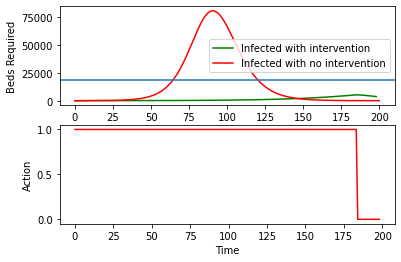

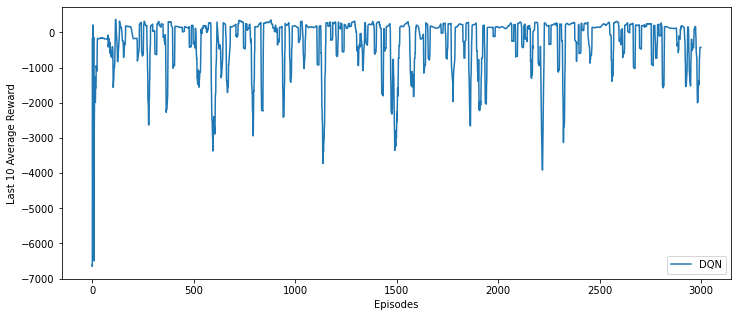

In [7]:
#limit on days.. budget 1500 =, no   -ve when capacity exceeded
dqn_model = run_algos_plot(30000,episodes=3000)
import pickle
filename = 'economic_days_limit_capacity_100_budget_1200.sav'
pickle.dump(dqn_model, open(filename, 'wb'))

action dim== 4
Reward -4158.0
episode: 1, total reward: -4073.9663865546217
Reward -4550.0
episode: 2, total reward: -4465.966386554622
Reward -5132.0
episode: 3, total reward: -5047.966386554622
Reward -5780.0
episode: 4, total reward: -5695.966386554622
Reward -5814.0
episode: 5, total reward: -5729.966386554622
Reward -4876.0
episode: 6, total reward: -4791.966386554622
episode: 7, total reward: 910.0336134453781
episode: 8, total reward: 918.0336134453781
episode: 9, total reward: 916.0336134453781
episode: 10, total reward: 910.0336134453781
episode: 11, total reward: 900.0336134453781
episode: 12, total reward: 900.0336134453781
episode: 13, total reward: 966.0336134453781
Reward -4894.0
episode: 14, total reward: -4809.966386554622
Reward -5482.0
episode: 15, total reward: -5397.966386554622
episode: 16, total reward: 896.0336134453781
episode: 17, total reward: 926.0336134453781
episode: 18, total reward: 902.0336134453781
episode: 19, total reward: 896.0336134453781
episode: 2

Reward 106.0
episode: 163, total reward: 190.03361344537814
Reward -314.0
episode: 164, total reward: -229.96638655462186
Reward -4884.0
episode: 165, total reward: -4799.966386554622
episode: 166, total reward: 1426.0336134453783
Reward 338.0
episode: 167, total reward: 422.03361344537814
episode: 168, total reward: 1360.0336134453783
Reward 314.0
episode: 169, total reward: 398.03361344537814
episode: 170, total reward: 1378.0336134453783
episode: 171, total reward: 1320.0336134453783
episode: 172, total reward: 1426.0336134453783
Reward 420.0
episode: 173, total reward: 504.03361344537814
episode: 174, total reward: 1446.0336134453783
episode: 175, total reward: 1404.0336134453783
Reward 336.0
episode: 176, total reward: 420.03361344537814
episode: 177, total reward: 1386.0336134453783
episode: 178, total reward: 1456.0336134453783
Reward 408.0
episode: 179, total reward: 492.03361344537814
episode: 180, total reward: 1328.0336134453783
episode: 181, total reward: 1264.0336134453783

Reward -3454.0
episode: 309, total reward: -3369.9663865546217
Reward 312.0
episode: 310, total reward: 396.03361344537814
Reward 304.0
episode: 311, total reward: 388.03361344537814
Reward 262.0
episode: 312, total reward: 346.03361344537814
episode: 313, total reward: 1360.0336134453783
Reward 286.0
episode: 314, total reward: 370.03361344537814
episode: 315, total reward: 1386.0336134453783
Reward 280.0
episode: 316, total reward: 364.03361344537814
Reward 312.0
episode: 317, total reward: 396.03361344537814
Reward 296.0
episode: 318, total reward: 380.03361344537814
episode: 319, total reward: 1366.0336134453783
Reward 292.0
episode: 320, total reward: 376.03361344537814
Reward 258.0
episode: 321, total reward: 342.03361344537814
Reward 280.0
episode: 322, total reward: 364.03361344537814
Reward 296.0
episode: 323, total reward: 380.03361344537814
Reward 334.0
episode: 324, total reward: 418.03361344537814
Reward -442.0
episode: 325, total reward: -357.96638655462186
Reward -396.0


Reward 470.0
episode: 458, total reward: 554.0336134453781
Reward 356.0
episode: 459, total reward: 440.03361344537814
Reward 428.0
episode: 460, total reward: 512.0336134453781
Reward -1868.0
episode: 461, total reward: -1783.9663865546217
episode: 462, total reward: 1276.0336134453783
episode: 463, total reward: 1280.0336134453783
episode: 464, total reward: 1340.0336134453783
Reward 124.0
episode: 465, total reward: 208.03361344537814
Reward 338.0
episode: 466, total reward: 422.03361344537814
Reward 272.0
episode: 467, total reward: 356.03361344537814
Reward 356.0
episode: 468, total reward: 440.03361344537814
Reward 342.0
episode: 469, total reward: 426.03361344537814
episode: 470, total reward: 1408.0336134453783
Reward 324.0
episode: 471, total reward: 408.03361344537814
episode: 472, total reward: 1372.0336134453783
episode: 473, total reward: 1428.0336134453783
Reward 314.0
episode: 474, total reward: 398.03361344537814
episode: 475, total reward: 1442.0336134453783
Reward 340

Reward 358.0
episode: 604, total reward: 442.03361344537814
Reward 406.0
episode: 605, total reward: 490.03361344537814
Reward -676.0
episode: 606, total reward: -591.9663865546219
episode: 607, total reward: -537.9663865546219
episode: 608, total reward: 1330.0336134453783
Reward 226.0
episode: 609, total reward: 310.03361344537814
episode: 610, total reward: 1280.0336134453783
Reward 236.0
episode: 611, total reward: 320.03361344537814
episode: 612, total reward: 1308.0336134453783
Reward 304.0
episode: 613, total reward: 388.03361344537814
episode: 614, total reward: 1382.0336134453783
Reward 344.0
episode: 615, total reward: 428.03361344537814
Reward 364.0
episode: 616, total reward: 448.03361344537814
episode: 617, total reward: 1352.0336134453783
Reward 430.0
episode: 618, total reward: 514.0336134453781
Reward 398.0
episode: 619, total reward: 482.03361344537814
Reward 372.0
episode: 620, total reward: 456.03361344537814
Reward 372.0
episode: 621, total reward: 456.0336134453781

Reward 388.0
episode: 750, total reward: 472.03361344537814
Reward 316.0
episode: 751, total reward: 400.03361344537814
Reward 344.0
episode: 752, total reward: 428.03361344537814
Reward 374.0
episode: 753, total reward: 458.03361344537814
episode: 754, total reward: 1422.0336134453783
Reward 348.0
episode: 755, total reward: 432.03361344537814
Reward 358.0
episode: 756, total reward: 442.03361344537814
Reward 340.0
episode: 757, total reward: 424.03361344537814
Reward 342.0
episode: 758, total reward: 426.03361344537814
Reward 374.0
episode: 759, total reward: 458.03361344537814
Reward 392.0
episode: 760, total reward: 476.03361344537814
Reward 432.0
episode: 761, total reward: 516.0336134453781
Reward 420.0
episode: 762, total reward: 504.03361344537814
Reward 448.0
episode: 763, total reward: 532.0336134453781
Reward -1084.0
episode: 764, total reward: -999.9663865546219
Reward 334.0
episode: 765, total reward: 418.03361344537814
Reward 364.0
episode: 766, total reward: 448.03361344

episode: 904, total reward: 1444.0336134453783
Reward 356.0
episode: 905, total reward: 440.03361344537814
episode: 906, total reward: 1418.0336134453783
Reward 362.0
episode: 907, total reward: 446.03361344537814
episode: 908, total reward: 1382.0336134453783
episode: 909, total reward: 1374.0336134453783
episode: 910, total reward: 1406.0336134453783
episode: 911, total reward: 1394.0336134453783
Reward 320.0
episode: 912, total reward: 404.03361344537814
Reward 332.0
episode: 913, total reward: 416.03361344537814
Reward 420.0
episode: 914, total reward: 504.03361344537814
Reward 468.0
episode: 915, total reward: 552.0336134453781
Reward 374.0
episode: 916, total reward: 458.03361344537814
Reward 378.0
episode: 917, total reward: 462.03361344537814
Reward 350.0
episode: 918, total reward: 434.03361344537814
Reward 334.0
episode: 919, total reward: 418.03361344537814
Reward 372.0
episode: 920, total reward: 456.03361344537814
Reward 420.0
episode: 921, total reward: 504.03361344537814

Reward 364.0
episode: 1057, total reward: 448.03361344537814
Reward 322.0
episode: 1058, total reward: 406.03361344537814
Reward 346.0
episode: 1059, total reward: 430.03361344537814
episode: 1060, total reward: 1454.0336134453783
Reward 340.0
episode: 1061, total reward: 424.03361344537814
Reward 396.0
episode: 1062, total reward: 480.03361344537814
episode: 1063, total reward: 1472.0336134453783
Reward 386.0
episode: 1064, total reward: 470.03361344537814
episode: 1065, total reward: 1356.0336134453783
Reward 340.0
episode: 1066, total reward: 424.03361344537814
Reward 406.0
episode: 1067, total reward: 490.03361344537814
Reward 454.0
episode: 1068, total reward: 538.0336134453781
Reward 330.0
episode: 1069, total reward: 414.03361344537814
episode: 1070, total reward: 1394.0336134453783
episode: 1071, total reward: 1402.0336134453783
episode: 1072, total reward: 1436.0336134453783
Reward 370.0
episode: 1073, total reward: 454.03361344537814
Reward -1080.0
episode: 1074, total reward

Reward 344.0
episode: 1201, total reward: 428.03361344537814
Reward 388.0
episode: 1202, total reward: 472.03361344537814
Reward 354.0
episode: 1203, total reward: 438.03361344537814
Reward 362.0
episode: 1204, total reward: 446.03361344537814
Reward 376.0
episode: 1205, total reward: 460.03361344537814
Reward 422.0
episode: 1206, total reward: 506.03361344537814
Reward -1534.0
episode: 1207, total reward: -1449.9663865546217
Reward 308.0
episode: 1208, total reward: 392.03361344537814
Reward 368.0
episode: 1209, total reward: 452.03361344537814
Reward 292.0
episode: 1210, total reward: 376.03361344537814
episode: 1211, total reward: 1394.0336134453783
Reward -814.0
episode: 1212, total reward: -729.9663865546219
episode: 1213, total reward: 1310.0336134453783
episode: 1214, total reward: 1364.0336134453783
episode: 1215, total reward: 1392.0336134453783
Reward 60.0
episode: 1216, total reward: 144.03361344537814
Reward 398.0
episode: 1217, total reward: 482.03361344537814
Reward 388.0

Reward -3806.0
episode: 1354, total reward: -3721.9663865546217
episode: 1355, total reward: -2151.9663865546217
Reward -7920.0
episode: 1356, total reward: -7835.966386554622
Reward -4838.0
episode: 1357, total reward: -4753.966386554622
Reward 320.0
episode: 1358, total reward: 404.03361344537814
Reward 338.0
episode: 1359, total reward: 422.03361344537814
Reward -3798.0
episode: 1360, total reward: -3713.9663865546217
Reward 352.0
episode: 1361, total reward: 436.03361344537814
Reward -6660.0
episode: 1362, total reward: -6575.966386554622
Reward 330.0
episode: 1363, total reward: 414.03361344537814
Reward 336.0
episode: 1364, total reward: 420.03361344537814
Reward 358.0
episode: 1365, total reward: 442.03361344537814
Reward 334.0
episode: 1366, total reward: 418.03361344537814
Reward -3560.0
episode: 1367, total reward: -3475.9663865546217
Reward 330.0
episode: 1368, total reward: 414.03361344537814
Reward 358.0
episode: 1369, total reward: 442.03361344537814
Reward 340.0
episode:

episode: 1500, total reward: 1432.0336134453783
Reward 296.0
episode: 1501, total reward: 380.03361344537814
episode: 1502, total reward: 1370.0336134453783
episode: 1503, total reward: 1412.0336134453783
Reward 328.0
episode: 1504, total reward: 412.03361344537814
Reward 298.0
episode: 1505, total reward: 382.03361344537814
Reward 372.0
episode: 1506, total reward: 456.03361344537814
Reward 416.0
episode: 1507, total reward: 500.03361344537814
Reward 390.0
episode: 1508, total reward: 474.03361344537814
Reward -1120.0
episode: 1509, total reward: -1035.9663865546217
episode: 1510, total reward: 1358.0336134453783
episode: 1511, total reward: 1442.0336134453783
episode: 1512, total reward: 1406.0336134453783
episode: 1513, total reward: 1400.0336134453783
episode: 1514, total reward: 1370.0336134453783
episode: 1515, total reward: 1412.0336134453783
episode: 1516, total reward: 1426.0336134453783
episode: 1517, total reward: 1410.0336134453783
episode: 1518, total reward: 1440.03361344

episode: 1658, total reward: 1322.0336134453783
episode: 1659, total reward: 1264.0336134453783
episode: 1660, total reward: 1358.0336134453783
episode: 1661, total reward: 1328.0336134453783
episode: 1662, total reward: 1314.0336134453783
episode: 1663, total reward: 1342.0336134453783
Reward 322.0
episode: 1664, total reward: 406.03361344537814
episode: 1665, total reward: 1304.0336134453783
episode: 1666, total reward: 1382.0336134453783
Reward 358.0
episode: 1667, total reward: 442.03361344537814
episode: 1668, total reward: 1296.0336134453783
episode: 1669, total reward: 1362.0336134453783
episode: 1670, total reward: 1380.0336134453783
episode: 1671, total reward: 1376.0336134453783
episode: 1672, total reward: 1346.0336134453783
episode: 1673, total reward: 1326.0336134453783
episode: 1674, total reward: 1334.0336134453783
episode: 1675, total reward: 1356.0336134453783
episode: 1676, total reward: 1384.0336134453783
episode: 1677, total reward: 1368.0336134453783
episode: 1678,

episode: 1824, total reward: 1200.0336134453783
episode: 1825, total reward: 1280.0336134453783
episode: 1826, total reward: 1320.0336134453783
episode: 1827, total reward: 1326.0336134453783
episode: 1828, total reward: 1312.0336134453783
episode: 1829, total reward: 1372.0336134453783
episode: 1830, total reward: 1374.0336134453783
episode: 1831, total reward: 1346.0336134453783
episode: 1832, total reward: 1362.0336134453783
episode: 1833, total reward: 1338.0336134453783
episode: 1834, total reward: 1372.0336134453783
episode: 1835, total reward: 1396.0336134453783
episode: 1836, total reward: 1428.0336134453783
episode: 1837, total reward: 1432.0336134453783
episode: 1838, total reward: 1388.0336134453783
episode: 1839, total reward: 1328.0336134453783
Reward 298.0
episode: 1840, total reward: 382.03361344537814
episode: 1841, total reward: 1390.0336134453783
episode: 1842, total reward: 1312.0336134453783
episode: 1843, total reward: 1338.0336134453783
episode: 1844, total reward

Reward 410.0
episode: 1986, total reward: 494.03361344537814
Reward 372.0
episode: 1987, total reward: 456.03361344537814
Reward 400.0
episode: 1988, total reward: 484.03361344537814
Reward 394.0
episode: 1989, total reward: 478.03361344537814
Reward 408.0
episode: 1990, total reward: 492.03361344537814
Reward 360.0
episode: 1991, total reward: 444.03361344537814
episode: 1992, total reward: 1424.0336134453783
Reward 348.0
episode: 1993, total reward: 432.03361344537814
Reward 360.0
episode: 1994, total reward: 444.03361344537814
episode: 1995, total reward: 1446.0336134453783
Reward 324.0
episode: 1996, total reward: 408.03361344537814
Reward 406.0
episode: 1997, total reward: 490.03361344537814
episode: 1998, total reward: 1462.0336134453783
Reward 380.0
episode: 1999, total reward: 464.03361344537814
Reward 320.0
episode: 2000, total reward: 404.03361344537814
Reward 394.0
episode: 2001, total reward: 478.03361344537814
Reward 422.0
episode: 2002, total reward: 506.03361344537814
Re

episode: 2148, total reward: 1254.0336134453783
episode: 2149, total reward: 1262.0336134453783
episode: 2150, total reward: 1248.0336134453783
episode: 2151, total reward: 1266.0336134453783
episode: 2152, total reward: 1302.0336134453783
episode: 2153, total reward: 1330.0336134453783
Reward -2536.0
episode: 2154, total reward: -2451.9663865546217
Reward -2214.0
episode: 2155, total reward: -2129.9663865546217
Reward -4642.0
episode: 2156, total reward: -4557.966386554622
episode: 2157, total reward: 1252.0336134453783
episode: 2158, total reward: 1220.0336134453783
episode: 2159, total reward: 1280.0336134453783
episode: 2160, total reward: 1310.0336134453783
episode: 2161, total reward: 1318.0336134453783
episode: 2162, total reward: 1330.0336134453783
episode: 2163, total reward: 1304.0336134453783
episode: 2164, total reward: 1294.0336134453783
episode: 2165, total reward: 1298.0336134453783
episode: 2166, total reward: 1286.0336134453783
episode: 2167, total reward: 1318.0336134

episode: 2311, total reward: 1216.0336134453783
episode: 2312, total reward: 1290.0336134453783
episode: 2313, total reward: 1292.0336134453783
episode: 2314, total reward: 1218.0336134453783
episode: 2315, total reward: 1286.0336134453783
episode: 2316, total reward: 1302.0336134453783
episode: 2317, total reward: 1288.0336134453783
episode: 2318, total reward: 1332.0336134453783
episode: 2319, total reward: 1288.0336134453783
episode: 2320, total reward: 1356.0336134453783
episode: 2321, total reward: 1290.0336134453783
episode: 2322, total reward: 1302.0336134453783
episode: 2323, total reward: 1340.0336134453783
episode: 2324, total reward: 1318.0336134453783
episode: 2325, total reward: 1392.0336134453783
episode: 2326, total reward: 1362.0336134453783
episode: 2327, total reward: 1408.0336134453783
Reward -4236.0
episode: 2328, total reward: -4151.966386554622
Reward 466.0
episode: 2329, total reward: 550.0336134453781
Reward -1268.0
episode: 2330, total reward: -1183.96638655462

episode: 2469, total reward: 1362.0336134453783
episode: 2470, total reward: 1410.0336134453783
episode: 2471, total reward: 1378.0336134453783
episode: 2472, total reward: 1362.0336134453783
episode: 2473, total reward: 1340.0336134453783
episode: 2474, total reward: 1306.0336134453783
episode: 2475, total reward: 1352.0336134453783
episode: 2476, total reward: 1260.0336134453783
episode: 2477, total reward: 1360.0336134453783
Reward 244.0
episode: 2478, total reward: 328.03361344537814
Reward -6312.0
episode: 2479, total reward: -6227.966386554622
Reward -5210.0
episode: 2480, total reward: -5125.966386554622
episode: 2481, total reward: 940.0336134453781
episode: 2482, total reward: 1300.0336134453783
Reward -1092.0
episode: 2483, total reward: -1007.9663865546219
episode: 2484, total reward: 1288.0336134453783
episode: 2485, total reward: 1304.0336134453783
episode: 2486, total reward: 1284.0336134453783
episode: 2487, total reward: 1358.0336134453783
episode: 2488, total reward: 1

episode: 2626, total reward: 390.03361344537814
episode: 2627, total reward: 1316.0336134453783
episode: 2628, total reward: 1288.0336134453783
episode: 2629, total reward: 1370.0336134453783
episode: 2630, total reward: 1376.0336134453783
episode: 2631, total reward: 1346.0336134453783
Reward -4522.0
episode: 2632, total reward: -4437.966386554622
episode: 2633, total reward: 1254.0336134453783
episode: 2634, total reward: 1196.0336134453783
episode: 2635, total reward: 1196.0336134453783
episode: 2636, total reward: 1150.0336134453783
episode: 2637, total reward: 1172.0336134453783
episode: 2638, total reward: 1218.0336134453783
episode: 2639, total reward: 1212.0336134453783
episode: 2640, total reward: 1220.0336134453783
episode: 2641, total reward: 1222.0336134453783
episode: 2642, total reward: 1208.0336134453783
episode: 2643, total reward: 1224.0336134453783
episode: 2644, total reward: 1254.0336134453783
episode: 2645, total reward: 1234.0336134453783
episode: 2646, total rewa

episode: 2789, total reward: 1338.0336134453783
episode: 2790, total reward: 1374.0336134453783
episode: 2791, total reward: 1386.0336134453783
episode: 2792, total reward: 1354.0336134453783
episode: 2793, total reward: 1408.0336134453783
episode: 2794, total reward: 1250.0336134453783
episode: 2795, total reward: 1424.0336134453783
Reward 340.0
episode: 2796, total reward: 424.03361344537814
Reward -5180.0
episode: 2797, total reward: -5095.966386554622
Reward -4498.0
episode: 2798, total reward: -4413.966386554622
Reward -3410.0
episode: 2799, total reward: -3325.9663865546217
Reward -1986.0
episode: 2800, total reward: -1901.9663865546217
Reward -4542.0
episode: 2801, total reward: -4457.966386554622
episode: 2802, total reward: 1312.0336134453783
episode: 2803, total reward: 1276.0336134453783
episode: 2804, total reward: 1326.0336134453783
episode: 2805, total reward: -257.96638655462186
episode: 2806, total reward: 762.0336134453781
Reward -5072.0
episode: 2807, total reward: -4

episode: 2949, total reward: 888.0336134453781
episode: 2950, total reward: 890.0336134453781
episode: 2951, total reward: 1114.0336134453783
Reward -6166.0
episode: 2952, total reward: -6081.966386554622
Reward -5100.0
episode: 2953, total reward: -5015.966386554622
episode: 2954, total reward: 1280.0336134453783
episode: 2955, total reward: 1274.0336134453783
episode: 2956, total reward: 1280.0336134453783
episode: 2957, total reward: 880.0336134453781
episode: 2958, total reward: 898.0336134453781
episode: 2959, total reward: 884.0336134453781
episode: 2960, total reward: 902.0336134453781
episode: 2961, total reward: 888.0336134453781
episode: 2962, total reward: 882.0336134453781
episode: 2963, total reward: 900.0336134453781
episode: 2964, total reward: 886.0336134453781
episode: 2965, total reward: 886.0336134453781
episode: 2966, total reward: 1324.0336134453783
Reward 368.0
episode: 2967, total reward: 452.03361344537814
Reward -5292.0
episode: 2968, total reward: -5207.966386

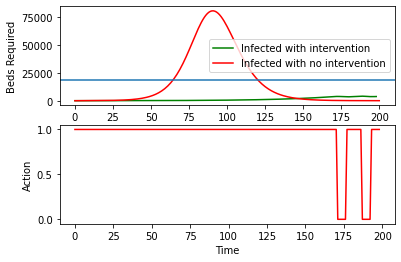

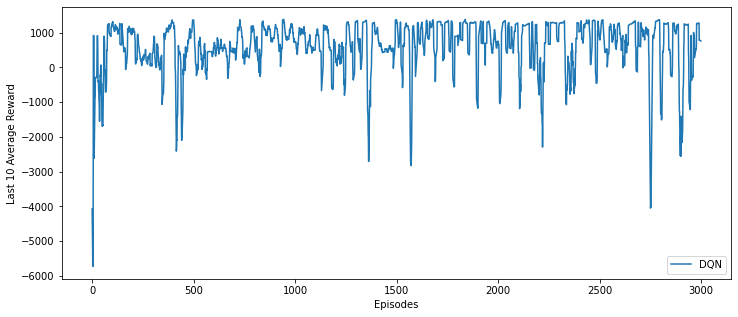

In [6]:
#limit on days.. budget 1500 =, no   -ve when capacity exceeded
dqn_model = run_algos_plot(30000,episodes=3000)
import pickle
filename = 'economic_days_limit_capacity_100_new_budget_1200.sav'
pickle.dump(dqn_model, open(filename, 'wb'))

action dim== 4
Reward -7100
episode: 1, total reward: -6810.982658959538
Reward -6200
episode: 2, total reward: -4950.0
episode: 3, total reward: -10000
episode: 4, total reward: -10000
episode: 5, total reward: -10000
Reward -5200
episode: 6, total reward: -15200
Reward -5500
episode: 7, total reward: -15500
episode: 8, total reward: -10000
episode: 9, total reward: -10000
episode: 10, total reward: -10400
Reward -6000
episode: 11, total reward: -5812.0300751879695
Reward -6100
episode: 12, total reward: -5715.384615384615
episode: 13, total reward: -10000
Reward -5800
episode: 14, total reward: -15800
episode: 15, total reward: -11600
Reward -6100
episode: 16, total reward: -5874.774774774774
Reward -7000
episode: 17, total reward: -6666.666666666667
Reward -6400
episode: 18, total reward: -5724.324324324324
Reward -6800
episode: 19, total reward: -16800
episode: 20, total reward: -12700
Reward -6100
episode: 21, total reward: -5878.761061946902
Reward -7100
episode: 22, total reward

Reward -7200
episode: 190, total reward: -6871.0526315789475
Reward -7100
episode: 191, total reward: -6773.2026143790845
Reward -6500
episode: 192, total reward: -5833.333333333333
episode: 193, total reward: -10000
Reward -5900
episode: 194, total reward: -5389.7959183673465
episode: 195, total reward: -10000
episode: 196, total reward: -10000
Reward -6300
episode: 197, total reward: -5390.909090909091
episode: 198, total reward: -10000
episode: 199, total reward: -10000
episode: 200, total reward: -10000
episode: 201, total reward: -10000
episode: 202, total reward: -10000
episode: 203, total reward: -10000
episode: 204, total reward: -10000
episode: 205, total reward: -10000
Reward -5100
episode: 206, total reward: -15100
episode: 207, total reward: -10000
episode: 208, total reward: -10000
episode: 209, total reward: -10000
episode: 210, total reward: -10000
episode: 211, total reward: -10000
Reward -5600
episode: 212, total reward: -3516.666666666667
episode: 213, total reward: -

episode: 377, total reward: -10000
Reward -6200
episode: 378, total reward: -5947.474747474747
Reward -7100
episode: 379, total reward: -6773.2026143790845
Reward -7100
episode: 380, total reward: -6594.949494949495
episode: 381, total reward: -10000
Reward -5500
episode: 382, total reward: -15500
episode: 383, total reward: -10000
episode: 384, total reward: -10000
Reward -7100
episode: 385, total reward: -6882.608695652174
Reward -6400
episode: 386, total reward: -6252.941176470588
Reward -6600
episode: 387, total reward: -6456.733524355301
Reward -6100
episode: 388, total reward: -5882.608695652174
Reward -7100
episode: 389, total reward: -6156.603773584906
episode: 390, total reward: -10000
episode: 391, total reward: -10000
episode: 392, total reward: -10000
Reward -7400
episode: 393, total reward: -7164.1509433962265
Reward -5900
episode: 394, total reward: -3900.0
episode: 395, total reward: -10000
episode: 396, total reward: -10000
episode: 397, total reward: -10000
Reward -550

episode: 564, total reward: -10000
Reward -6400
episode: 565, total reward: -5593.548387096775
episode: 566, total reward: -10000
episode: 567, total reward: -10000
Reward -5900
episode: 568, total reward: -5389.7959183673465
episode: 569, total reward: -10000
episode: 570, total reward: -10000
episode: 571, total reward: -10000
Reward -7400
episode: 572, total reward: -7172.727272727273
Reward -5400
episode: 573, total reward: 19600.0
episode: 574, total reward: -10000
episode: 575, total reward: -10000
episode: 576, total reward: -10000
episode: 577, total reward: -10000
episode: 578, total reward: -10000
episode: 579, total reward: -10000
episode: 580, total reward: -10000
Reward -4700
episode: 581, total reward: -14700
Reward -5200
episode: 582, total reward: -15200
episode: 583, total reward: -10000
episode: 584, total reward: -10000
episode: 585, total reward: -10000
episode: 586, total reward: -10000
episode: 587, total reward: -10000
episode: 588, total reward: -10000
Reward -5

Reward -7100
episode: 745, total reward: -6773.2026143790845
Reward -7000
episode: 746, total reward: -6671.0526315789475
Reward -7200
episode: 747, total reward: -6871.0526315789475
Reward -6400
episode: 748, total reward: -5618.75
episode: 749, total reward: -10000
episode: 750, total reward: -10000
Reward -7100
episode: 751, total reward: -6732.35294117647
Reward -7200
episode: 752, total reward: -6866.666666666667
Reward -6400
episode: 753, total reward: -5742.105263157895
episode: 754, total reward: -10000
Reward -5400
episode: 755, total reward: -15400
episode: 756, total reward: -10000
episode: 757, total reward: -10000
episode: 758, total reward: -10000
Reward -5600
episode: 759, total reward: -15600
Reward -6400
episode: 760, total reward: -5664.705882352941
episode: 761, total reward: -10000
episode: 762, total reward: -10000
Reward -6600
episode: 763, total reward: -6359.615384615385
Reward -6400
episode: 764, total reward: -5767.088607594937
episode: 765, total reward: -100

episode: 926, total reward: -10000
Reward -5100
episode: 927, total reward: -15100
episode: 928, total reward: -10000
Reward -6200
episode: 929, total reward: -5944.897959183673
Reward -6900
episode: 930, total reward: -6344.444444444444
episode: 931, total reward: -10000
Reward -6000
episode: 932, total reward: 250.0
episode: 933, total reward: -10000
episode: 934, total reward: -10000
episode: 935, total reward: -10000
Reward -6300
episode: 936, total reward: -6067.441860465116
Reward -6500
episode: 937, total reward: -5842.105263157895
episode: 938, total reward: -10000
Reward -5200
episode: 939, total reward: -15200
episode: 940, total reward: -10000
Reward -6400
episode: 941, total reward: -6165.258215962442
Reward -7500
episode: 942, total reward: -7265.258215962442
Reward -6300
episode: 943, total reward: -6082.608695652174
Reward -6900
episode: 944, total reward: -6651.243781094528
Reward -5300
episode: 945, total reward: 44700.0
episode: 946, total reward: -10000
episode: 947,

episode: 1107, total reward: -10000
episode: 1108, total reward: -10900
Reward -5100
episode: 1109, total reward: -15100
episode: 1110, total reward: -10000
episode: 1111, total reward: -10000
Reward -5300
episode: 1112, total reward: -15300
episode: 1113, total reward: -10000
episode: 1114, total reward: -12400
Reward -6300
episode: 1115, total reward: -6069.585253456221
Reward -7200
episode: 1116, total reward: -6871.0526315789475
Reward -7200
episode: 1117, total reward: -6871.0526315789475
Reward -7100
episode: 1118, total reward: -6768.87417218543
Reward -6900
episode: 1119, total reward: -5617.948717948718
episode: 1120, total reward: -10000
Reward -5400
episode: 1121, total reward: 2933.333333333332
episode: 1122, total reward: -10000
episode: 1123, total reward: -10000
episode: 1124, total reward: -10000
Reward -6300
episode: 1125, total reward: -6047.474747474747
Reward -6800
episode: 1126, total reward: -5448.648648648648
episode: 1127, total reward: -10000
episode: 1128, tot

episode: 1286, total reward: -10000
episode: 1287, total reward: -10000
Reward -5400
episode: 1288, total reward: -15400
Reward -6400
episode: 1289, total reward: -6244.72049689441
Reward -6400
episode: 1290, total reward: -6254.6511627906975
Reward -6600
episode: 1291, total reward: -6455.907780979827
Reward -6600
episode: 1292, total reward: -6455.907780979827
Reward -6400
episode: 1293, total reward: -6255.072463768116
Reward -6400
episode: 1294, total reward: -6194.238683127572
Reward -7100
episode: 1295, total reward: -6623.809523809524
episode: 1296, total reward: -10000
episode: 1297, total reward: -10000
Reward -6300
episode: 1298, total reward: -5493.548387096775
episode: 1299, total reward: -10000
Reward -6000
episode: 1300, total reward: -5450.549450549451
episode: 1301, total reward: -10000
episode: 1302, total reward: -10000
Reward -5200
episode: 1303, total reward: -15200
episode: 1304, total reward: -10000
episode: 1305, total reward: -10000
episode: 1306, total reward: 

episode: 1459, total reward: -10000
Reward -5800
episode: 1460, total reward: 19200.0
episode: 1461, total reward: -10000
episode: 1462, total reward: -10000
episode: 1463, total reward: -10000
episode: 1464, total reward: -10000
episode: 1465, total reward: -10000
Reward -5200
episode: 1466, total reward: -15200
episode: 1467, total reward: -10000
episode: 1468, total reward: -10000
Reward -5100
episode: 1469, total reward: -15100
episode: 1470, total reward: -10000
Reward -6500
episode: 1471, total reward: -5556.603773584906
episode: 1472, total reward: -10000
Reward -5300
episode: 1473, total reward: -15300
episode: 1474, total reward: -10000
episode: 1475, total reward: -10000
episode: 1476, total reward: -10000
Reward -6100
episode: 1477, total reward: -1100.0
episode: 1478, total reward: -10000
episode: 1479, total reward: -10000
Reward -5400
episode: 1480, total reward: -15400
episode: 1481, total reward: -10000
episode: 1482, total reward: -10000
Reward -5700
episode: 1483, tot

Reward -3900
episode: 1643, total reward: -3022.8070175438597
Reward -4800
episode: 1644, total reward: -4341.284403669724
Reward -3000
episode: 1645, total reward: -2137.9310344827586
episode: 1646, total reward: -10000
Reward -5500
episode: 1647, total reward: -4590.909090909091
episode: 1648, total reward: -10000
episode: 1649, total reward: -11800
episode: 1650, total reward: -11000
episode: 1651, total reward: -12500
Reward -4300
episode: 1652, total reward: -2448.1481481481483
Reward -4200
episode: 1653, total reward: -3709.8039215686276
Reward -5600
episode: 1654, total reward: -5186.7768595041325
Reward -4400
episode: 1655, total reward: -3894.9494949494947
Reward -4900
episode: 1656, total reward: -4409.803921568628
Reward -4300
episode: 1657, total reward: -3762.3655913978496
Reward -3900
episode: 1658, total reward: -3093.548387096774
Reward -3000
episode: 1659, total reward: -2324.324324324324
Reward -2400
episode: 1660, total reward: -1642.4242424242425
Reward -1000
episod

episode: 1799, total reward: -10900
Reward -3300
episode: 1800, total reward: 1245.454545454546
Reward -1000
episode: 1801, total reward: -11000
Reward -5500
episode: 1802, total reward: -5023.809523809524
Reward -3700
episode: 1803, total reward: -3111.764705882353
Reward -5300
episode: 1804, total reward: -4553.731343283582
episode: 1805, total reward: -10000
Reward -4500
episode: 1806, total reward: -3479.591836734694
Reward -3100
episode: 1807, total reward: -1988.888888888889
Reward -1000
episode: 1808, total reward: 15666.666666666664
Reward -1000
episode: 1809, total reward: 6142.857142857142
Reward -1000
episode: 1810, total reward: -11000
episode: 1811, total reward: -10000
episode: 1812, total reward: -10000
episode: 1813, total reward: -10000
episode: 1814, total reward: -10000
episode: 1815, total reward: -10000
episode: 1816, total reward: -10000
episode: 1817, total reward: -10000
Reward -3900
episode: 1818, total reward: -2788.8888888888887
Reward -3100
episode: 1819, to

Reward -3200
episode: 1958, total reward: -2611.764705882353
Reward -3300
episode: 1959, total reward: -2682.716049382716
Reward -3000
episode: 1960, total reward: -2324.324324324324
Reward -3000
episode: 1961, total reward: -1684.2105263157896
Reward -2300
episode: 1962, total reward: -1300.0
Reward -1800
episode: 1963, total reward: -890.909090909091
Reward -1000
episode: 1964, total reward: -397.59036144578306
Reward -1000
episode: 1965, total reward: 86.9565217391305
Reward -1000
episode: 1966, total reward: 282.051282051282
Reward -1000
episode: 1967, total reward: -193.54838709677426
Reward -1000
episode: 1968, total reward: 162.79069767441865
episode: 1969, total reward: 1315.7894736842104
Reward -1000
episode: 1970, total reward: 1500.0
Reward -1000
episode: 1971, total reward: 1173.913043478261
episode: 1972, total reward: 5555.555555555556
episode: 1973, total reward: 12500.0
episode: 1974, total reward: -10000
episode: 1975, total reward: -10000
episode: 1976, total reward: 

episode: 2134, total reward: -10000
episode: 2135, total reward: -10000
episode: 2136, total reward: -10000
episode: 2137, total reward: -10000
episode: 2138, total reward: -10000
episode: 2139, total reward: -10000
episode: 2140, total reward: -10000
episode: 2141, total reward: -10000
episode: 2142, total reward: -10000
episode: 2143, total reward: -10000
episode: 2144, total reward: -10000
episode: 2145, total reward: -10000
episode: 2146, total reward: -10000
episode: 2147, total reward: -10000
Reward -4200
episode: 2148, total reward: -2533.333333333333
episode: 2149, total reward: -10000
episode: 2150, total reward: -10000
episode: 2151, total reward: -10000
Reward -4200
episode: 2152, total reward: -1700.0
episode: 2153, total reward: -10000
episode: 2154, total reward: -10000
episode: 2155, total reward: 3125.0
Reward -2400
episode: 2156, total reward: 1766.666666666666
Reward -2600
episode: 2157, total reward: 2955.5555555555557
Reward -2700
episode: 2158, total reward: -1033.

episode: 2302, total reward: 25000.0
episode: 2303, total reward: -10000
episode: 2304, total reward: -10000
episode: 2305, total reward: -10000
episode: 2306, total reward: -10000
episode: 2307, total reward: -10000
episode: 2308, total reward: -10000
episode: 2309, total reward: -10000
episode: 2310, total reward: -10000
episode: 2311, total reward: -10000
episode: 2312, total reward: -10000
episode: 2313, total reward: -10000
episode: 2314, total reward: -10000
episode: 2315, total reward: -10000
episode: 2316, total reward: -10000
episode: 2317, total reward: -10000
Reward -3100
episode: 2318, total reward: -2293.548387096774
episode: 2319, total reward: 2777.777777777778
episode: 2320, total reward: -10000
episode: 2321, total reward: 1388.888888888889
episode: 2322, total reward: 847.457627118644
episode: 2323, total reward: 2500.0
episode: 2324, total reward: 7142.857142857142
episode: 2325, total reward: -10000
episode: 2326, total reward: -10000
episode: 2327, total reward: -1

Reward -4100
episode: 2474, total reward: -14100
Reward -3800
episode: 2475, total reward: -2819.607843137255
Reward -3600
episode: 2476, total reward: -2818.75
Reward -3200
episode: 2477, total reward: -2550.6493506493507
Reward -3500
episode: 2478, total reward: -2538.4615384615386
Reward -2500
episode: 2479, total reward: -1071.4285714285716
Reward -2500
episode: 2480, total reward: -1029.4117647058824
Reward -2300
episode: 2481, total reward: -784.8484848484848
Reward -2000
episode: 2482, total reward: -387.0967741935485
Reward -1800
episode: 2483, total reward: -187.09677419354853
episode: 2484, total reward: 1324.1379310344828
Reward -2400
episode: 2485, total reward: -614.2857142857144
Reward -2300
episode: 2486, total reward: -1017.948717948718
Reward -1900
episode: 2487, total reward: -175.8620689655172
Reward -2200
episode: 2488, total reward: -684.8484848484848
Reward -2100
episode: 2489, total reward: -433.33333333333326
Reward -1800
episode: 2490, total reward: -371.428571

episode: 2641, total reward: -10000
Reward -4700
episode: 2642, total reward: -14700
episode: 2643, total reward: -750.0
Reward -3000
episode: 2644, total reward: -2019.6078431372548
episode: 2645, total reward: -10000
Reward -2800
episode: 2646, total reward: -1966.6666666666665
episode: 2647, total reward: 1351.3513513513515
Reward -2300
episode: 2648, total reward: -514.2857142857144
Reward -1500
episode: 2649, total reward: -693.5483870967743
episode: 2650, total reward: 1562.5
episode: 2651, total reward: 1785.7142857142856
episode: 2652, total reward: -10000
episode: 2653, total reward: 1282.051282051282
episode: 2654, total reward: 7142.857142857142
episode: 2655, total reward: -10000
episode: 2656, total reward: 7142.857142857142
episode: 2657, total reward: 1923.076923076923
Reward -1000
episode: 2658, total reward: 24000.0
episode: 2659, total reward: -10000
episode: 2660, total reward: -10000
episode: 2661, total reward: -10000
episode: 2662, total reward: 1612.9032258064515

Reward -3600
episode: 2804, total reward: -2674.074074074074
Reward -3700
episode: 2805, total reward: -3118.6046511627906
Reward -3800
episode: 2806, total reward: -3244.4444444444443
Reward -4300
episode: 2807, total reward: -3725.287356321839
Reward -5800
episode: 2808, total reward: -5150.649350649351
Reward -3200
episode: 2809, total reward: -2366.6666666666665
Reward -2000
episode: 2810, total reward: -913.0434782608695
Reward -1800
episode: 2811, total reward: 2366.666666666666
Reward -3300
episode: 2812, total reward: -2690.243902439024
Reward -3500
episode: 2813, total reward: -2413.0434782608695
Reward -3600
episode: 2814, total reward: -2437.209302325581
Reward -3700
episode: 2815, total reward: -2700.0
Reward -2000
episode: 2816, total reward: -1000.0
Reward -1000
episode: 2817, total reward: 724.1379310344828
Reward -1000
episode: 2818, total reward: 190.47619047619037
Reward -1000
episode: 2819, total reward: -56.60377358490575
Reward -1000
episode: 2820, total reward: 51

episode: 2960, total reward: -10000
episode: 2961, total reward: -10000
episode: 2962, total reward: -10000
episode: 2963, total reward: -10000
episode: 2964, total reward: -10000
episode: 2965, total reward: -10000
episode: 2966, total reward: -10000
episode: 2967, total reward: -10000
episode: 2968, total reward: -10000
episode: 2969, total reward: -10000
episode: 2970, total reward: -10000
episode: 2971, total reward: -10000
episode: 2972, total reward: -10000
episode: 2973, total reward: -10000
episode: 2974, total reward: -10000
episode: 2975, total reward: 3333.3333333333335
episode: 2976, total reward: -10000
episode: 2977, total reward: -10000
episode: 2978, total reward: -10000
episode: 2979, total reward: -10000
episode: 2980, total reward: -10000
episode: 2981, total reward: -10000
episode: 2982, total reward: -10000
episode: 2983, total reward: -10000
episode: 2984, total reward: -10000
episode: 2985, total reward: -10000
episode: 2986, total reward: -10000
episode: 2987, t

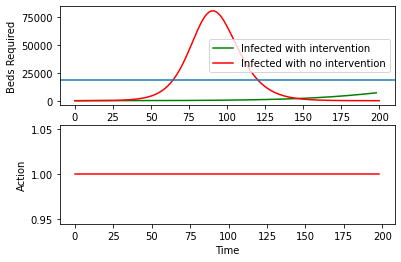

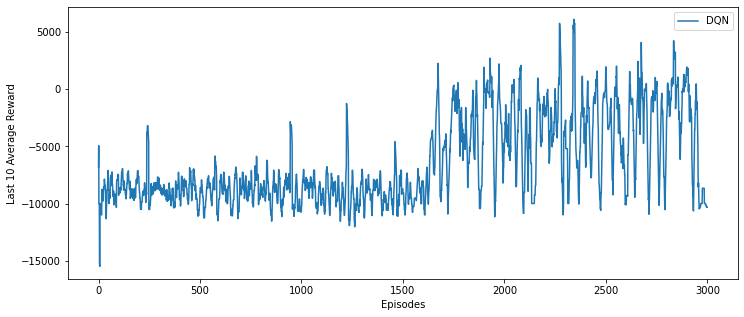

In [6]:
#limit on days.. budget 1500 =, no   -ve when capacity exceeded
dqn_model = run_algos_plot(30000,episodes=3000)
import pickle
filename = 'economic_days_limit_capacity_100_new_budget_1500_no_positive.sav'
pickle.dump(dqn_model, open(filename, 'wb'))

action dim== 4
diff= 94.0  total= 1406.0
1 1063.8297872340424
episode: 1, total reward: 100282.97872340426
diff= -78.0  total= 1578.0
2 -780000.0
episode: 2, total reward: -783000.0
diff= 232.0  total= 1268.0
1 431.0344827586207
episode: 3, total reward: 38103.448275862065
diff= -82.0  total= 1582.0
2 -820000.0
episode: 4, total reward: -821000.0
diff= 250.0  total= 1250.0
1 400.0
episode: 5, total reward: 34700.0
diff= 302.0  total= 1198.0
1 331.12582781456956
episode: 6, total reward: 26912.582781456957
diff= 296.0  total= 1204.0
1 337.83783783783787
episode: 7, total reward: 27583.783783783787
diff= 304.0  total= 1196.0
1 328.9473684210526
episode: 8, total reward: 26794.73684210526
diff= 296.0  total= 1204.0
1 337.83783783783787
episode: 9, total reward: 27683.783783783787
diff= 298.0  total= 1202.0
1 335.5704697986577
episode: 10, total reward: 26957.046979865772
diff= 296.0  total= 1204.0
1 337.83783783783787
episode: 11, total reward: 27683.783783783787
diff= 290.0  total= 1210.

diff= 520.0  total= 980.0
1 192.30769230769232
episode: 91, total reward: 11330.76923076923
diff= 480.0  total= 1020.0
1 208.33333333333334
episode: 92, total reward: 13533.333333333332
diff= 524.0  total= 976.0
1 190.83969465648855
episode: 93, total reward: 11083.969465648854
diff= 290.0  total= 1210.0
1 344.82758620689657
episode: 94, total reward: 26682.758620689652
diff= 524.0  total= 976.0
1 190.83969465648855
episode: 95, total reward: 10783.969465648854
diff= 500.0  total= 1000.0
1 200.0
episode: 96, total reward: 12700.0
diff= 484.0  total= 1016.0
1 206.61157024793388
episode: 97, total reward: 13161.157024793389
diff= 482.0  total= 1018.0
1 207.4688796680498
episode: 98, total reward: 13246.887966804978
diff= 502.0  total= 998.0
1 199.20318725099602
episode: 99, total reward: 12420.318725099602
diff= 494.0  total= 1006.0
1 202.42914979757086
episode: 100, total reward: 12842.914979757086
diff= 480.0  total= 1020.0
1 208.33333333333334
episode: 101, total reward: 13333.3333333

diff= 244.0  total= 1256.0
1 409.8360655737705
episode: 180, total reward: 33883.606557377054
diff= 268.0  total= 1232.0
1 373.13432835820896
episode: 181, total reward: 30113.432835820895
diff= 276.0  total= 1224.0
1 362.3188405797101
episode: 182, total reward: 30631.884057971016
diff= 266.0  total= 1234.0
1 375.9398496240601
episode: 183, total reward: 30393.984962406015
diff= 266.0  total= 1234.0
1 375.9398496240601
episode: 184, total reward: 30293.984962406015
diff= 296.0  total= 1204.0
1 337.83783783783787
episode: 185, total reward: 28383.783783783787
diff= 264.0  total= 1236.0
1 378.7878787878788
episode: 186, total reward: 30478.78787878788
diff= 244.0  total= 1256.0
1 409.8360655737705
episode: 187, total reward: 33883.606557377054
diff= 244.0  total= 1256.0
1 409.8360655737705
episode: 188, total reward: 33983.606557377054
diff= 250.0  total= 1250.0
1 400.0
episode: 189, total reward: 32900.0
diff= 262.0  total= 1238.0
1 381.6793893129771
episode: 190, total reward: 30767.9

diff= 162.0  total= 1338.0
1 617.283950617284
episode: 270, total reward: 55828.39506172839
diff= 164.0  total= 1336.0
1 609.7560975609756
episode: 271, total reward: 54775.60975609756
diff= 182.0  total= 1318.0
1 549.4505494505495
episode: 272, total reward: 48545.05494505495
diff= 154.0  total= 1346.0
1 649.3506493506494
episode: 273, total reward: 57835.06493506494
diff= 148.0  total= 1352.0
1 675.6756756756757
episode: 274, total reward: 61667.567567567574
diff= 178.0  total= 1322.0
1 561.7977528089888
episode: 275, total reward: 49079.77528089887
diff= 148.0  total= 1352.0
1 675.6756756756757
episode: 276, total reward: 62667.567567567574
diff= 174.0  total= 1326.0
1 574.7126436781609
episode: 277, total reward: 50171.26436781609
diff= 156.0  total= 1344.0
1 641.025641025641
episode: 278, total reward: 58502.5641025641
diff= 150.0  total= 1350.0
1 666.6666666666667
episode: 279, total reward: 59866.66666666667
diff= 164.0  total= 1336.0
1 609.7560975609756
episode: 280, total rewa

diff= 510.0  total= 990.0
1 196.078431372549
episode: 359, total reward: 14907.843137254902
diff= 552.0  total= 948.0
1 181.15942028985506
episode: 360, total reward: 12815.942028985508
diff= 416.0  total= 1084.0
1 240.3846153846154
episode: 361, total reward: 18838.46153846154
diff= 390.0  total= 1110.0
1 256.4102564102564
episode: 362, total reward: 20941.02564102564
diff= 374.0  total= 1126.0
1 267.379679144385
episode: 363, total reward: 22037.9679144385
diff= 380.0  total= 1120.0
1 263.1578947368421
episode: 364, total reward: 21515.78947368421
diff= 506.0  total= 994.0
1 197.6284584980237
episode: 365, total reward: 14962.845849802372
diff= 546.0  total= 954.0
1 183.15018315018315
episode: 366, total reward: 12915.018315018315
diff= 504.0  total= 996.0
1 198.4126984126984
episode: 367, total reward: 14441.269841269841
diff= 378.0  total= 1122.0
1 264.55026455026456
episode: 368, total reward: 21555.026455026455
diff= 376.0  total= 1124.0
1 265.9574468085106
episode: 369, total re

diff= 326.0  total= 1174.0
1 306.7484662576687
episode: 447, total reward: 22374.846625766873
diff= 304.0  total= 1196.0
1 328.9473684210526
episode: 448, total reward: 24494.73684210526
diff= 326.0  total= 1174.0
1 306.7484662576687
episode: 449, total reward: 22674.846625766873
diff= 284.0  total= 1216.0
1 352.11267605633805
episode: 450, total reward: 26511.267605633802
diff= 312.0  total= 1188.0
1 320.5128205128205
episode: 451, total reward: 24251.28205128205
diff= 278.0  total= 1222.0
1 359.71223021582733
episode: 452, total reward: 27571.223021582737
diff= 302.0  total= 1198.0
1 331.12582781456956
episode: 453, total reward: 24712.582781456957
diff= 280.0  total= 1220.0
1 357.1428571428571
episode: 454, total reward: 27314.28571428571
diff= 330.0  total= 1170.0
1 303.030303030303
episode: 455, total reward: 22603.030303030304
diff= 288.0  total= 1212.0
1 347.22222222222223
episode: 456, total reward: 26322.22222222222
diff= 304.0  total= 1196.0
1 328.9473684210526
episode: 457, 

diff= 584.0  total= 916.0
1 171.23287671232876
episode: 537, total reward: 10023.287671232876
diff= 604.0  total= 896.0
1 165.56291390728478
episode: 538, total reward: 9356.291390728478
diff= 562.0  total= 938.0
1 177.9359430604982
episode: 539, total reward: 9793.594306049821
diff= 548.0  total= 952.0
1 182.4817518248175
episode: 540, total reward: 10548.175182481751
diff= 548.0  total= 952.0
1 182.4817518248175
episode: 541, total reward: 10048.175182481751
diff= 508.0  total= 992.0
1 196.8503937007874
episode: 542, total reward: 10885.039370078739
diff= 512.0  total= 988.0
1 195.3125
episode: 543, total reward: 11031.25
diff= 564.0  total= 936.0
1 177.3049645390071
episode: 544, total reward: 9830.496453900709
diff= 580.0  total= 920.0
1 172.41379310344828
episode: 545, total reward: 9741.379310344826
diff= 604.0  total= 896.0
1 165.56291390728478
episode: 546, total reward: 9456.291390728478
diff= 554.0  total= 946.0
1 180.50541516245488
episode: 547, total reward: 10150.541516245

diff= 502.0  total= 998.0
1 199.20318725099602
episode: 626, total reward: 11920.318725099602
diff= 456.0  total= 1044.0
1 219.29824561403507
episode: 627, total reward: 13529.824561403508
diff= 472.0  total= 1028.0
1 211.864406779661
episode: 628, total reward: 12886.4406779661
diff= 420.0  total= 1080.0
1 238.09523809523813
episode: 629, total reward: 15309.523809523813
diff= 186.0  total= 1314.0
1 537.6344086021505
episode: 630, total reward: 45863.44086021506
diff= 194.0  total= 1306.0
1 515.4639175257732
episode: 631, total reward: 43546.39175257732
diff= 212.0  total= 1288.0
1 471.6981132075471
episode: 632, total reward: 39869.811320754714
diff= 216.0  total= 1284.0
1 462.96296296296293
episode: 633, total reward: 38596.29629629629
diff= 218.0  total= 1282.0
1 458.7155963302753
episode: 634, total reward: 38371.55963302752
diff= 218.0  total= 1282.0
1 458.7155963302753
episode: 635, total reward: 38571.55963302752
diff= 196.0  total= 1304.0
1 510.204081632653
episode: 636, total

diff= 186.0  total= 1314.0
1 537.6344086021505
episode: 715, total reward: 50763.44086021506
diff= 194.0  total= 1306.0
1 515.4639175257732
episode: 716, total reward: 47946.39175257732
diff= 208.0  total= 1292.0
1 480.7692307692308
episode: 717, total reward: 44076.92307692308
diff= 216.0  total= 1284.0
1 462.96296296296293
episode: 718, total reward: 42296.29629629629
diff= 212.0  total= 1288.0
1 471.6981132075471
episode: 719, total reward: 43169.811320754714
diff= 220.0  total= 1280.0
1 454.5454545454545
episode: 720, total reward: 41354.545454545456
diff= 218.0  total= 1282.0
1 458.7155963302753
episode: 721, total reward: 41971.55963302752
diff= 220.0  total= 1280.0
1 454.5454545454545
episode: 722, total reward: 41354.545454545456
diff= 188.0  total= 1312.0
1 531.9148936170212
episode: 723, total reward: 48991.48936170213
diff= 224.0  total= 1276.0
1 446.4285714285714
episode: 724, total reward: 40542.85714285714
diff= 224.0  total= 1276.0
1 446.4285714285714
episode: 725, total

diff= 176.0  total= 1324.0
1 568.1818181818182
episode: 804, total reward: 52518.181818181816
diff= 190.0  total= 1310.0
1 526.3157894736842
episode: 805, total reward: 48031.57894736842
diff= 186.0  total= 1314.0
1 537.6344086021505
episode: 806, total reward: 49663.44086021506
diff= 190.0  total= 1310.0
1 526.3157894736842
episode: 807, total reward: 48731.57894736842
diff= 186.0  total= 1314.0
1 537.6344086021505
episode: 808, total reward: 50163.44086021506
diff= 188.0  total= 1312.0
1 531.9148936170212
episode: 809, total reward: 48291.48936170213
diff= 202.0  total= 1298.0
1 495.0495049504951
episode: 810, total reward: 44904.9504950495
diff= 206.0  total= 1294.0
1 485.43689320388347
episode: 811, total reward: 44143.689320388345
diff= 198.0  total= 1302.0
1 505.0505050505051
episode: 812, total reward: 45705.05050505051
diff= 190.0  total= 1310.0
1 526.3157894736842
episode: 813, total reward: 49031.57894736842
diff= 192.0  total= 1308.0
1 520.8333333333333
episode: 814, total r

diff= 234.0  total= 1266.0
1 427.35042735042737
episode: 897, total reward: 39735.04273504274
diff= 254.0  total= 1246.0
1 393.7007874015748
episode: 898, total reward: 36770.07874015748
diff= 258.0  total= 1242.0
1 387.5968992248062
episode: 899, total reward: 35859.68992248062
diff= 274.0  total= 1226.0
1 364.963503649635
episode: 900, total reward: 33496.3503649635
diff= 340.0  total= 1160.0
1 294.11764705882354
episode: 901, total reward: 25811.764705882353
diff= 278.0  total= 1222.0
1 359.71223021582733
episode: 902, total reward: 33071.22302158274
diff= 310.0  total= 1190.0
1 322.5806451612903
episode: 903, total reward: 29358.064516129034
diff= 328.0  total= 1172.0
1 304.8780487804878
episode: 904, total reward: 27387.80487804878
diff= 348.0  total= 1152.0
1 287.35632183908046
episode: 905, total reward: 24835.632183908045
diff= 358.0  total= 1142.0
1 279.3296089385475
episode: 906, total reward: 23832.96089385475
diff= 338.0  total= 1162.0
1 295.85798816568047
episode: 907, tot

diff= 418.0  total= 1082.0
1 239.23444976076553
episode: 985, total reward: 14623.444976076553
diff= 430.0  total= 1070.0
1 232.5581395348837
episode: 986, total reward: 14555.81395348837
diff= 396.0  total= 1104.0
1 252.52525252525254
episode: 987, total reward: 17652.525252525254
diff= 394.0  total= 1106.0
1 253.80710659898475
episode: 988, total reward: 16680.710659898476
diff= 388.0  total= 1112.0
1 257.7319587628866
episode: 989, total reward: 18973.19587628866
diff= 408.0  total= 1092.0
1 245.09803921568627
episode: 990, total reward: 16309.803921568626
diff= 420.0  total= 1080.0
1 238.09523809523813
episode: 991, total reward: 15509.523809523813
diff= 370.0  total= 1130.0
1 270.27027027027026
episode: 992, total reward: 18527.02702702703
diff= 380.0  total= 1120.0
1 263.1578947368421
episode: 993, total reward: 17615.78947368421
diff= 398.0  total= 1102.0
1 251.25628140703517
episode: 994, total reward: 16425.628140703517
diff= 366.0  total= 1134.0
1 273.224043715847
episode: 99

diff= 242.0  total= 1258.0
1 413.22314049586777
episode: 1073, total reward: 37122.31404958678
diff= 118.0  total= 1382.0
1 847.457627118644
episode: 1074, total reward: 84345.7627118644
diff= -96.0  total= 1596.0
2 -960000.0
episode: 1075, total reward: -960000.0
diff= 152.0  total= 1348.0
1 657.8947368421052
episode: 1076, total reward: 62889.47368421052
diff= 160.0  total= 1340.0
1 625.0
episode: 1077, total reward: 59400.0
diff= 176.0  total= 1324.0
1 568.1818181818182
episode: 1078, total reward: 52918.181818181816
diff= 198.0  total= 1302.0
1 505.0505050505051
episode: 1079, total reward: 47205.05050505051
diff= 200.0  total= 1300.0
1 500.0
episode: 1080, total reward: 46500.0
diff= 182.0  total= 1318.0
1 549.4505494505495
episode: 1081, total reward: 51445.05494505495
diff= 202.0  total= 1298.0
1 495.0495049504951
episode: 1082, total reward: 46404.9504950495
diff= 172.0  total= 1328.0
1 581.3953488372093
episode: 1083, total reward: 53739.53488372093
diff= 208.0  total= 1292.0


diff= 336.0  total= 1164.0
1 297.6190476190476
episode: 1161, total reward: 22861.90476190476
diff= 336.0  total= 1164.0
1 297.6190476190476
episode: 1162, total reward: 22161.90476190476
diff= 348.0  total= 1152.0
1 287.35632183908046
episode: 1163, total reward: 22135.632183908045
diff= 346.0  total= 1154.0
1 289.01734104046244
episode: 1164, total reward: 22101.73410404624
diff= 290.0  total= 1210.0
1 344.82758620689657
episode: 1165, total reward: 26682.758620689652
diff= 300.0  total= 1200.0
1 333.33333333333337
episode: 1166, total reward: 29033.333333333336
diff= 362.0  total= 1138.0
1 276.2430939226519
episode: 1167, total reward: 20124.309392265193
diff= 286.0  total= 1214.0
1 349.65034965034965
episode: 1168, total reward: 28065.034965034967
diff= 330.0  total= 1170.0
1 303.030303030303
episode: 1169, total reward: 23703.030303030304
diff= 316.0  total= 1184.0
1 316.4556962025316
episode: 1170, total reward: 25545.569620253165
diff= 392.0  total= 1108.0
1 255.1020408163265
ep

diff= -484.0  total= 1984.0
2 -4840000.0
episode: 1249, total reward: -4840000.0
diff= 172.0  total= 1328.0
1 581.3953488372093
episode: 1250, total reward: 55239.53488372093
diff= 168.0  total= 1332.0
1 595.2380952380952
episode: 1251, total reward: 58423.80952380952
diff= 96.0  total= 1404.0
1 1041.6666666666665
episode: 1252, total reward: 101066.66666666666
diff= 132.0  total= 1368.0
1 757.5757575757576
episode: 1253, total reward: 74457.57575757576
diff= 146.0  total= 1354.0
1 684.931506849315
episode: 1254, total reward: 67793.1506849315
diff= 120.0  total= 1380.0
1 833.3333333333334
episode: 1255, total reward: 83333.33333333333
diff= 102.0  total= 1398.0
1 980.3921568627451
episode: 1256, total reward: 98039.2156862745
diff= 90.0  total= 1410.0
1 1111.111111111111
episode: 1257, total reward: 111111.11111111111
diff= 122.0  total= 1378.0
1 819.672131147541
episode: 1258, total reward: 81967.21311475411
diff= 92.0  total= 1408.0
1 1086.9565217391305
episode: 1259, total reward: 

diff= -18.0  total= 1518.0
2 -180000.0
episode: 1349, total reward: -180000.0
diff= 100.0  total= 1400.0
1 1000.0
episode: 1350, total reward: 100000.0
diff= 106.0  total= 1394.0
1 943.3962264150942
episode: 1351, total reward: 94339.62264150943
diff= 118.0  total= 1382.0
1 847.457627118644
episode: 1352, total reward: 84745.7627118644
diff= 118.0  total= 1382.0
1 847.457627118644
episode: 1353, total reward: 84745.7627118644
diff= 108.0  total= 1392.0
1 925.9259259259259
episode: 1354, total reward: 92592.59259259258
diff= 96.0  total= 1404.0
1 1041.6666666666665
episode: 1355, total reward: 104166.66666666666
diff= 106.0  total= 1394.0
1 943.3962264150942
episode: 1356, total reward: 94339.62264150943
diff= 144.0  total= 1356.0
1 694.4444444444445
episode: 1357, total reward: 69444.44444444444
diff= 164.0  total= 1336.0
1 609.7560975609756
episode: 1358, total reward: 58775.60975609756
diff= 180.0  total= 1320.0
1 555.5555555555555
episode: 1359, total reward: 50255.555555555555
diff

diff= 538.0  total= 962.0
1 185.87360594795538
episode: 1438, total reward: 10787.360594795537
diff= 576.0  total= 924.0
1 173.61111111111111
episode: 1439, total reward: 9961.11111111111
diff= 464.0  total= 1036.0
1 215.51724137931035
episode: 1440, total reward: 14351.724137931033
diff= 492.0  total= 1008.0
1 203.25203252032523
episode: 1441, total reward: 15325.203252032523
diff= 442.0  total= 1058.0
1 226.24434389140274
episode: 1442, total reward: 16124.434389140275
diff= 462.0  total= 1038.0
1 216.45021645021646
episode: 1443, total reward: 15345.021645021647
diff= 440.0  total= 1060.0
1 227.27272727272725
episode: 1444, total reward: 15227.272727272728
diff= 480.0  total= 1020.0
1 208.33333333333334
episode: 1445, total reward: 13433.333333333332
diff= 458.0  total= 1042.0
1 218.34061135371178
episode: 1446, total reward: 14534.06113537118
diff= 454.0  total= 1046.0
1 220.26431718061676
episode: 1447, total reward: 14926.431718061674
diff= 488.0  total= 1012.0
1 204.918032786885

diff= 198.0  total= 1302.0
1 505.0505050505051
episode: 1525, total reward: 42905.05050505051
diff= 162.0  total= 1338.0
1 617.283950617284
episode: 1526, total reward: 55028.39506172839
diff= 192.0  total= 1308.0
1 520.8333333333333
episode: 1527, total reward: 44583.33333333333
diff= 178.0  total= 1322.0
1 561.7977528089888
episode: 1528, total reward: 48679.77528089887
diff= 154.0  total= 1346.0
1 649.3506493506494
episode: 1529, total reward: 58335.06493506494
diff= 214.0  total= 1286.0
1 467.28971962616816
episode: 1530, total reward: 39128.97196261682
diff= 176.0  total= 1324.0
1 568.1818181818182
episode: 1531, total reward: 49518.181818181816
diff= 166.0  total= 1334.0
1 602.4096385542169
episode: 1532, total reward: 53340.96385542169
diff= 184.0  total= 1316.0
1 543.4782608695652
episode: 1533, total reward: 47247.82608695652
diff= 184.0  total= 1316.0
1 543.4782608695652
episode: 1534, total reward: 47047.82608695652
diff= 170.0  total= 1330.0
1 588.2352941176471
episode: 153

diff= 678.0  total= 822.0
1 147.49262536873155
episode: 1614, total reward: 9549.262536873157
diff= 698.0  total= 802.0
1 143.26647564469914
episode: 1615, total reward: 8726.647564469913
diff= 660.0  total= 840.0
1 151.5151515151515
episode: 1616, total reward: 9851.515151515152
diff= 652.0  total= 848.0
1 153.37423312883436
episode: 1617, total reward: 9037.423312883437
diff= 634.0  total= 866.0
1 157.72870662460568
episode: 1618, total reward: 9772.870662460567
diff= 628.0  total= 872.0
1 159.23566878980893
episode: 1619, total reward: 9723.566878980893
diff= 680.0  total= 820.0
1 147.05882352941177
episode: 1620, total reward: 9205.882352941177
diff= 664.0  total= 836.0
1 150.60240963855424
episode: 1621, total reward: 9260.240963855422
diff= 566.0  total= 934.0
1 176.67844522968198
episode: 1622, total reward: 12867.844522968197
diff= 542.0  total= 958.0
1 184.50184501845018
episode: 1623, total reward: 13650.184501845019
diff= 658.0  total= 842.0
1 151.9756838905775
episode: 1624

diff= 400.0  total= 1100.0
1 250.0
episode: 1703, total reward: 16800.0
diff= 372.0  total= 1128.0
1 268.81720430107526
episode: 1704, total reward: 18181.72043010753
diff= 446.0  total= 1054.0
1 224.2152466367713
episode: 1705, total reward: 13421.52466367713
diff= 450.0  total= 1050.0
1 222.22222222222223
episode: 1706, total reward: 13122.222222222223
diff= 420.0  total= 1080.0
1 238.09523809523813
episode: 1707, total reward: 15909.523809523813
diff= 438.0  total= 1062.0
1 228.31050228310502
episode: 1708, total reward: 13631.050228310502
diff= 424.0  total= 1076.0
1 235.84905660377356
episode: 1709, total reward: 15684.905660377357
diff= 434.0  total= 1066.0
1 230.4147465437788
episode: 1710, total reward: 14841.474654377882
diff= 436.0  total= 1064.0
1 229.35779816513764
episode: 1711, total reward: 14435.779816513761
diff= 434.0  total= 1066.0
1 230.4147465437788
episode: 1712, total reward: 13241.474654377882
diff= 456.0  total= 1044.0
1 219.29824561403507
episode: 1713, total 

diff= 148.0  total= 1352.0
1 675.6756756756757
episode: 1791, total reward: 60467.567567567574
diff= 254.0  total= 1246.0
1 393.7007874015748
episode: 1792, total reward: 31470.078740157478
diff= 74.0  total= 1426.0
1 1351.3513513513515
episode: 1793, total reward: 130335.13513513515
diff= 344.0  total= 1156.0
1 290.69767441860466
episode: 1794, total reward: 20769.767441860466
diff= 78.0  total= 1422.0
1 1282.051282051282
episode: 1795, total reward: 122505.1282051282
diff= 28.0  total= 1472.0
1 3571.428571428571
episode: 1796, total reward: 353842.8571428571
diff= 404.0  total= 1096.0
1 247.52475247524754
episode: 1797, total reward: 17152.47524752475
diff= 368.0  total= 1132.0
1 271.7391304347826
episode: 1798, total reward: 19273.91304347826
diff= 288.0  total= 1212.0
1 347.22222222222223
episode: 1799, total reward: 26222.22222222222
diff= 246.0  total= 1254.0
1 406.50406504065046
episode: 1800, total reward: 32650.406504065046
diff= 238.0  total= 1262.0
1 420.16806722689074
episo

diff= 202.0  total= 1298.0
1 495.0495049504951
episode: 1880, total reward: 46804.9504950495
diff= 236.0  total= 1264.0
1 423.728813559322
episode: 1881, total reward: 39072.8813559322
diff= 236.0  total= 1264.0
1 423.728813559322
episode: 1882, total reward: 38672.8813559322
diff= 268.0  total= 1232.0
1 373.13432835820896
episode: 1883, total reward: 33913.432835820895
diff= 286.0  total= 1214.0
1 349.65034965034965
episode: 1884, total reward: 31365.034965034967
diff= 278.0  total= 1222.0
1 359.71223021582733
episode: 1885, total reward: 30571.223021582737
diff= 244.0  total= 1256.0
1 409.8360655737705
episode: 1886, total reward: 35283.606557377054
diff= 352.0  total= 1148.0
1 284.0909090909091
episode: 1887, total reward: 24109.090909090908
diff= 342.0  total= 1158.0
1 292.39766081871346
episode: 1888, total reward: 24439.766081871345
diff= 314.0  total= 1186.0
1 318.47133757961785
episode: 1889, total reward: 26047.133757961787
diff= 350.0  total= 1150.0
1 285.7142857142857
episod

diff= 42.0  total= 1458.0
1 2380.9523809523807
episode: 1967, total reward: 233495.23809523808
diff= 338.0  total= 1162.0
1 295.85798816568047
episode: 1968, total reward: 23185.798816568047
diff= -488.0  total= 1988.0
2 -4880000.0
episode: 1969, total reward: -4880000.0
diff= 292.0  total= 1208.0
1 342.4657534246575
episode: 1970, total reward: 27246.575342465752
diff= 284.0  total= 1216.0
1 352.11267605633805
episode: 1971, total reward: 28011.267605633802
diff= 268.0  total= 1232.0
1 373.13432835820896
episode: 1972, total reward: 30013.432835820895
diff= 266.0  total= 1234.0
1 375.9398496240601
episode: 1973, total reward: 30693.984962406015
diff= 292.0  total= 1208.0
1 342.4657534246575
episode: 1974, total reward: 26246.575342465752
diff= 262.0  total= 1238.0
1 381.6793893129771
episode: 1975, total reward: 29467.938931297707
diff= 238.0  total= 1262.0
1 420.16806722689074
episode: 1976, total reward: 33816.80672268907
diff= 276.0  total= 1224.0
1 362.3188405797101
episode: 1977,

diff= 508.0  total= 992.0
1 196.8503937007874
episode: 2055, total reward: 13185.039370078739
diff= 558.0  total= 942.0
1 179.21146953405017
episode: 2056, total reward: 12021.14695340502
diff= 540.0  total= 960.0
1 185.1851851851852
episode: 2057, total reward: 12518.518518518518
diff= 560.0  total= 940.0
1 178.57142857142856
episode: 2058, total reward: 12057.142857142855
diff= 524.0  total= 976.0
1 190.83969465648855
episode: 2059, total reward: 13183.969465648854
diff= 498.0  total= 1002.0
1 200.8032128514056
episode: 2060, total reward: 14380.321285140559
diff= 526.0  total= 974.0
1 190.11406844106463
episode: 2061, total reward: 12811.406844106463
diff= 464.0  total= 1036.0
1 215.51724137931035
episode: 2062, total reward: 15451.724137931033
diff= 516.0  total= 984.0
1 193.7984496124031
episode: 2063, total reward: 13879.84496124031
diff= 496.0  total= 1004.0
1 201.61290322580643
episode: 2064, total reward: 13761.290322580644
diff= 570.0  total= 930.0
1 175.43859649122808
episod

diff= 212.0  total= 1288.0
1 471.6981132075471
episode: 2144, total reward: 43469.811320754714
diff= 216.0  total= 1284.0
1 462.96296296296293
episode: 2145, total reward: 42296.29629629629
diff= 214.0  total= 1286.0
1 467.28971962616816
episode: 2146, total reward: 42728.97196261682
diff= 210.0  total= 1290.0
1 476.19047619047626
episode: 2147, total reward: 43019.047619047626
diff= 206.0  total= 1294.0
1 485.43689320388347
episode: 2148, total reward: 43743.689320388345
diff= 208.0  total= 1292.0
1 480.7692307692308
episode: 2149, total reward: 43376.92307692308
diff= 210.0  total= 1290.0
1 476.19047619047626
episode: 2150, total reward: 42819.047619047626
diff= 206.0  total= 1294.0
1 485.43689320388347
episode: 2151, total reward: 43143.689320388345
diff= 204.0  total= 1296.0
1 490.19607843137254
episode: 2152, total reward: 43619.60784313725
diff= 216.0  total= 1284.0
1 462.96296296296293
episode: 2153, total reward: 40896.29629629629
diff= 214.0  total= 1286.0
1 467.28971962616816

diff= 360.0  total= 1140.0
1 277.77777777777777
episode: 2233, total reward: 19677.777777777777
diff= 314.0  total= 1186.0
1 318.47133757961785
episode: 2234, total reward: 27847.133757961787
diff= 368.0  total= 1132.0
1 271.7391304347826
episode: 2235, total reward: 18173.91304347826
diff= 336.0  total= 1164.0
1 297.6190476190476
episode: 2236, total reward: 20961.90476190476
diff= 364.0  total= 1136.0
1 274.72527472527474
episode: 2237, total reward: 18172.527472527476
diff= 340.0  total= 1160.0
1 294.11764705882354
episode: 2238, total reward: 21711.764705882353
diff= 374.0  total= 1126.0
1 267.379679144385
episode: 2239, total reward: 18537.9679144385
diff= 334.0  total= 1166.0
1 299.4011976047904
episode: 2240, total reward: 21240.119760479043
diff= 354.0  total= 1146.0
1 282.4858757062147
episode: 2241, total reward: 19948.58757062147
diff= 348.0  total= 1152.0
1 287.35632183908046
episode: 2242, total reward: 20635.632183908045
diff= 334.0  total= 1166.0
1 299.4011976047904
epis

diff= 482.0  total= 1018.0
1 207.4688796680498
episode: 2322, total reward: 11446.887966804978
diff= 460.0  total= 1040.0
1 217.3913043478261
episode: 2323, total reward: 13939.130434782608
diff= 464.0  total= 1036.0
1 215.51724137931035
episode: 2324, total reward: 12251.724137931033
diff= 456.0  total= 1044.0
1 219.29824561403507
episode: 2325, total reward: 14229.824561403508
diff= 442.0  total= 1058.0
1 226.24434389140274
episode: 2326, total reward: 14924.434389140275
diff= 444.0  total= 1056.0
1 225.22522522522522
episode: 2327, total reward: 14622.522522522522
diff= 444.0  total= 1056.0
1 225.22522522522522
episode: 2328, total reward: 14622.522522522522
diff= 462.0  total= 1038.0
1 216.45021645021646
episode: 2329, total reward: 12645.021645021647
diff= 454.0  total= 1046.0
1 220.26431718061676
episode: 2330, total reward: 13426.431718061674
diff= 462.0  total= 1038.0
1 216.45021645021646
episode: 2331, total reward: 13845.021645021647
diff= 424.0  total= 1076.0
1 235.849056603

diff= 484.0  total= 1016.0
1 206.61157024793388
episode: 2409, total reward: 14261.157024793389
diff= 570.0  total= 930.0
1 175.43859649122808
episode: 2410, total reward: 10943.859649122809
diff= 560.0  total= 940.0
1 178.57142857142856
episode: 2411, total reward: 11757.142857142855
diff= 490.0  total= 1010.0
1 204.08163265306123
episode: 2412, total reward: 15008.163265306124
diff= 366.0  total= 1134.0
1 273.224043715847
episode: 2413, total reward: 20422.4043715847
diff= 478.0  total= 1022.0
1 209.20502092050208
episode: 2414, total reward: 13620.502092050207
diff= 592.0  total= 908.0
1 168.91891891891893
episode: 2415, total reward: 10491.891891891893
diff= 580.0  total= 920.0
1 172.41379310344828
episode: 2416, total reward: 11441.379310344826
diff= 592.0  total= 908.0
1 168.91891891891893
episode: 2417, total reward: 10991.891891891893
diff= 568.0  total= 932.0
1 176.05633802816902
episode: 2418, total reward: 12205.633802816901
diff= 314.0  total= 1186.0
1 318.47133757961785
ep

diff= 262.0  total= 1238.0
1 381.6793893129771
episode: 2497, total reward: 31967.938931297707
diff= 230.0  total= 1270.0
1 434.7826086956522
episode: 2498, total reward: 35378.260869565216
diff= 284.0  total= 1216.0
1 352.11267605633805
episode: 2499, total reward: 26711.267605633802
diff= 244.0  total= 1256.0
1 409.8360655737705
episode: 2500, total reward: 32883.606557377054
diff= 302.0  total= 1198.0
1 331.12582781456956
episode: 2501, total reward: 25112.582781456957
diff= 318.0  total= 1182.0
1 314.4654088050315
episode: 2502, total reward: 23846.540880503147
diff= 274.0  total= 1226.0
1 364.963503649635
episode: 2503, total reward: 28896.350364963502
diff= 298.0  total= 1202.0
1 335.5704697986577
episode: 2504, total reward: 25357.046979865772
diff= 276.0  total= 1224.0
1 362.3188405797101
episode: 2505, total reward: 28331.884057971016
diff= 346.0  total= 1154.0
1 289.01734104046244
episode: 2506, total reward: 20701.73410404624
diff= 272.0  total= 1228.0
1 367.6470588235294
ep

diff= 310.0  total= 1190.0
1 322.5806451612903
episode: 2585, total reward: 24158.064516129034
diff= 258.0  total= 1242.0
1 387.5968992248062
episode: 2586, total reward: 30859.68992248062
diff= 250.0  total= 1250.0
1 400.0
episode: 2587, total reward: 32000.0
diff= 306.0  total= 1194.0
1 326.79738562091507
episode: 2588, total reward: 24479.738562091505
diff= 250.0  total= 1250.0
1 400.0
episode: 2589, total reward: 32100.0
diff= 274.0  total= 1226.0
1 364.963503649635
episode: 2590, total reward: 28296.350364963502
diff= 262.0  total= 1238.0
1 381.6793893129771
episode: 2591, total reward: 30167.938931297707
diff= 240.0  total= 1260.0
1 416.6666666666667
episode: 2592, total reward: 33866.666666666664
diff= 242.0  total= 1258.0
1 413.22314049586777
episode: 2593, total reward: 33522.31404958678
diff= 238.0  total= 1262.0
1 420.16806722689074
episode: 2594, total reward: 34216.80672268907
diff= 250.0  total= 1250.0
1 400.0
episode: 2595, total reward: 32300.0
diff= 228.0  total= 1272.

diff= 160.0  total= 1340.0
1 625.0
episode: 2674, total reward: 55800.0
diff= 110.0  total= 1390.0
1 909.090909090909
episode: 2675, total reward: 84309.09090909091
diff= 118.0  total= 1382.0
1 847.457627118644
episode: 2676, total reward: 78545.7627118644
diff= 106.0  total= 1394.0
1 943.3962264150942
episode: 2677, total reward: 88139.62264150943
diff= 116.0  total= 1384.0
1 862.0689655172414
episode: 2678, total reward: 80806.89655172413
diff= 108.0  total= 1392.0
1 925.9259259259259
episode: 2679, total reward: 86392.59259259258
diff= 100.0  total= 1400.0
1 1000.0
episode: 2680, total reward: 94300.0
diff= 156.0  total= 1344.0
1 641.025641025641
episode: 2681, total reward: 58302.5641025641
diff= -76.0  total= 1576.0
2 -760000.0
episode: 2682, total reward: -760100.0
diff= -468.0  total= 1968.0
2 -4680000.0
episode: 2683, total reward: -4680000.0
diff= 156.0  total= 1344.0
1 641.025641025641
episode: 2684, total reward: 56402.5641025641
diff= 352.0  total= 1148.0
1 284.090909090909

diff= 370.0  total= 1130.0
1 270.27027027027026
episode: 2762, total reward: 18627.02702702703
diff= 342.0  total= 1158.0
1 292.39766081871346
episode: 2763, total reward: 20639.766081871345
diff= 336.0  total= 1164.0
1 297.6190476190476
episode: 2764, total reward: 21461.90476190476
diff= 300.0  total= 1200.0
1 333.33333333333337
episode: 2765, total reward: 25933.333333333336
diff= 308.0  total= 1192.0
1 324.6753246753247
episode: 2766, total reward: 24167.53246753247
diff= 342.0  total= 1158.0
1 292.39766081871346
episode: 2767, total reward: 22439.766081871345
diff= 310.0  total= 1190.0
1 322.5806451612903
episode: 2768, total reward: 26058.064516129034
diff= 266.0  total= 1234.0
1 375.9398496240601
episode: 2769, total reward: 31393.984962406015
diff= 280.0  total= 1220.0
1 357.1428571428571
episode: 2770, total reward: 28414.28571428571
diff= 238.0  total= 1262.0
1 420.16806722689074
episode: 2771, total reward: 36016.80672268907
diff= 316.0  total= 1184.0
1 316.4556962025316
epi

diff= 364.0  total= 1136.0
1 274.72527472527474
episode: 2850, total reward: 19472.527472527476
diff= 364.0  total= 1136.0
1 274.72527472527474
episode: 2851, total reward: 19272.527472527476
diff= 374.0  total= 1126.0
1 267.379679144385
episode: 2852, total reward: 19537.9679144385
diff= 344.0  total= 1156.0
1 290.69767441860466
episode: 2853, total reward: 20569.767441860466
diff= 374.0  total= 1126.0
1 267.379679144385
episode: 2854, total reward: 19037.9679144385
diff= 328.0  total= 1172.0
1 304.8780487804878
episode: 2855, total reward: 22687.80487804878
diff= 320.0  total= 1180.0
1 312.5
episode: 2856, total reward: 23650.0
diff= 302.0  total= 1198.0
1 331.12582781456956
episode: 2857, total reward: 24812.582781456957
diff= 334.0  total= 1166.0
1 299.4011976047904
episode: 2858, total reward: 21540.119760479043
diff= 224.0  total= 1276.0
1 446.4285714285714
episode: 2859, total reward: 38042.85714285714
diff= 300.0  total= 1200.0
1 333.33333333333337
episode: 2860, total reward: 

diff= 602.0  total= 898.0
1 166.11295681063123
episode: 2938, total reward: 10411.295681063122
diff= 568.0  total= 932.0
1 176.05633802816902
episode: 2939, total reward: 11705.633802816901
diff= 590.0  total= 910.0
1 169.4915254237288
episode: 2940, total reward: 10349.152542372882
diff= 578.0  total= 922.0
1 173.01038062283737
episode: 2941, total reward: 11301.038062283737
diff= 646.0  total= 854.0
1 154.79876160990713
episode: 2942, total reward: 9579.876160990712
diff= 540.0  total= 960.0
1 185.1851851851852
episode: 2943, total reward: 12718.518518518518
diff= 424.0  total= 1076.0
1 235.84905660377356
episode: 2944, total reward: 17184.905660377357
diff= 534.0  total= 966.0
1 187.26591760299627
episode: 2945, total reward: 13426.591760299627
diff= 542.0  total= 958.0
1 184.50184501845018
episode: 2946, total reward: 11650.184501845019
diff= 548.0  total= 952.0
1 182.4817518248175
episode: 2947, total reward: 11848.175182481751
diff= 476.0  total= 1024.0
1 210.08403361344537
episo

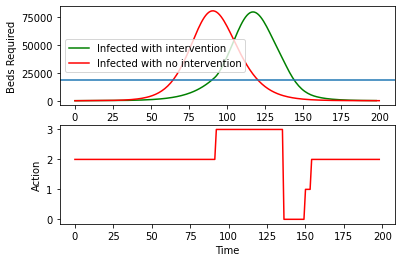

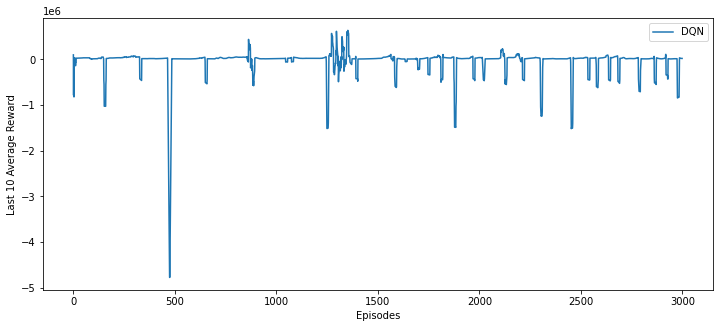

In [6]:
#limit on days.. budget 1500 =, no   -ve when capacity exceeded
dqn_model = run_algos_plot(30000,episodes=3000)
import pickle
filename = 'economic_days_limit_capacity_100_new_budget_1500_no_tot.sav'
pickle.dump(dqn_model, open(filename, 'wb'))

action dim== 4
diff= 84.0  total= 1416.0
1 1190.4761904761904
episode: 1, total reward: 50047.61904761904
diff= -86.0  total= 1586.0
2 -860000.0
episode: 2, total reward: -860000.0
diff= -404.0  total= 1904.0
2 -4040000.0
episode: 3, total reward: -4040000.0
diff= -462.0  total= 1962.0
2 -4620000.0
episode: 4, total reward: -4620000.0
diff= 40.0  total= 1460.0
1 2500.0
episode: 5, total reward: 198000.0
diff= -466.0  total= 1966.0
2 -4660000.0
episode: 6, total reward: -4660000.0
diff= 114.0  total= 1386.0
1 877.1929824561403
episode: 7, total reward: 33719.29824561403
diff= -90.0  total= 1590.0
2 -900000.0
episode: 8, total reward: -900000.0
diff= -436.0  total= 1936.0
2 -4360000.0
episode: 9, total reward: -4360000.0
diff= 246.0  total= 1254.0
1 406.50406504065046
episode: 10, total reward: -6349.593495934954
diff= -78.0  total= 1578.0
2 -780000.0
episode: 11, total reward: -780000.0
diff= 324.0  total= 1176.0
1 308.641975308642
episode: 12, total reward: -28135.802469135804
diff= 29

diff= 412.0  total= 1088.0
1 242.71844660194174
episode: 92, total reward: -33728.15533980583
diff= 546.0  total= 954.0
1 183.15018315018315
episode: 93, total reward: -37684.981684981685
diff= 344.0  total= 1156.0
1 290.69767441860466
episode: 94, total reward: -33930.232558139534
diff= 386.0  total= 1114.0
1 259.0673575129534
episode: 95, total reward: -36093.26424870466
diff= 684.0  total= 816.0
1 146.19883040935673
episode: 96, total reward: -38380.116959064326
diff= 692.0  total= 808.0
1 144.50867052023122
episode: 97, total reward: -40549.132947976876
diff= 484.0  total= 1016.0
1 206.61157024793388
episode: 98, total reward: -28338.84297520661
diff= 306.0  total= 1194.0
1 326.79738562091507
episode: 99, total reward: -28320.261437908495
diff= 334.0  total= 1166.0
1 299.4011976047904
episode: 100, total reward: -35059.88023952096
diff= 298.0  total= 1202.0
1 335.5704697986577
episode: 101, total reward: -27442.953020134228
diff= 454.0  total= 1046.0
1 220.26431718061676
episode: 1

diff= 318.0  total= 1182.0
1 314.4654088050315
episode: 182, total reward: -33553.45911949685
diff= 316.0  total= 1184.0
1 316.4556962025316
episode: 183, total reward: -30354.430379746835
diff= 318.0  total= 1182.0
1 314.4654088050315
episode: 184, total reward: -31553.459119496853
diff= 418.0  total= 1082.0
1 239.23444976076553
episode: 185, total reward: -35076.55502392344
diff= 496.0  total= 1004.0
1 201.61290322580643
episode: 186, total reward: -33838.709677419356
diff= 398.0  total= 1102.0
1 251.25628140703517
episode: 187, total reward: -37874.37185929649
diff= 496.0  total= 1004.0
1 201.61290322580643
episode: 188, total reward: -33838.709677419356
diff= 278.0  total= 1222.0
1 359.71223021582733
episode: 189, total reward: -25028.776978417263
diff= 400.0  total= 1100.0
1 250.0
episode: 190, total reward: -37000.0
diff= 492.0  total= 1008.0
1 203.25203252032523
episode: 191, total reward: -32674.796747967477
diff= 306.0  total= 1194.0
1 326.79738562091507
episode: 192, total re

diff= 302.0  total= 1198.0
1 331.12582781456956
episode: 272, total reward: -27887.417218543043
diff= 302.0  total= 1198.0
1 331.12582781456956
episode: 273, total reward: -26887.417218543043
diff= 296.0  total= 1204.0
1 337.83783783783787
episode: 274, total reward: -27216.216216216213
diff= 298.0  total= 1202.0
1 335.5704697986577
episode: 275, total reward: -29442.953020134228
diff= 296.0  total= 1204.0
1 337.83783783783787
episode: 276, total reward: -28216.216216216213
diff= 306.0  total= 1194.0
1 326.79738562091507
episode: 277, total reward: -28320.261437908495
diff= 300.0  total= 1200.0
1 333.33333333333337
episode: 278, total reward: -27666.666666666664
diff= 296.0  total= 1204.0
1 337.83783783783787
episode: 279, total reward: -27216.216216216213
diff= 308.0  total= 1192.0
1 324.6753246753247
episode: 280, total reward: -28532.46753246753
diff= 300.0  total= 1200.0
1 333.33333333333337
episode: 281, total reward: -27666.666666666664
diff= 292.0  total= 1208.0
1 342.4657534246

diff= 304.0  total= 1196.0
1 328.9473684210526
episode: 360, total reward: -28105.26315789474
diff= 306.0  total= 1194.0
1 326.79738562091507
episode: 361, total reward: -28320.261437908495
diff= 300.0  total= 1200.0
1 333.33333333333337
episode: 362, total reward: -27666.666666666664
diff= 298.0  total= 1202.0
1 335.5704697986577
episode: 363, total reward: -27442.953020134228
diff= 302.0  total= 1198.0
1 331.12582781456956
episode: 364, total reward: -27887.417218543043
diff= 302.0  total= 1198.0
1 331.12582781456956
episode: 365, total reward: -27887.417218543043
diff= 368.0  total= 1132.0
1 271.7391304347826
episode: 366, total reward: -33826.08695652174
diff= 394.0  total= 1106.0
1 253.80710659898475
episode: 367, total reward: -24619.289340101524
diff= 308.0  total= 1192.0
1 324.6753246753247
episode: 368, total reward: -29532.46753246753
diff= 304.0  total= 1196.0
1 328.9473684210526
episode: 369, total reward: -28105.26315789474
diff= 390.0  total= 1110.0
1 256.4102564102564
ep

diff= 322.0  total= 1178.0
1 310.5590062111801
episode: 449, total reward: -32944.09937888199
diff= 392.0  total= 1108.0
1 255.1020408163265
episode: 450, total reward: -35489.79591836735
diff= 676.0  total= 824.0
1 147.92899408284023
episode: 451, total reward: -41207.10059171598
diff= 598.0  total= 902.0
1 167.22408026755852
episode: 452, total reward: -36277.59197324415
diff= 562.0  total= 938.0
1 177.9359430604982
episode: 453, total reward: -35206.405693950175
diff= 622.0  total= 878.0
1 160.77170418006432
episode: 454, total reward: -38922.829581993574
diff= 594.0  total= 906.0
1 168.35016835016833
episode: 455, total reward: -37164.98316498316
diff= 588.0  total= 912.0
1 170.06802721088434
episode: 456, total reward: -34993.19727891157
diff= 606.0  total= 894.0
1 165.01650165016503
episode: 457, total reward: -37498.3498349835
diff= 624.0  total= 876.0
1 160.25641025641025
episode: 458, total reward: -39974.35897435898
diff= 610.0  total= 890.0
1 163.9344262295082
episode: 459, 

diff= 584.0  total= 916.0
1 171.23287671232876
episode: 538, total reward: -35876.71232876713
diff= 586.0  total= 914.0
1 170.64846416382252
episode: 539, total reward: -36935.15358361775
diff= 406.0  total= 1094.0
1 246.30541871921181
episode: 540, total reward: -29369.45812807882
diff= 456.0  total= 1044.0
1 219.29824561403507
episode: 541, total reward: -42070.17543859649
diff= 416.0  total= 1084.0
1 240.3846153846154
episode: 542, total reward: -28961.53846153846
diff= 390.0  total= 1110.0
1 256.4102564102564
episode: 543, total reward: -35358.97435897436
diff= 402.0  total= 1098.0
1 248.75621890547262
episode: 544, total reward: -27124.378109452737
diff= 306.0  total= 1194.0
1 326.79738562091507
episode: 545, total reward: -28320.261437908495
diff= 182.0  total= 1318.0
1 549.4505494505495
episode: 546, total reward: -4054.9450549450485
diff= -92.0  total= 1592.0
2 -920000.0
episode: 547, total reward: -920000.0
diff= 440.0  total= 1060.0
1 227.27272727272725
episode: 548, total re

diff= 394.0  total= 1106.0
1 253.80710659898475
episode: 626, total reward: -26619.289340101524
diff= 308.0  total= 1192.0
1 324.6753246753247
episode: 627, total reward: -27532.46753246753
diff= 278.0  total= 1222.0
1 359.71223021582733
episode: 628, total reward: -25028.776978417263
diff= 308.0  total= 1192.0
1 324.6753246753247
episode: 629, total reward: -28532.46753246753
diff= 320.0  total= 1180.0
1 312.5
episode: 630, total reward: -34750.0
diff= 474.0  total= 1026.0
1 210.97046413502107
episode: 631, total reward: -42902.9535864979
diff= 502.0  total= 998.0
1 199.20318725099602
episode: 632, total reward: -35079.6812749004
diff= 298.0  total= 1202.0
1 335.5704697986577
episode: 633, total reward: -29442.953020134228
diff= 296.0  total= 1204.0
1 337.83783783783787
episode: 634, total reward: -30216.216216216213
diff= 56.0  total= 1444.0
1 1785.7142857142856
episode: 635, total reward: 130571.42857142855
diff= -470.0  total= 1970.0
2 -4700000.0
episode: 636, total reward: -470000

diff= 452.0  total= 1048.0
1 221.23893805309734
episode: 715, total reward: -42876.10619469026
diff= 404.0  total= 1096.0
1 247.52475247524754
episode: 716, total reward: -27247.52475247525
diff= 292.0  total= 1208.0
1 342.4657534246575
episode: 717, total reward: -26753.424657534248
diff= 302.0  total= 1198.0
1 331.12582781456956
episode: 718, total reward: -26887.417218543043
diff= 292.0  total= 1208.0
1 342.4657534246575
episode: 719, total reward: -26753.424657534248
diff= 298.0  total= 1202.0
1 335.5704697986577
episode: 720, total reward: -27442.953020134228
diff= 304.0  total= 1196.0
1 328.9473684210526
episode: 721, total reward: -28105.26315789474
diff= 304.0  total= 1196.0
1 328.9473684210526
episode: 722, total reward: -28105.26315789474
diff= 292.0  total= 1208.0
1 342.4657534246575
episode: 723, total reward: -28753.424657534248
diff= 304.0  total= 1196.0
1 328.9473684210526
episode: 724, total reward: -28105.26315789474
diff= 302.0  total= 1198.0
1 331.12582781456956
epis

diff= 460.0  total= 1040.0
1 217.3913043478261
episode: 803, total reward: -43260.86956521739
diff= 480.0  total= 1020.0
1 208.33333333333334
episode: 804, total reward: -30166.666666666668
diff= 304.0  total= 1196.0
1 328.9473684210526
episode: 805, total reward: -29105.26315789474
diff= 370.0  total= 1130.0
1 270.27027027027026
episode: 806, total reward: -35972.97297297297
diff= 416.0  total= 1084.0
1 240.3846153846154
episode: 807, total reward: -27961.53846153846
diff= 300.0  total= 1200.0
1 333.33333333333337
episode: 808, total reward: -27666.666666666664
diff= 298.0  total= 1202.0
1 335.5704697986577
episode: 809, total reward: -26442.953020134228
diff= 372.0  total= 1128.0
1 268.81720430107526
episode: 810, total reward: -35118.279569892475
diff= 72.0  total= 1428.0
1 1388.888888888889
episode: 811, total reward: 91888.88888888888
diff= -486.0  total= 1986.0
2 -4860000.0
episode: 812, total reward: -4860000.0
diff= -490  total= 1990
2 -4900000
episode: 813, total reward: -4900

diff= 332.0  total= 1168.0
1 301.20481927710847
episode: 892, total reward: -33879.51807228915
diff= 334.0  total= 1166.0
1 299.4011976047904
episode: 893, total reward: -36059.88023952096
diff= 314.0  total= 1186.0
1 318.47133757961785
episode: 894, total reward: -30152.866242038213
diff= 308.0  total= 1192.0
1 324.6753246753247
episode: 895, total reward: -28532.46753246753
diff= 390.0  total= 1110.0
1 256.4102564102564
episode: 896, total reward: -36358.97435897436
diff= 392.0  total= 1108.0
1 255.1020408163265
episode: 897, total reward: -27489.79591836735
diff= 302.0  total= 1198.0
1 331.12582781456956
episode: 898, total reward: -25887.417218543043
diff= 456.0  total= 1044.0
1 219.29824561403507
episode: 899, total reward: -42070.17543859649
diff= 362.0  total= 1138.0
1 276.2430939226519
episode: 900, total reward: -23375.690607734807
diff= 254.0  total= 1246.0
1 393.7007874015748
episode: 901, total reward: -22629.921259842522
diff= -84.0  total= 1584.0
2 -840000.0
episode: 902,

diff= -86.0  total= 1586.0
2 -860000.0
episode: 981, total reward: -860000.0
diff= 432.0  total= 1068.0
1 231.48148148148147
episode: 982, total reward: -31851.851851851854
diff= 292.0  total= 1208.0
1 342.4657534246575
episode: 983, total reward: -28753.424657534248
diff= 306.0  total= 1194.0
1 326.79738562091507
episode: 984, total reward: -29320.261437908495
diff= 298.0  total= 1202.0
1 335.5704697986577
episode: 985, total reward: -28442.953020134228
diff= 302.0  total= 1198.0
1 331.12582781456956
episode: 986, total reward: -28887.417218543043
diff= 306.0  total= 1194.0
1 326.79738562091507
episode: 987, total reward: -28320.261437908495
diff= 452.0  total= 1048.0
1 221.23893805309734
episode: 988, total reward: -43876.10619469026
diff= 490.0  total= 1010.0
1 204.08163265306123
episode: 989, total reward: -33591.836734693876
diff= 310.0  total= 1190.0
1 322.5806451612903
episode: 990, total reward: -28741.935483870966
diff= 292.0  total= 1208.0
1 342.4657534246575
episode: 991, to

diff= 306.0  total= 1194.0
1 326.79738562091507
episode: 1069, total reward: -29320.261437908495
diff= 452.0  total= 1048.0
1 221.23893805309734
episode: 1070, total reward: -41876.10619469026
diff= 394.0  total= 1106.0
1 253.80710659898475
episode: 1071, total reward: -27619.289340101524
diff= 376.0  total= 1124.0
1 265.9574468085106
episode: 1072, total reward: -35404.255319148935
diff= 168.0  total= 1332.0
1 595.2380952380952
episode: 1073, total reward: 12523.80952380952
diff= -94.0  total= 1594.0
2 -940000.0
episode: 1074, total reward: -940000.0
diff= 112.0  total= 1388.0
1 892.8571428571428
episode: 1075, total reward: 36285.714285714275
diff= -88.0  total= 1588.0
2 -880000.0
episode: 1076, total reward: -880000.0
diff= -56.0  total= 1556.0
2 -560000.0
episode: 1077, total reward: -596000.0
diff= 268.0  total= 1232.0
1 373.13432835820896
episode: 1078, total reward: -24686.567164179105
diff= 304.0  total= 1196.0
1 328.9473684210526
episode: 1079, total reward: -29105.26315789474

diff= 320.0  total= 1180.0
1 312.5
episode: 1157, total reward: -33750.0
diff= 308.0  total= 1192.0
1 324.6753246753247
episode: 1158, total reward: -28532.46753246753
diff= 472.0  total= 1028.0
1 211.864406779661
episode: 1159, total reward: -42813.5593220339
diff= 492.0  total= 1008.0
1 203.25203252032523
episode: 1160, total reward: -33674.79674796748
diff= 306.0  total= 1194.0
1 326.79738562091507
episode: 1161, total reward: -28320.261437908495
diff= 296.0  total= 1204.0
1 337.83783783783787
episode: 1162, total reward: -27216.216216216213
diff= 300.0  total= 1200.0
1 333.33333333333337
episode: 1163, total reward: -27666.666666666664
diff= 298.0  total= 1202.0
1 335.5704697986577
episode: 1164, total reward: -29442.953020134228
diff= 310.0  total= 1190.0
1 322.5806451612903
episode: 1165, total reward: -27741.935483870966
diff= 360.0  total= 1140.0
1 277.77777777777777
episode: 1166, total reward: -33222.22222222222
diff= 500.0  total= 1000.0
1 200.0
episode: 1167, total reward: 

diff= 474.0  total= 1026.0
1 210.97046413502107
episode: 1246, total reward: -40902.9535864979
diff= 594.0  total= 906.0
1 168.35016835016833
episode: 1247, total reward: -33164.98316498316
diff= 480.0  total= 1020.0
1 208.33333333333334
episode: 1248, total reward: -33166.66666666667
diff= 476.0  total= 1024.0
1 210.08403361344537
episode: 1249, total reward: -40991.596638655465
diff= 412.0  total= 1088.0
1 242.71844660194174
episode: 1250, total reward: -26728.155339805828
diff= 476.0  total= 1024.0
1 210.08403361344537
episode: 1251, total reward: -42991.596638655465
diff= 460.0  total= 1040.0
1 217.3913043478261
episode: 1252, total reward: -32260.869565217392
diff= 356.0  total= 1144.0
1 280.8988764044944
episode: 1253, total reward: -37910.11235955056
diff= 326.0  total= 1174.0
1 306.7484662576687
episode: 1254, total reward: -35325.15337423312
diff= 310.0  total= 1190.0
1 322.5806451612903
episode: 1255, total reward: -27741.935483870966
diff= 410.0  total= 1090.0
1 243.90243902

diff= -84.0  total= 1584.0
2 -840000.0
episode: 1334, total reward: -840000.0
diff= -76.0  total= 1576.0
2 -760000.0
episode: 1335, total reward: -799000.0
diff= 290.0  total= 1210.0
1 344.82758620689657
episode: 1336, total reward: -26517.241379310348
diff= 302.0  total= 1198.0
1 331.12582781456956
episode: 1337, total reward: -27887.417218543043
diff= 298.0  total= 1202.0
1 335.5704697986577
episode: 1338, total reward: -29442.953020134228
diff= 306.0  total= 1194.0
1 326.79738562091507
episode: 1339, total reward: -29320.261437908495
diff= 308.0  total= 1192.0
1 324.6753246753247
episode: 1340, total reward: -28532.46753246753
diff= 474.0  total= 1026.0
1 210.97046413502107
episode: 1341, total reward: -39902.9535864979
diff= 474.0  total= 1026.0
1 210.97046413502107
episode: 1342, total reward: -32902.9535864979
diff= 300.0  total= 1200.0
1 333.33333333333337
episode: 1343, total reward: -29666.666666666664
diff= 302.0  total= 1198.0
1 331.12582781456956
episode: 1344, total reward

diff= 482.0  total= 1018.0
1 207.4688796680498
episode: 1422, total reward: -33253.11203319502
diff= 388.0  total= 1112.0
1 257.7319587628866
episode: 1423, total reward: -35226.804123711336
diff= 684.0  total= 816.0
1 146.19883040935673
episode: 1424, total reward: -41380.116959064326
diff= 648.0  total= 852.0
1 154.320987654321
episode: 1425, total reward: -37567.9012345679
diff= 586.0  total= 914.0
1 170.64846416382252
episode: 1426, total reward: -34935.15358361775
diff= 698.0  total= 802.0
1 143.26647564469914
episode: 1427, total reward: -41673.35243553009
diff= 236.0  total= 1264.0
1 423.728813559322
episode: 1428, total reward: -6627.118644067799
diff= -90.0  total= 1590.0
2 -900000.0
episode: 1429, total reward: -900000.0
diff= -86.0  total= 1586.0
2 -860000.0
episode: 1430, total reward: -860000.0
diff= -8.0  total= 1508.0
2 -80000.0
episode: 1431, total reward: -127000.0
diff= -486.0  total= 1986.0
2 -4860000.0
episode: 1432, total reward: -4860000.0
diff= 452.0  total= 1048

diff= -96.0  total= 1596.0
2 -960000.0
episode: 1510, total reward: -960000.0
diff= 320.0  total= 1180.0
1 312.5
episode: 1511, total reward: -29750.0
diff= 304.0  total= 1196.0
1 328.9473684210526
episode: 1512, total reward: -28105.26315789474
diff= 296.0  total= 1204.0
1 337.83783783783787
episode: 1513, total reward: -28216.216216216213
diff= 402.0  total= 1098.0
1 248.75621890547262
episode: 1514, total reward: -35124.37810945274
diff= 702.0  total= 798.0
1 142.45014245014247
episode: 1515, total reward: -41754.985754985755
diff= 472.0  total= 1028.0
1 211.864406779661
episode: 1516, total reward: -30813.5593220339
diff= 98.0  total= 1402.0
1 1020.408163265306
episode: 1517, total reward: 42040.81632653061
diff= -474.0  total= 1974.0
2 -4740000.0
episode: 1518, total reward: -4740000.0
diff= -8.0  total= 1508.0
2 -80000.0
episode: 1519, total reward: -129000.0
diff= -482.0  total= 1982.0
2 -4820000.0
episode: 1520, total reward: -4820000.0
diff= 450.0  total= 1050.0
1 222.22222222

diff= 704.0  total= 796.0
1 142.04545454545456
episode: 1599, total reward: -41795.454545454544
diff= 684.0  total= 816.0
1 146.19883040935673
episode: 1600, total reward: -41380.116959064326
diff= 488.0  total= 1012.0
1 204.91803278688525
episode: 1601, total reward: -33508.19672131147
diff= 328.0  total= 1172.0
1 304.8780487804878
episode: 1602, total reward: -32512.19512195122
diff= 204.0  total= 1296.0
1 490.19607843137254
episode: 1603, total reward: -11980.392156862748
diff= -92.0  total= 1592.0
2 -920000.0
episode: 1604, total reward: -920000.0
diff= 436.0  total= 1064.0
1 229.35779816513764
episode: 1605, total reward: -30064.22018348624
diff= 300.0  total= 1200.0
1 333.33333333333337
episode: 1606, total reward: -24666.666666666664
diff= 378.0  total= 1122.0
1 264.55026455026456
episode: 1607, total reward: -35544.973544973545
diff= 682.0  total= 818.0
1 146.6275659824047
episode: 1608, total reward: -39337.24340175953
diff= 700.0  total= 800.0
1 142.85714285714286
episode: 16

diff= 394.0  total= 1106.0
1 253.80710659898475
episode: 1687, total reward: -35619.289340101524
diff= 694.0  total= 806.0
1 144.0922190201729
episode: 1688, total reward: -41590.77809798271
diff= 698.0  total= 802.0
1 143.26647564469914
episode: 1689, total reward: -41673.35243553009
diff= 686.0  total= 814.0
1 145.7725947521866
episode: 1690, total reward: -39422.740524781344
diff= 454.0  total= 1046.0
1 220.26431718061676
episode: 1691, total reward: -30973.568281938326
diff= 118.0  total= 1382.0
1 847.457627118644
episode: 1692, total reward: 23745.7627118644
diff= -486.0  total= 1986.0
2 -4860000.0
episode: 1693, total reward: -4860000.0
diff= 414.0  total= 1086.0
1 241.54589371980674
episode: 1694, total reward: -28845.410628019326
diff= 202.0  total= 1298.0
1 495.0495049504951
episode: 1695, total reward: -12495.049504950497
diff= -82.0  total= 1582.0
2 -820000.0
episode: 1696, total reward: -820000.0
diff= 442.0  total= 1058.0
1 226.24434389140274
episode: 1697, total reward: -

diff= -48.0  total= 1548.0
2 -480000.0
episode: 1776, total reward: -519000.0
diff= -104.0  total= 1604.0
2 -1040000.0
episode: 1777, total reward: -1040000.0
diff= 292.0  total= 1208.0
1 342.4657534246575
episode: 1778, total reward: -26753.424657534248
diff= 292.0  total= 1208.0
1 342.4657534246575
episode: 1779, total reward: -26753.424657534248
diff= 292.0  total= 1208.0
1 342.4657534246575
episode: 1780, total reward: -26753.424657534248
diff= 358.0  total= 1142.0
1 279.3296089385475
episode: 1781, total reward: -37067.039106145254
diff= 394.0  total= 1106.0
1 253.80710659898475
episode: 1782, total reward: -35619.289340101524
diff= 702.0  total= 798.0
1 142.45014245014247
episode: 1783, total reward: -41754.985754985755
diff= 482.0  total= 1018.0
1 207.4688796680498
episode: 1784, total reward: -31253.112033195022
diff= 400.0  total= 1100.0
1 250.0
episode: 1785, total reward: -37000.0
diff= 480.0  total= 1020.0
1 208.33333333333334
episode: 1786, total reward: -33166.66666666667

diff= 304.0  total= 1196.0
1 328.9473684210526
episode: 1864, total reward: -27105.26315789474
diff= 348.0  total= 1152.0
1 287.35632183908046
episode: 1865, total reward: -38264.36781609195
diff= 460.0  total= 1040.0
1 217.3913043478261
episode: 1866, total reward: -39260.86956521739
diff= 68.0  total= 1432.0
1 1470.5882352941176
episode: 1867, total reward: 102058.82352941178
diff= -470.0  total= 1970.0
2 -4700000.0
episode: 1868, total reward: -4700000.0
diff= -14.0  total= 1514.0
2 -140000.0
episode: 1869, total reward: -180000.0
diff= -478.0  total= 1978.0
2 -4780000.0
episode: 1870, total reward: -4780000.0
diff= 206.0  total= 1294.0
1 485.43689320388347
episode: 1871, total reward: -2456.3106796116554
diff= -84.0  total= 1584.0
2 -840000.0
episode: 1872, total reward: -848000.0
diff= 278.0  total= 1222.0
1 359.71223021582733
episode: 1873, total reward: -26028.776978417263
diff= 296.0  total= 1204.0
1 337.83783783783787
episode: 1874, total reward: -27216.216216216213
diff= 292.

diff= 298.0  total= 1202.0
1 335.5704697986577
episode: 1951, total reward: -27442.953020134228
diff= 42.0  total= 1458.0
1 2380.9523809523807
episode: 1952, total reward: 191095.23809523808
diff= -472.0  total= 1972.0
2 -4720000.0
episode: 1953, total reward: -4720000.0
diff= -450.0  total= 1950.0
2 -4500000.0
episode: 1954, total reward: -4500000.0
diff= -86.0  total= 1586.0
2 -860000.0
episode: 1955, total reward: -860000.0
diff= 310.0  total= 1190.0
1 322.5806451612903
episode: 1956, total reward: -26741.935483870966
diff= 302.0  total= 1198.0
1 331.12582781456956
episode: 1957, total reward: -28887.417218543043
diff= 394.0  total= 1106.0
1 253.80710659898475
episode: 1958, total reward: -37619.289340101524
diff= 398.0  total= 1102.0
1 251.25628140703517
episode: 1959, total reward: -26874.371859296483
diff= 300.0  total= 1200.0
1 333.33333333333337
episode: 1960, total reward: -28666.666666666664
diff= 392.0  total= 1108.0
1 255.1020408163265
episode: 1961, total reward: -33489.79

diff= 300.0  total= 1200.0
1 333.33333333333337
episode: 2039, total reward: -28666.666666666664
diff= 296.0  total= 1204.0
1 337.83783783783787
episode: 2040, total reward: -28216.216216216213
diff= 302.0  total= 1198.0
1 331.12582781456956
episode: 2041, total reward: -29887.417218543043
diff= 300.0  total= 1200.0
1 333.33333333333337
episode: 2042, total reward: -28666.666666666664
diff= 306.0  total= 1194.0
1 326.79738562091507
episode: 2043, total reward: -28320.261437908495
diff= 298.0  total= 1202.0
1 335.5704697986577
episode: 2044, total reward: -28442.953020134228
diff= 302.0  total= 1198.0
1 331.12582781456956
episode: 2045, total reward: -29887.417218543043
diff= 398.0  total= 1102.0
1 251.25628140703517
episode: 2046, total reward: -35874.37185929649
diff= 484.0  total= 1016.0
1 206.61157024793388
episode: 2047, total reward: -33338.842975206615
diff= 302.0  total= 1198.0
1 331.12582781456956
episode: 2048, total reward: -28887.417218543043
diff= 302.0  total= 1198.0
1 331

diff= 334.0  total= 1166.0
1 299.4011976047904
episode: 2127, total reward: -32059.880239520957
diff= 326.0  total= 1174.0
1 306.7484662576687
episode: 2128, total reward: -30325.153374233127
diff= 326.0  total= 1174.0
1 306.7484662576687
episode: 2129, total reward: -33325.15337423312
diff= 294.0  total= 1206.0
1 340.1360544217687
episode: 2130, total reward: -27986.39455782313
diff= 298.0  total= 1202.0
1 335.5704697986577
episode: 2131, total reward: -28442.953020134228
diff= 304.0  total= 1196.0
1 328.9473684210526
episode: 2132, total reward: -28105.26315789474
diff= 296.0  total= 1204.0
1 337.83783783783787
episode: 2133, total reward: -28216.216216216213
diff= 296.0  total= 1204.0
1 337.83783783783787
episode: 2134, total reward: -27216.216216216213
diff= 318.0  total= 1182.0
1 314.4654088050315
episode: 2135, total reward: -30553.459119496853
diff= 332.0  total= 1168.0
1 301.20481927710847
episode: 2136, total reward: -30879.518072289156
diff= 310.0  total= 1190.0
1 322.5806451

diff= -484.0  total= 1984.0
2 -4840000.0
episode: 2215, total reward: -4840000.0
diff= 472.0  total= 1028.0
1 211.864406779661
episode: 2216, total reward: -42813.5593220339
diff= 688.0  total= 812.0
1 145.34883720930233
episode: 2217, total reward: -41465.11627906977
diff= 688.0  total= 812.0
1 145.34883720930233
episode: 2218, total reward: -41465.11627906977
diff= 684.0  total= 816.0
1 146.19883040935673
episode: 2219, total reward: -38380.116959064326
diff= 694.0  total= 806.0
1 144.0922190201729
episode: 2220, total reward: -39590.77809798271
diff= 694.0  total= 806.0
1 144.0922190201729
episode: 2221, total reward: -40590.77809798271
diff= 474.0  total= 1026.0
1 210.97046413502107
episode: 2222, total reward: -31902.953586497893
diff= 462.0  total= 1038.0
1 216.45021645021646
episode: 2223, total reward: -43354.97835497835
diff= 694.0  total= 806.0
1 144.0922190201729
episode: 2224, total reward: -39590.77809798271
diff= 476.0  total= 1024.0
1 210.08403361344537
episode: 2225, to

diff= 290.0  total= 1210.0
1 344.82758620689657
episode: 2304, total reward: -28517.241379310348
diff= 298.0  total= 1202.0
1 335.5704697986577
episode: 2305, total reward: -28442.953020134228
diff= 296.0  total= 1204.0
1 337.83783783783787
episode: 2306, total reward: -28216.216216216213
diff= 304.0  total= 1196.0
1 328.9473684210526
episode: 2307, total reward: -28105.26315789474
diff= 296.0  total= 1204.0
1 337.83783783783787
episode: 2308, total reward: -27216.216216216213
diff= 296.0  total= 1204.0
1 337.83783783783787
episode: 2309, total reward: -28216.216216216213
diff= 312.0  total= 1188.0
1 320.5128205128205
episode: 2310, total reward: -25948.71794871795
diff= 308.0  total= 1192.0
1 324.6753246753247
episode: 2311, total reward: -28532.46753246753
diff= 312.0  total= 1188.0
1 320.5128205128205
episode: 2312, total reward: -28948.71794871795
diff= 306.0  total= 1194.0
1 326.79738562091507
episode: 2313, total reward: -28320.261437908495
diff= 304.0  total= 1196.0
1 328.947368

diff= 488.0  total= 1012.0
1 204.91803278688525
episode: 2391, total reward: -33508.19672131147
diff= 324.0  total= 1176.0
1 308.641975308642
episode: 2392, total reward: -34135.8024691358
diff= 228.0  total= 1272.0
1 438.59649122807014
episode: 2393, total reward: -19140.350877192985
diff= -86.0  total= 1586.0
2 -860000.0
episode: 2394, total reward: -860000.0
diff= 6.0  total= 1494.0
1 16666.666666666664
episode: 2395, total reward: 1617666.6666666665
diff= -480.0  total= 1980.0
2 -4800000.0
episode: 2396, total reward: -4800000.0
diff= -480.0  total= 1980.0
2 -4800000.0
episode: 2397, total reward: -4800000.0
diff= 432.0  total= 1068.0
1 231.48148148148147
episode: 2398, total reward: -29851.851851851854
diff= 410.0  total= 1090.0
1 243.90243902439025
episode: 2399, total reward: -36609.756097560974
diff= 700.0  total= 800.0
1 142.85714285714286
episode: 2400, total reward: -41714.28571428571
diff= 704.0  total= 796.0
1 142.04545454545456
episode: 2401, total reward: -41795.45454545

diff= 700.0  total= 800.0
1 142.85714285714286
episode: 2480, total reward: -41714.28571428571
diff= 444.0  total= 1056.0
1 225.22522522522522
episode: 2481, total reward: -26477.477477477478
diff= 300.0  total= 1200.0
1 333.33333333333337
episode: 2482, total reward: -27666.666666666664
diff= 304.0  total= 1196.0
1 328.9473684210526
episode: 2483, total reward: -28105.26315789474
diff= 392.0  total= 1108.0
1 255.1020408163265
episode: 2484, total reward: -35489.79591836735
diff= 700.0  total= 800.0
1 142.85714285714286
episode: 2485, total reward: -38714.28571428571
diff= 690.0  total= 810.0
1 144.92753623188406
episode: 2486, total reward: -38507.24637681159
diff= 692.0  total= 808.0
1 144.50867052023122
episode: 2487, total reward: -39549.132947976876
diff= 480.0  total= 1020.0
1 208.33333333333334
episode: 2488, total reward: -31166.666666666668
diff= 324.0  total= 1176.0
1 308.641975308642
episode: 2489, total reward: -35135.8024691358
diff= 358.0  total= 1142.0
1 279.329608938547

diff= 692.0  total= 808.0
1 144.50867052023122
episode: 2568, total reward: -41549.132947976876
diff= 688.0  total= 812.0
1 145.34883720930233
episode: 2569, total reward: -39465.11627906977
diff= 702.0  total= 798.0
1 142.45014245014247
episode: 2570, total reward: -39754.985754985755
diff= 686.0  total= 814.0
1 145.7725947521866
episode: 2571, total reward: -40422.740524781344
diff= 462.0  total= 1038.0
1 216.45021645021646
episode: 2572, total reward: -31354.978354978353
diff= 344.0  total= 1156.0
1 290.69767441860466
episode: 2573, total reward: -38930.232558139534
diff= 208.0  total= 1292.0
1 480.7692307692308
episode: 2574, total reward: -12923.076923076922
diff= -88.0  total= 1588.0
2 -880000.0
episode: 2575, total reward: -880000.0
diff= -88.0  total= 1588.0
2 -880000.0
episode: 2576, total reward: -880000.0
diff= 174.0  total= 1326.0
1 574.7126436781609
episode: 2577, total reward: 9471.26436781609
diff= -90.0  total= 1590.0
2 -900000.0
episode: 2578, total reward: -900000.0
d

diff= 442.0  total= 1058.0
1 226.24434389140274
episode: 2657, total reward: -31375.565610859725
diff= 342.0  total= 1158.0
1 292.39766081871346
episode: 2658, total reward: -35760.23391812865
diff= 322.0  total= 1178.0
1 310.5590062111801
episode: 2659, total reward: -31944.09937888199
diff= 302.0  total= 1198.0
1 331.12582781456956
episode: 2660, total reward: -27887.417218543043
diff= 402.0  total= 1098.0
1 248.75621890547262
episode: 2661, total reward: -36124.37810945274
diff= 468.0  total= 1032.0
1 213.67521367521368
episode: 2662, total reward: -32632.47863247863
diff= 106.0  total= 1394.0
1 943.3962264150942
episode: 2663, total reward: 33339.62264150943
diff= -482.0  total= 1982.0
2 -4820000.0
episode: 2664, total reward: -4820000.0
diff= 420.0  total= 1080.0
1 238.09523809523813
episode: 2665, total reward: -30190.476190476187
diff= 318.0  total= 1182.0
1 314.4654088050315
episode: 2666, total reward: -33553.45911949685
diff= 376.0  total= 1124.0
1 265.9574468085106
episode: 

diff= 308.0  total= 1192.0
1 324.6753246753247
episode: 2744, total reward: -28532.46753246753
diff= 304.0  total= 1196.0
1 328.9473684210526
episode: 2745, total reward: -29105.26315789474
diff= 298.0  total= 1202.0
1 335.5704697986577
episode: 2746, total reward: -28442.953020134228
diff= 306.0  total= 1194.0
1 326.79738562091507
episode: 2747, total reward: -31320.261437908495
diff= 326.0  total= 1174.0
1 306.7484662576687
episode: 2748, total reward: -32325.153374233127
diff= 466.0  total= 1034.0
1 214.59227467811158
episode: 2749, total reward: -43540.77253218884
diff= 452.0  total= 1048.0
1 221.23893805309734
episode: 2750, total reward: -31876.106194690266
diff= 302.0  total= 1198.0
1 331.12582781456956
episode: 2751, total reward: -29887.417218543043
diff= 304.0  total= 1196.0
1 328.9473684210526
episode: 2752, total reward: -29105.26315789474
diff= 306.0  total= 1194.0
1 326.79738562091507
episode: 2753, total reward: -28320.261437908495
diff= 306.0  total= 1194.0
1 326.797385

diff= 304.0  total= 1196.0
1 328.9473684210526
episode: 2832, total reward: -29105.26315789474
diff= 296.0  total= 1204.0
1 337.83783783783787
episode: 2833, total reward: -28216.216216216213
diff= 304.0  total= 1196.0
1 328.9473684210526
episode: 2834, total reward: -28105.26315789474
diff= 328.0  total= 1172.0
1 304.8780487804878
episode: 2835, total reward: -32512.19512195122
diff= 326.0  total= 1174.0
1 306.7484662576687
episode: 2836, total reward: -30325.153374233127
diff= 298.0  total= 1202.0
1 335.5704697986577
episode: 2837, total reward: -28442.953020134228
diff= 318.0  total= 1182.0
1 314.4654088050315
episode: 2838, total reward: -31553.459119496853
diff= 198.0  total= 1302.0
1 505.0505050505051
episode: 2839, total reward: -10494.949494949491
diff= -84.0  total= 1584.0
2 -840000.0
episode: 2840, total reward: -840000.0
diff= 434.0  total= 1066.0
1 230.4147465437788
episode: 2841, total reward: -32958.52534562212
diff= 302.0  total= 1198.0
1 331.12582781456956
episode: 2842

diff= -50.0  total= 1550.0
2 -500000.0
episode: 2921, total reward: -542000.0
diff= -480.0  total= 1980.0
2 -4800000.0
episode: 2922, total reward: -4800000.0
diff= 298.0  total= 1202.0
1 335.5704697986577
episode: 2923, total reward: -28442.953020134228
diff= 312.0  total= 1188.0
1 320.5128205128205
episode: 2924, total reward: -28948.71794871795
diff= 306.0  total= 1194.0
1 326.79738562091507
episode: 2925, total reward: -29320.261437908495
diff= 300.0  total= 1200.0
1 333.33333333333337
episode: 2926, total reward: -29666.666666666664
diff= 298.0  total= 1202.0
1 335.5704697986577
episode: 2927, total reward: -25442.953020134228
diff= 310.0  total= 1190.0
1 322.5806451612903
episode: 2928, total reward: -26741.935483870966
diff= 306.0  total= 1194.0
1 326.79738562091507
episode: 2929, total reward: -28320.261437908495
diff= 306.0  total= 1194.0
1 326.79738562091507
episode: 2930, total reward: -28320.261437908495
diff= 304.0  total= 1196.0
1 328.9473684210526
episode: 2931, total re

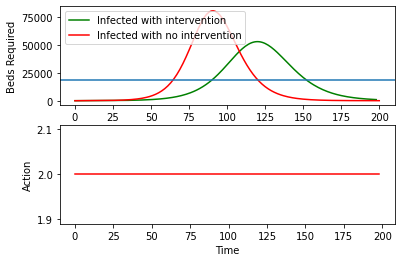

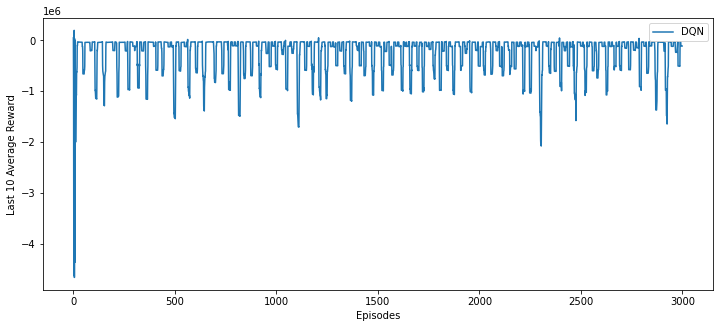

In [6]:
#limit on days.. budget 1500 =, no   -ve when capacity exceeded
dqn_model = run_algos_plot(30000,episodes=3000)
import pickle
filename = 'economic_days_limit_capacity_1000_new_budget_1500_no_tot.sav'
pickle.dump(dqn_model, open(filename, 'wb'))

action dim== 4
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
diff= 214.0  total= 1286.0
1 467.28971962616816
episode: 1, total reward: -67532.71028037384
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
c

diff= -478.0  total= 1978.0
2 -4780.0
episode: 80, total reward: -4780.0
diff= -476.0  total= 1976.0
2 -4760.0
episode: 81, total reward: -4760.0
diff= -478.0  total= 1978.0
2 -4780.0
episode: 82, total reward: -4780.0
diff= -468.0  total= 1968.0
2 -4680.0
episode: 83, total reward: -4680.0
diff= -484.0  total= 1984.0
2 -4840.0
episode: 84, total reward: -4840.0
diff= -488.0  total= 1988.0
2 -4880.0
episode: 85, total reward: -4880.0
diff= -470.0  total= 1970.0
2 -4700.0
episode: 86, total reward: -4700.0
diff= -478.0  total= 1978.0
2 -4780.0
episode: 87, total reward: -4780.0
diff= -484.0  total= 1984.0
2 -4840.0
episode: 88, total reward: -4840.0
diff= -474.0  total= 1974.0
2 -4740.0
episode: 89, total reward: -4740.0
diff= -486.0  total= 1986.0
2 -4860.0
episode: 90, total reward: -4860.0
diff= -478.0  total= 1978.0
2 -4780.0
episode: 91, total reward: -4780.0
diff= -474.0  total= 1974.0
2 -4740.0
episode: 92, total reward: -4740.0
diff= -478.0  total= 1978.0
2 -4780.0
episode: 93, 

capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
diff= 698.0  total= 802.0
1 143.26647564469914
episode: 166, total reward: -55856.7335243553
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacit

diff= 694.0  total= 806.0
1 144.0922190201729
episode: 227, total reward: -51855.907780979825
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
diff= 700.0  total= 800.0
1 142.85714285714286
episode: 228, total reward: -55857.142857142855
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
c

diff= -486.0  total= 1986.0
2 -4860.0
episode: 289, total reward: -4860.0
diff= -482.0  total= 1982.0
2 -4820.0
episode: 290, total reward: -4820.0
diff= -464.0  total= 1964.0
2 -4640.0
episode: 291, total reward: -4640.0
diff= -468.0  total= 1968.0
2 -4680.0
episode: 292, total reward: -4680.0
diff= -490  total= 1990
2 -4900
episode: 293, total reward: -4900
diff= -480.0  total= 1980.0
2 -4800.0
episode: 294, total reward: -4800.0
diff= -480.0  total= 1980.0
2 -4800.0
episode: 295, total reward: -4800.0
diff= -478.0  total= 1978.0
2 -4780.0
episode: 296, total reward: -4780.0
diff= -470.0  total= 1970.0
2 -4700.0
episode: 297, total reward: -4700.0
diff= -490  total= 1990
2 -4900
episode: 298, total reward: -4900
diff= -480.0  total= 1980.0
2 -4800.0
episode: 299, total reward: -4800.0
diff= -472.0  total= 1972.0
2 -4720.0
episode: 300, total reward: -4720.0
diff= -484.0  total= 1984.0
2 -4840.0
episode: 301, total reward: -4840.0
diff= -484.0  total= 1984.0
2 -4840.0
episode: 302, to

diff= -472.0  total= 1972.0
2 -4720.0
episode: 390, total reward: -4720.0
diff= -478.0  total= 1978.0
2 -4780.0
episode: 391, total reward: -4780.0
diff= -474.0  total= 1974.0
2 -4740.0
episode: 392, total reward: -4740.0
diff= -486.0  total= 1986.0
2 -4860.0
episode: 393, total reward: -4860.0
diff= -474.0  total= 1974.0
2 -4740.0
episode: 394, total reward: -4740.0
diff= -480.0  total= 1980.0
2 -4800.0
episode: 395, total reward: -4800.0
diff= -488.0  total= 1988.0
2 -4880.0
episode: 396, total reward: -4880.0
diff= -488.0  total= 1988.0
2 -4880.0
episode: 397, total reward: -4880.0
diff= -482.0  total= 1982.0
2 -4820.0
episode: 398, total reward: -4820.0
diff= -490  total= 1990
2 -4900
episode: 399, total reward: -4900
diff= -484.0  total= 1984.0
2 -4840.0
episode: 400, total reward: -4840.0
diff= -474.0  total= 1974.0
2 -4740.0
episode: 401, total reward: -4740.0
diff= -484.0  total= 1984.0
2 -4840.0
episode: 402, total reward: -4840.0
capacity
capacity
capacity
capacity
capacity
c

diff= 42.0  total= 1458.0
1 2380.9523809523807
episode: 442, total reward: 2380.9523809523807
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
diff= 46.0  total= 1454.0
1 2173.913043478261
episode: 443, total reward: -26826.08695652174
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
diff= 114.0 

capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
diff= 14.0  total= 1486.0
1 7142.857142857142
episode: 473, total reward: -37857.142857142855
diff= -476.0  total= 1976.0
2 -4760.0
episode: 474, total reward: -4760.0
diff= -484.0  total= 1984.0
2 -4840.0
episode: 475, total reward: -4840.0
diff= -484.0  total= 1984.0
2 -4840.0
episode: 476, total reward: -4840.0
diff= -488.0  total= 1988.0
2 -4880.0
episode: 477, total reward: -4880.0
diff= -474.0  total= 1974.0
2 -4740.0
episode: 478, total reward: -4740.0
diff= -476.0  total= 1976.0
2 -4760.0
episode: 479, total reward: -4760.0
diff= -474.0  total= 1974.0
2 -4740.0
episode: 480, total

diff= -488.0  total= 1988.0
2 -4880.0
episode: 564, total reward: -4880.0
diff= -476.0  total= 1976.0
2 -4760.0
episode: 565, total reward: -4760.0
diff= -456.0  total= 1956.0
2 -4560.0
episode: 566, total reward: -4560.0
diff= -478.0  total= 1978.0
2 -4780.0
episode: 567, total reward: -4780.0
diff= -482.0  total= 1982.0
2 -4820.0
episode: 568, total reward: -4820.0
diff= -466.0  total= 1966.0
2 -4660.0
episode: 569, total reward: -4660.0
diff= -478.0  total= 1978.0
2 -4780.0
episode: 570, total reward: -4780.0
diff= -488.0  total= 1988.0
2 -4880.0
episode: 571, total reward: -4880.0
diff= -484.0  total= 1984.0
2 -4840.0
episode: 572, total reward: -4840.0
diff= -486.0  total= 1986.0
2 -4860.0
episode: 573, total reward: -4860.0
diff= -486.0  total= 1986.0
2 -4860.0
episode: 574, total reward: -4860.0
diff= -470.0  total= 1970.0
2 -4700.0
episode: 575, total reward: -4700.0
diff= -474.0  total= 1974.0
2 -4740.0
episode: 576, total reward: -4740.0
diff= -488.0  total= 1988.0
2 -4880.0


diff= -480.0  total= 1980.0
2 -4800.0
episode: 654, total reward: -4800.0
diff= -486.0  total= 1986.0
2 -4860.0
episode: 655, total reward: -4860.0
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
diff= 76.0  total= 1424.0
1 1315.7894736842104
episode: 656, total reward: -49684.21052631579
diff= -92.0  total= 1592.0
2 -920.0
episode: 657, total reward: -920.0
diff= -90.0  total= 1590.0
2 -900.0
episode: 658, total reward: -900.0
capacity
capacity
capacity
capacity
capacity
diff= -84.0  total= 1584.0
2 -1840.0
episode: 659, total reward: -5840.0
diff= 36.0  total= 1464.0
1 2777.777777

capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
diff= 126.0  total= 1374.0
1 793.6507936507936
episode: 729, total reward: -51206.34920634921
diff= -96.0  total= 1596.0
2 -960.0
episode: 730, total reward: -960.0
diff= -84.0  total= 1584.0
2 -840.0
episode: 731, total reward: -840.0
diff= -20.0  total= 1520.0
2 -200.0
episode: 732, total reward: -200.0
diff= 16.0  total= 1484.0
1 6250.0
episode: 733, total reward: 6250.0
diff= -94.0  total= 1594.0
2 -940.0
episode: 734, total reward: -940.0
diff= 24.0  total= 1476.0
1 4166.666666666666
episode: 735, total reward: 4166.66666

diff= 8.0  total= 1492.0
1 12500.0
episode: 773, total reward: 12500.0
diff= 86.0  total= 1414.0
1 1162.7906976744187
episode: 774, total reward: 1162.7906976744187
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
diff= 94.0  total= 1406.0
1 1063.8297872340424
episode: 775, total reward: -52936.17021276596
diff= 4.0  total= 1496.0
1 25000.0
episode: 776, total reward: 25000.0
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capa

capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
diff= -80.0  total= 1580.0
2 -1800.0
episode: 852, total reward: -12800.0
diff= -2.0  total= 1502.0
2 -20.0
episode: 853, total reward: -20.0
diff= -112.0  total= 1612.0
2 -1120.0
episode: 854, total reward: -1120.0
diff= -2.0  total= 1502.0
2 -20.0
episode: 855, total reward: -20.0
diff= -136.0  total= 1636.0
2 -1360.0
episode: 856, total reward: -1360.0
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
dif

diff= -116.0  total= 1616.0
2 -1160.0
episode: 926, total reward: -1160.0
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
diff= 30.0  total= 1470.0
1 3333.3333333333335
episode: 927, total reward: -57666.666666666664
diff= 22.0  total= 1478.0
1 4545.454545454546
episode: 928, total reward: 4545.454545454546
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
c

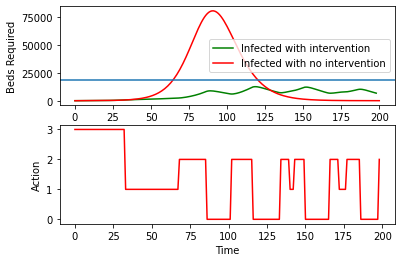

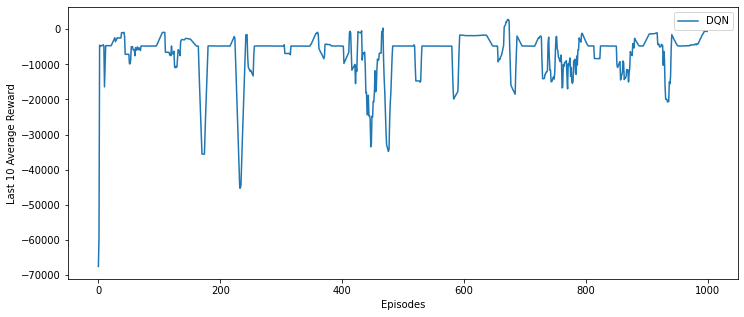

In [6]:
#limit on days.. budget 1500 =, no   -ve when capacity exceeded
dqn_model = run_algos_plot(30000,episodes=1000)
import pickle
filename = 'economic_days_limit_capacity_1000_new_budget_1500_red_rewards_no_tot.sav'
pickle.dump(dqn_model, open(filename, 'wb'))

action dim== 4
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
diff= 506.0  total= 1294.0
1 197.6284584980237
episode: 1, total reward: -64802.371541501976
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
c

diff= 1000.0  total= 800.0
1 100.0
episode: 62, total reward: -55900.0
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
diff= 982.0  total= 818.0
1 101.83299389002036
episode: 63, total reward: -53898.16700610998
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity

capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
diff= 524.0  total= 1276.0
1 190.83969465648855
episode: 100, total reward: -50809.16030534351
diff= 210.0  total= 1590.0
1 476.19047619047626
episode: 101, total reward: 476.19047619047626
diff= 204.0  total= 1596.0
1 490.19607843137254
episode: 102, total reward: 490.19607843137254
capacity
capacity
capacity
capacity
diff= 220.0  total= 1580.0
1 -545.4545454545455
episode: 103, total reward: -3545.4545454545455
diff= 212.0  total= 1588.0
1 471.6981132075471
episode: 104, total reward: 471.6981132075471
diff= -180.0  total= 1980.0
2 -1800.0
episode: 105, total reward: -1800.0
diff= 216.0  total= 1584.0
1 462.96296296296293
episode: 106, total reward: 462.962

diff= -176.0  total= 1976.0
2 -1760.0
episode: 154, total reward: -1760.0
diff= -178.0  total= 1978.0
2 -1780.0
episode: 155, total reward: -1780.0
diff= -184.0  total= 1984.0
2 -1840.0
episode: 156, total reward: -1840.0
diff= -166.0  total= 1966.0
2 -1660.0
episode: 157, total reward: -1660.0
diff= -186.0  total= 1986.0
2 -1860.0
episode: 158, total reward: -1860.0
diff= -186.0  total= 1986.0
2 -1860.0
episode: 159, total reward: -1860.0
diff= -158.0  total= 1958.0
2 -1580.0
episode: 160, total reward: -1580.0
diff= -190  total= 1990
2 -1900
episode: 161, total reward: -1900
diff= -184.0  total= 1984.0
2 -1840.0
episode: 162, total reward: -1840.0
diff= -180.0  total= 1980.0
2 -1800.0
episode: 163, total reward: -1800.0
diff= -180.0  total= 1980.0
2 -1800.0
episode: 164, total reward: -1800.0
diff= -180.0  total= 1980.0
2 -1800.0
episode: 165, total reward: -1800.0
diff= -190  total= 1990
2 -1900
episode: 166, total reward: -1900
diff= -170.0  total= 1970.0
2 -1700.0
episode: 167, to

diff= -182.0  total= 1982.0
2 -1820.0
episode: 261, total reward: -1820.0
diff= -178.0  total= 1978.0
2 -1780.0
episode: 262, total reward: -1780.0
diff= -180.0  total= 1980.0
2 -1800.0
episode: 263, total reward: -1800.0
diff= -184.0  total= 1984.0
2 -1840.0
episode: 264, total reward: -1840.0
diff= -174.0  total= 1974.0
2 -1740.0
episode: 265, total reward: -1740.0
diff= -132.0  total= 1932.0
2 -1320.0
episode: 266, total reward: -1320.0
diff= -164.0  total= 1964.0
2 -1640.0
episode: 267, total reward: -1640.0
diff= -160.0  total= 1960.0
2 -1600.0
episode: 268, total reward: -1600.0
diff= -110.0  total= 1910.0
2 -1100.0
episode: 269, total reward: -1100.0
diff= -170.0  total= 1970.0
2 -1700.0
episode: 270, total reward: -1700.0
diff= -178.0  total= 1978.0
2 -1780.0
episode: 271, total reward: -1780.0
diff= -180.0  total= 1980.0
2 -1800.0
episode: 272, total reward: -1800.0
diff= -22.0  total= 1822.0
2 -220.0
episode: 273, total reward: -220.0
diff= 72.0  total= 1728.0
1 1388.88888888

diff= 162.0  total= 1638.0
1 617.283950617284
episode: 339, total reward: 617.283950617284
diff= 208.0  total= 1592.0
1 480.7692307692308
episode: 340, total reward: 480.7692307692308
diff= 152.0  total= 1648.0
1 657.8947368421052
episode: 341, total reward: 657.8947368421052
diff= 214.0  total= 1586.0
1 467.28971962616816
episode: 342, total reward: 467.28971962616816
diff= 154.0  total= 1646.0
1 649.3506493506494
episode: 343, total reward: 649.3506493506494
diff= 222.0  total= 1578.0
1 450.45045045045043
episode: 344, total reward: 450.45045045045043
diff= 212.0  total= 1588.0
1 471.6981132075471
episode: 345, total reward: 471.6981132075471
diff= 208.0  total= 1592.0
1 480.7692307692308
episode: 346, total reward: 480.7692307692308
diff= 188.0  total= 1612.0
1 531.9148936170212
episode: 347, total reward: 531.9148936170212
diff= 176.0  total= 1624.0
1 568.1818181818182
episode: 348, total reward: 568.1818181818182
diff= 114.0  total= 1686.0
1 877.1929824561403
episode: 349, total r

diff= 174.0  total= 1626.0
1 574.7126436781609
episode: 428, total reward: 574.7126436781609
diff= 138.0  total= 1662.0
1 724.6376811594203
episode: 429, total reward: 724.6376811594203
diff= 174.0  total= 1626.0
1 574.7126436781609
episode: 430, total reward: 574.7126436781609
diff= 198.0  total= 1602.0
1 505.0505050505051
episode: 431, total reward: 505.0505050505051
diff= 182.0  total= 1618.0
1 549.4505494505495
episode: 432, total reward: 549.4505494505495
diff= 240.0  total= 1560.0
1 416.6666666666667
episode: 433, total reward: 416.6666666666667
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
diff= 270.0  total= 1530.0
1 370.3703703703704
episode: 434, total reward: -7629.62962962963
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacit

diff= 598.0  total= 1202.0
1 167.22408026755852
episode: 470, total reward: -60832.77591973244
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
diff= 604.0  total= 1196.0
1 165.56291390728478
episode: 471, total reward: -62834.437086092716
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity

diff= 82.0  total= 1718.0
1 1219.5121951219512
episode: 525, total reward: 1219.5121951219512
diff= 122.0  total= 1678.0
1 819.672131147541
episode: 526, total reward: 819.672131147541
diff= 128.0  total= 1672.0
1 781.25
episode: 527, total reward: 781.25
diff= 88.0  total= 1712.0
1 1136.3636363636365
episode: 528, total reward: 1136.3636363636365
diff= 106.0  total= 1694.0
1 943.3962264150942
episode: 529, total reward: 943.3962264150942
diff= 94.0  total= 1706.0
1 1063.8297872340424
episode: 530, total reward: 1063.8297872340424
diff= 104.0  total= 1696.0
1 961.5384615384615
episode: 531, total reward: 961.5384615384615
diff= 94.0  total= 1706.0
1 1063.8297872340424
episode: 532, total reward: 1063.8297872340424
diff= 82.0  total= 1718.0
1 1219.5121951219512
episode: 533, total reward: 1219.5121951219512
diff= 100.0  total= 1700.0
1 1000.0
episode: 534, total reward: 1000.0
diff= 52.0  total= 1748.0
1 1923.076923076923
episode: 535, total reward: 1923.076923076923
diff= 64.0  total= 

diff= 204.0  total= 1596.0
1 490.19607843137254
episode: 608, total reward: 490.19607843137254
diff= 212.0  total= 1588.0
1 471.6981132075471
episode: 609, total reward: 471.6981132075471
diff= -162.0  total= 1962.0
2 -1620.0
episode: 610, total reward: -1620.0
diff= 220.0  total= 1580.0
1 454.5454545454545
episode: 611, total reward: 454.5454545454545
diff= -172.0  total= 1972.0
2 -1720.0
episode: 612, total reward: -1720.0
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
diff= 214.0  total= 1586.0
1 -532.7102803738319
episode: 613, total reward: -12532.710280373833
diff= 210.0  total= 1590.0
1 476.19047619047626
episode: 614, total reward: 476.19047619047626
diff= -172.0  total= 1972.0
2 -1720.0
episode: 615, total reward: -1720.0
diff= 204.0  total= 1596.0
1 490.19607843137254
episode: 616, total reward: 490.19607843137254
diff= -170.0  total= 1970.0
2 -1700.0
episode: 617, total reward: -1700.0
diff= 204.0  total= 

diff= 54.0  total= 1746.0
1 1851.8518518518517
episode: 666, total reward: 1851.8518518518517
diff= 96.0  total= 1704.0
1 1041.6666666666665
episode: 667, total reward: 1041.6666666666665
diff= 64.0  total= 1736.0
1 1562.5
episode: 668, total reward: 1562.5
diff= 66.0  total= 1734.0
1 1515.1515151515152
episode: 669, total reward: 1515.1515151515152
diff= 64.0  total= 1736.0
1 1562.5
episode: 670, total reward: 1562.5
diff= 98.0  total= 1702.0
1 1020.408163265306
episode: 671, total reward: 1020.408163265306
diff= 88.0  total= 1712.0
1 1136.3636363636365
episode: 672, total reward: 1136.3636363636365
diff= 44.0  total= 1756.0
1 2272.727272727273
episode: 673, total reward: 2272.727272727273
diff= 82.0  total= 1718.0
1 1219.5121951219512
episode: 674, total reward: 1219.5121951219512
diff= 78.0  total= 1722.0
1 1282.051282051282
episode: 675, total reward: 1282.051282051282
diff= 44.0  total= 1756.0
1 2272.727272727273
episode: 676, total reward: 2272.727272727273
diff= 98.0  total= 170

capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
diff= 1004.0  total= 796.0
1 99.60159362549801
episode: 722, total reward: -55900.3984063745
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
diff= 996.0  total= 804.0
1 100.4016064257028
episode: 723, t

diff= -174.0  total= 1974.0
2 -1740.0
episode: 776, total reward: -1740.0
diff= -176.0  total= 1976.0
2 -1760.0
episode: 777, total reward: -1760.0
diff= -176.0  total= 1976.0
2 -1760.0
episode: 778, total reward: -1760.0
diff= -168.0  total= 1968.0
2 -1680.0
episode: 779, total reward: -1680.0
diff= -182.0  total= 1982.0
2 -1820.0
episode: 780, total reward: -1820.0
diff= -172.0  total= 1972.0
2 -1720.0
episode: 781, total reward: -1720.0
diff= -182.0  total= 1982.0
2 -1820.0
episode: 782, total reward: -1820.0
diff= -98.0  total= 1898.0
2 -980.0
episode: 783, total reward: -980.0
diff= -62.0  total= 1862.0
2 -620.0
episode: 784, total reward: -620.0
diff= -176.0  total= 1976.0
2 -1760.0
episode: 785, total reward: -1760.0
diff= -182.0  total= 1982.0
2 -1820.0
episode: 786, total reward: -1820.0
diff= -82.0  total= 1882.0
2 -820.0
episode: 787, total reward: -820.0
diff= -170.0  total= 1970.0
2 -1700.0
episode: 788, total reward: -1700.0
diff= -56.0  total= 1856.0
2 -560.0
episode: 78

diff= 92.0  total= 1708.0
1 1086.9565217391305
episode: 840, total reward: 1086.9565217391305
diff= 84.0  total= 1716.0
1 1190.4761904761904
episode: 841, total reward: 1190.4761904761904
diff= 82.0  total= 1718.0
1 1219.5121951219512
episode: 842, total reward: 1219.5121951219512
diff= 90.0  total= 1710.0
1 1111.111111111111
episode: 843, total reward: 1111.111111111111
diff= 92.0  total= 1708.0
1 1086.9565217391305
episode: 844, total reward: 1086.9565217391305
diff= 86.0  total= 1714.0
1 1162.7906976744187
episode: 845, total reward: 1162.7906976744187
diff= 90.0  total= 1710.0
1 1111.111111111111
episode: 846, total reward: 1111.111111111111
diff= 86.0  total= 1714.0
1 1162.7906976744187
episode: 847, total reward: 1162.7906976744187
diff= 70.0  total= 1730.0
1 1428.5714285714284
episode: 848, total reward: 1428.5714285714284
diff= 86.0  total= 1714.0
1 1162.7906976744187
episode: 849, total reward: 1162.7906976744187
diff= 62.0  total= 1738.0
1 1612.9032258064515
episode: 850, tot

capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
diff= 360.0  total= 1440.0
1 -722.2222222222222
episode: 927, total reward: -58722.22222222222
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capac

capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
diff= 404.0  total= 1396.0
1 247.52475247524754
episode: 1013, total reward: -9752.475247524753
diff= 204.0  total= 1596.0
1 490.19607843137254
episode: 1014, total reward: 490.19607843137254
diff= 364.0  total= 1436.0
1 274.72527472527474
episode: 1015, total reward: 274.72527472527474
capacity
capacity
capacity
diff= 430.0  total= 1370.0
1 232.5581395348837
episode: 1016, total reward: -2767.4418604651164
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capa

diff= -172.0  total= 1972.0
2 -1720.0
episode: 1078, total reward: -1720.0
diff= -184.0  total= 1984.0
2 -1840.0
episode: 1079, total reward: -1840.0
diff= -180.0  total= 1980.0
2 -1800.0
episode: 1080, total reward: -1800.0
diff= -184.0  total= 1984.0
2 -1840.0
episode: 1081, total reward: -1840.0
diff= -170.0  total= 1970.0
2 -1700.0
episode: 1082, total reward: -1700.0
diff= -178.0  total= 1978.0
2 -1780.0
episode: 1083, total reward: -1780.0
diff= -174.0  total= 1974.0
2 -1740.0
episode: 1084, total reward: -1740.0
diff= -186.0  total= 1986.0
2 -1860.0
episode: 1085, total reward: -1860.0
diff= -186.0  total= 1986.0
2 -1860.0
episode: 1086, total reward: -1860.0
diff= -182.0  total= 1982.0
2 -1820.0
episode: 1087, total reward: -1820.0
diff= -186.0  total= 1986.0
2 -1860.0
episode: 1088, total reward: -1860.0
diff= -182.0  total= 1982.0
2 -1820.0
episode: 1089, total reward: -1820.0
diff= -178.0  total= 1978.0
2 -1780.0
episode: 1090, total reward: -1780.0
diff= -180.0  total= 1980

diff= 228.0  total= 1572.0
1 438.59649122807014
episode: 1170, total reward: 438.59649122807014
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
diff= 328.0  total= 1472.0
1 304.8780487804878
episode: 1171, total reward: -31695.121951219513
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
diff= 320.0  total= 1480.0
1 312.5
episode: 1172, total reward: -40687.5
diff= -174.0  total= 1974.0
2 -1740.0
episode: 1173, total reward: -1740.0
dif

diff= 128.0  total= 1672.0
1 781.25
episode: 1245, total reward: 781.25
diff= 180.0  total= 1620.0
1 555.5555555555555
episode: 1246, total reward: 555.5555555555555
diff= 202.0  total= 1598.0
1 495.0495049504951
episode: 1247, total reward: 495.0495049504951
diff= 230.0  total= 1570.0
1 434.7826086956522
episode: 1248, total reward: 434.7826086956522
diff= 98.0  total= 1702.0
1 1020.408163265306
episode: 1249, total reward: 1020.408163265306
diff= 136.0  total= 1664.0
1 735.2941176470588
episode: 1250, total reward: 735.2941176470588
diff= 146.0  total= 1654.0
1 684.931506849315
episode: 1251, total reward: 684.931506849315
diff= 160.0  total= 1640.0
1 625.0
episode: 1252, total reward: 625.0
diff= 118.0  total= 1682.0
1 847.457627118644
episode: 1253, total reward: 847.457627118644
diff= 122.0  total= 1678.0
1 819.672131147541
episode: 1254, total reward: 819.672131147541
diff= 128.0  total= 1672.0
1 781.25
episode: 1255, total reward: 781.25
diff= 110.0  total= 1690.0
1 909.09090909

capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
diff= 418.0  total= 1382.0
1 239.23444976076553
episode: 1329, total reward: -59760.76555023924
diff= -178.0  total= 1978.0
2 -1780.0
episode: 1330, total reward: -1780.0
diff= -184.0  total= 1984.0
2 -1840.0
episode: 1331, total reward: -1840.0
diff= -170.0  total= 1970.0
2 -1700.0
episode: 1332, total reward: -1700.0
diff= -180.0  total= 1980.0
2 -1800.0
episode: 1333, total reward: -1800.0
diff= -172.0  total= 1972.0
2 -1720.0
episode: 1334, total rewar

diff= 596.0  total= 1204.0
1 167.78523489932886
episode: 1383, total reward: -60832.214765100674
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
diff= 598.0  total= 1202.0
1 167.22408026755852
episode: 1384, total reward: -62832.77591973244
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capaci

diff= -172.0  total= 1972.0
2 -1720.0
episode: 1458, total reward: -1720.0
diff= -172.0  total= 1972.0
2 -1720.0
episode: 1459, total reward: -1720.0
diff= -188.0  total= 1988.0
2 -1880.0
episode: 1460, total reward: -1880.0
diff= -182.0  total= 1982.0
2 -1820.0
episode: 1461, total reward: -1820.0
diff= -182.0  total= 1982.0
2 -1820.0
episode: 1462, total reward: -1820.0
diff= -178.0  total= 1978.0
2 -1780.0
episode: 1463, total reward: -1780.0
diff= -156.0  total= 1956.0
2 -1560.0
episode: 1464, total reward: -1560.0
diff= -174.0  total= 1974.0
2 -1740.0
episode: 1465, total reward: -1740.0
diff= -184.0  total= 1984.0
2 -1840.0
episode: 1466, total reward: -1840.0
diff= -188.0  total= 1988.0
2 -1880.0
episode: 1467, total reward: -1880.0
diff= -166.0  total= 1966.0
2 -1660.0
episode: 1468, total reward: -1660.0
diff= -180.0  total= 1980.0
2 -1800.0
episode: 1469, total reward: -1800.0
diff= -176.0  total= 1976.0
2 -1760.0
episode: 1470, total reward: -1760.0
diff= -184.0  total= 1984

diff= -176.0  total= 1976.0
2 -1760.0
episode: 1537, total reward: -1760.0
diff= -178.0  total= 1978.0
2 -1780.0
episode: 1538, total reward: -1780.0
diff= -180.0  total= 1980.0
2 -1800.0
episode: 1539, total reward: -1800.0
diff= -170.0  total= 1970.0
2 -1700.0
episode: 1540, total reward: -1700.0
diff= -176.0  total= 1976.0
2 -1760.0
episode: 1541, total reward: -1760.0
diff= -174.0  total= 1974.0
2 -1740.0
episode: 1542, total reward: -1740.0
diff= -180.0  total= 1980.0
2 -1800.0
episode: 1543, total reward: -1800.0
diff= -170.0  total= 1970.0
2 -1700.0
episode: 1544, total reward: -1700.0
diff= -178.0  total= 1978.0
2 -1780.0
episode: 1545, total reward: -1780.0
diff= -186.0  total= 1986.0
2 -1860.0
episode: 1546, total reward: -1860.0
diff= -176.0  total= 1976.0
2 -1760.0
episode: 1547, total reward: -1760.0
diff= -162.0  total= 1962.0
2 -1620.0
episode: 1548, total reward: -1620.0
diff= -182.0  total= 1982.0
2 -1820.0
episode: 1549, total reward: -1820.0
diff= -190  total= 1990
2

diff= 234.0  total= 1566.0
1 427.35042735042737
episode: 1633, total reward: 427.35042735042737
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
diff= 558.0  total= 1242.0
1 179.21146953405017
episode: 1634, total reward: -70820.78853046594
diff= -102.0  total= 1902.0
2 -1020.0
episode: 1635, total reward: -1020.0
diff= -186.0  total= 1986.0
2 -1860.0
episode: 1636, total reward: -1860.0
diff= -172.0  total

diff= -186.0  total= 1986.0
2 -1860.0
episode: 1727, total reward: -1860.0
diff= -178.0  total= 1978.0
2 -1780.0
episode: 1728, total reward: -1780.0
diff= -176.0  total= 1976.0
2 -1760.0
episode: 1729, total reward: -1760.0
diff= -186.0  total= 1986.0
2 -1860.0
episode: 1730, total reward: -1860.0
diff= -184.0  total= 1984.0
2 -1840.0
episode: 1731, total reward: -1840.0
diff= -174.0  total= 1974.0
2 -1740.0
episode: 1732, total reward: -1740.0
diff= -180.0  total= 1980.0
2 -1800.0
episode: 1733, total reward: -1800.0
diff= -190  total= 1990
2 -1900
episode: 1734, total reward: -1900
diff= -176.0  total= 1976.0
2 -1760.0
episode: 1735, total reward: -1760.0
diff= -178.0  total= 1978.0
2 -1780.0
episode: 1736, total reward: -1780.0
diff= -190  total= 1990
2 -1900
episode: 1737, total reward: -1900
diff= 26.0  total= 1774.0
1 3846.153846153846
episode: 1738, total reward: 3846.153846153846
diff= 356.0  total= 1444.0
1 280.8988764044944
episode: 1739, total reward: 280.8988764044944
capa

diff= 474.0  total= 1326.0
1 210.97046413502107
episode: 1757, total reward: -50789.02953586498
diff= -170.0  total= 1970.0
2 -1700.0
episode: 1758, total reward: -1700.0
diff= -174.0  total= 1974.0
2 -1740.0
episode: 1759, total reward: -1740.0
diff= -164.0  total= 1964.0
2 -1640.0
episode: 1760, total reward: -1640.0
diff= -180.0  total= 1980.0
2 -1800.0
episode: 1761, total reward: -1800.0
diff= -180.0  total= 1980.0
2 -1800.0
episode: 1762, total reward: -1800.0
diff= -186.0  total= 1986.0
2 -1860.0
episode: 1763, total reward: -1860.0
diff= -180.0  total= 1980.0
2 -1800.0
episode: 1764, total reward: -1800.0
diff= -184.0  total= 1984.0
2 -1840.0
episode: 1765, total reward: -1840.0
diff= -180.0  total= 1980.0
2 -1800.0
episode: 1766, total reward: -1800.0
diff= -176.0  total= 1976.0
2 -1760.0
episode: 1767, total reward: -1760.0
diff= -184.0  total= 1984.0
2 -1840.0
episode: 1768, total reward: -1840.0
diff= -184.0  total= 1984.0
2 -1840.0
episode: 1769, total reward: -1840.0
diff

diff= -180.0  total= 1980.0
2 -1800.0
episode: 1854, total reward: -1800.0
diff= -162.0  total= 1962.0
2 -1620.0
episode: 1855, total reward: -1620.0
diff= -180.0  total= 1980.0
2 -1800.0
episode: 1856, total reward: -1800.0
diff= -182.0  total= 1982.0
2 -1820.0
episode: 1857, total reward: -1820.0
diff= -180.0  total= 1980.0
2 -1800.0
episode: 1858, total reward: -1800.0
diff= -186.0  total= 1986.0
2 -1860.0
episode: 1859, total reward: -1860.0
diff= 8.0  total= 1792.0
1 12500.0
episode: 1860, total reward: 12500.0
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
c

diff= 174.0  total= 1626.0
1 574.7126436781609
episode: 1922, total reward: 574.7126436781609
diff= 126.0  total= 1674.0
1 793.6507936507936
episode: 1923, total reward: 793.6507936507936
diff= 118.0  total= 1682.0
1 847.457627118644
episode: 1924, total reward: 847.457627118644
diff= 98.0  total= 1702.0
1 1020.408163265306
episode: 1925, total reward: 1020.408163265306
diff= 92.0  total= 1708.0
1 1086.9565217391305
episode: 1926, total reward: 1086.9565217391305
diff= 54.0  total= 1746.0
1 1851.8518518518517
episode: 1927, total reward: 1851.8518518518517
diff= -174.0  total= 1974.0
2 -1740.0
episode: 1928, total reward: -1740.0
diff= 98.0  total= 1702.0
1 1020.408163265306
episode: 1929, total reward: 1020.408163265306
diff= 122.0  total= 1678.0
1 819.672131147541
episode: 1930, total reward: 819.672131147541
diff= 124.0  total= 1676.0
1 806.4516129032257
episode: 1931, total reward: 806.4516129032257
diff= 126.0  total= 1674.0
1 793.6507936507936
episode: 1932, total reward: 793.650

diff= 606.0  total= 1194.0
1 165.01650165016503
episode: 1982, total reward: -60834.98349834984
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
diff= 458.0  total= 1342.0
1 218.34061135371178
episode: 1983, total reward: -53781.65938864629
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
diff= 222.0  total= 1578.0
1 -549.5495495495495
episode: 1984, total reward: -12549.549549549549
diff= 218.0  total= 1582.0
1 458.7155963302753
episode: 1985, total reward: 458.7155963302753
diff= 214.0  t

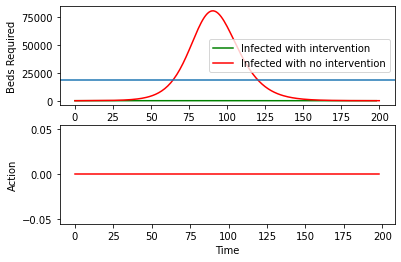

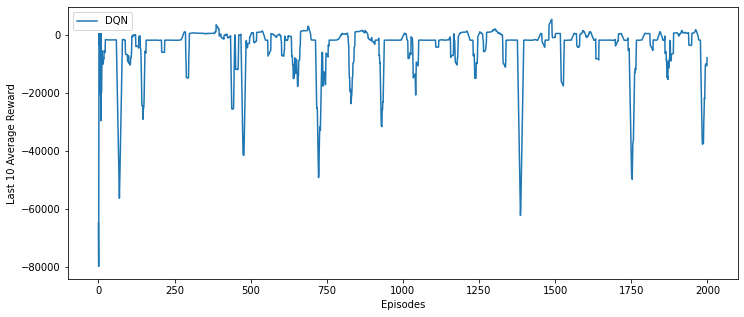

In [7]:
#limit on days.. budget 1500 =, no   -ve when capacity exceeded
dqn_model = run_algos_plot(30000,episodes=2000)
import pickle
filename = 'economic_days_limit_capacity_1000_new_budget_1800_red_rewards_no_tot.sav'
pickle.dump(dqn_model, open(filename, 'wb'))

plotting reward
DQN********************************************** 0
Reward =  -4104.0
Total infected : 0.0002806310336700521
Total cost 1990
200
3.68112997362241e-05
200
3.68112997362241e-05


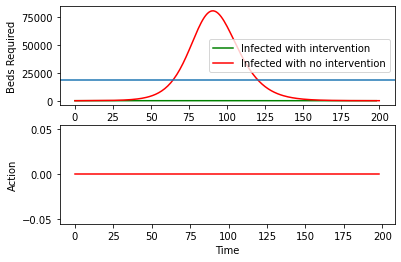

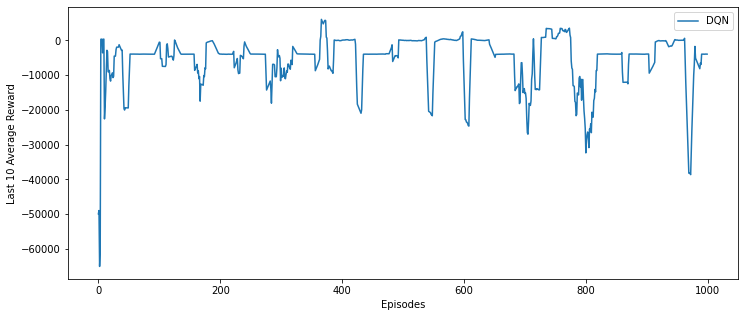

plotting reward
DQN********************************************** 1
Reward =  -4104.0
Total infected : 0.0002806310336700521
Total cost 1990
200
3.68112997362241e-05
200
3.68112997362241e-05


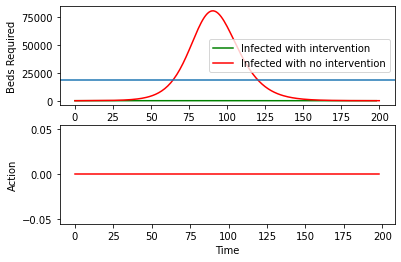

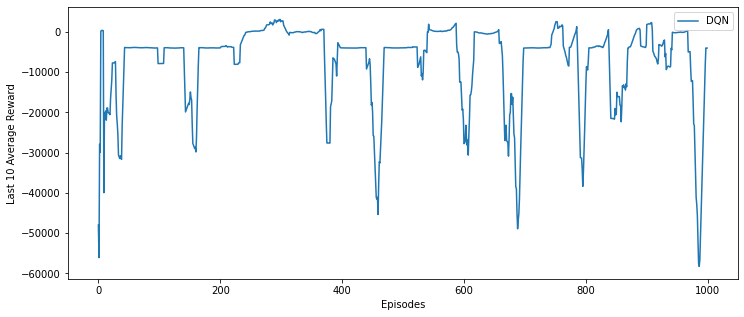

plotting reward
DQN********************************************** 2
Reward =  -4104.0
Total infected : 0.0002806310336700521
Total cost 1990
200
3.68112997362241e-05
200
3.68112997362241e-05


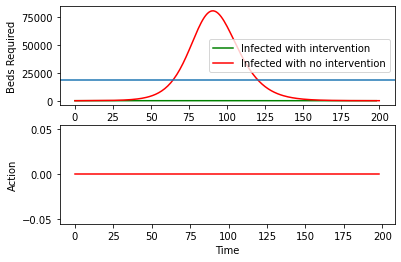

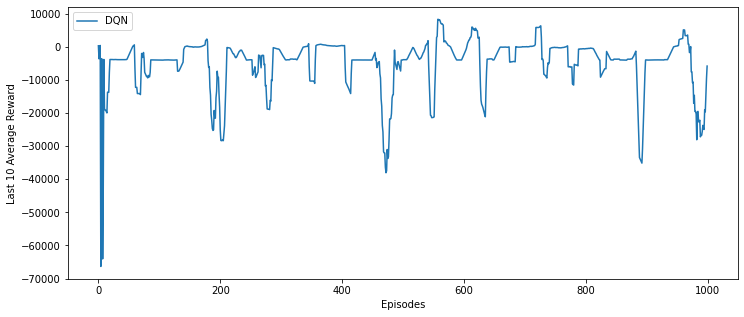

plotting reward
DQN********************************************** 3
Reward =  -4104.0
Total infected : 0.0002806310336700521
Total cost 1990
200
3.68112997362241e-05
200
3.68112997362241e-05


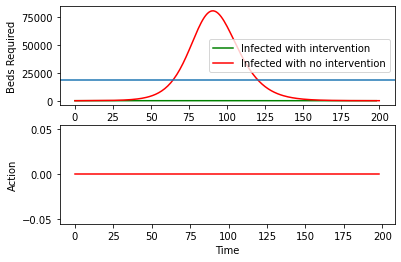

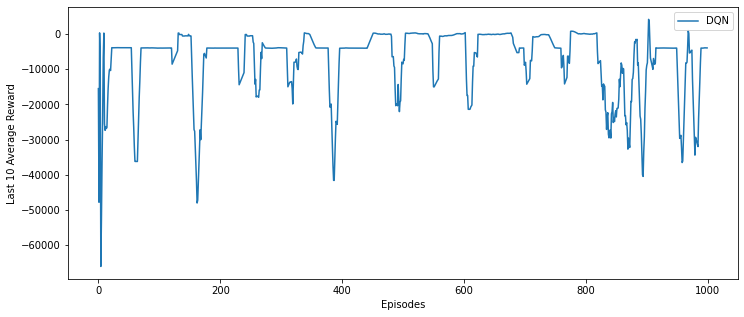

plotting reward
DQN********************************************** 4
Reward =  -4104.0
Total infected : 0.0002806310336700521
Total cost 1990
200
3.68112997362241e-05
200
3.68112997362241e-05


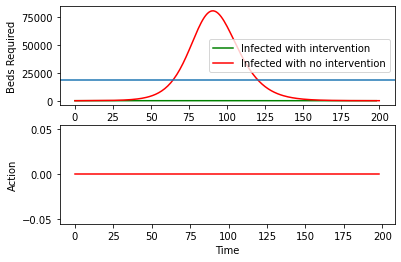

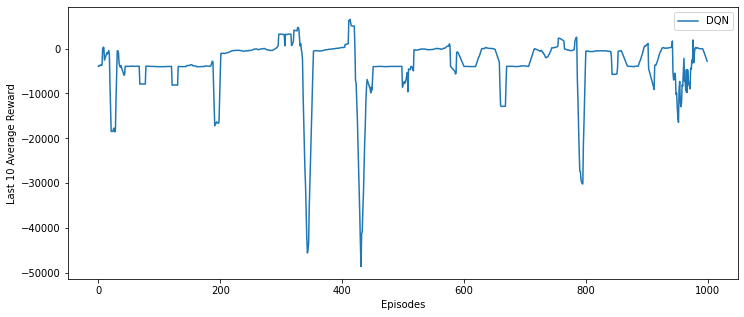

plotting reward
DQN********************************************** 5
Reward =  274.0
Total infected : 0.08542240909728932
Total cost 1592.0
200
0.011483909838119246
200
0.011483909838119246


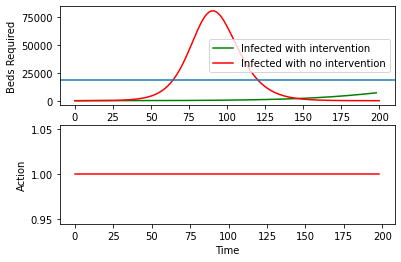

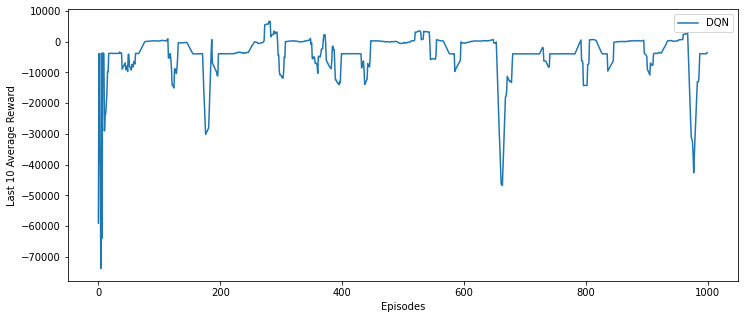

plotting reward
DQN********************************************** 6
Reward =  -59079.86394557823
Total infected : 0.8773605036206134
Total cost 1206.0
200
0.0844039887634183
200
0.0844039887634183


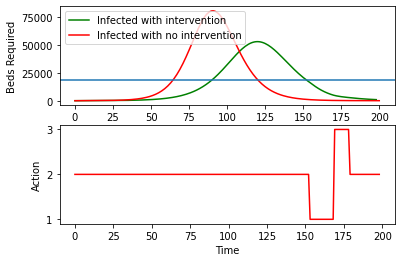

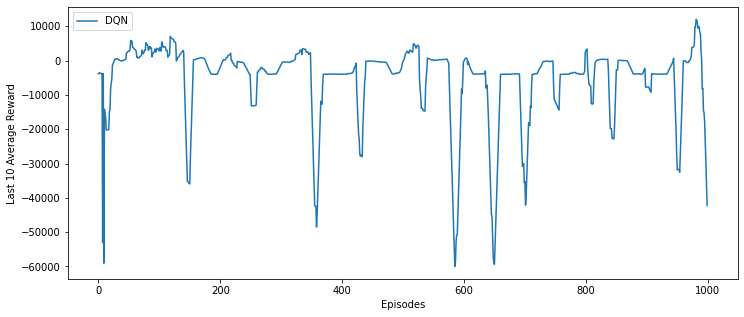

plotting reward
DQN********************************************** 7
Reward =  -4104.0
Total infected : 0.0002806310336700521
Total cost 1990
200
3.68112997362241e-05
200
3.68112997362241e-05


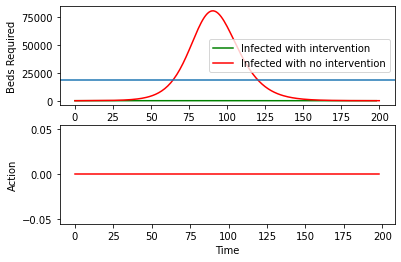

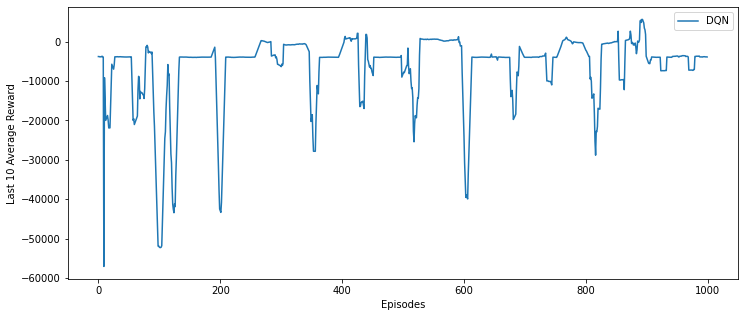

plotting reward
DQN********************************************** 8
Reward =  -4104.0
Total infected : 0.0002806310336700521
Total cost 1990
200
3.68112997362241e-05
200
3.68112997362241e-05


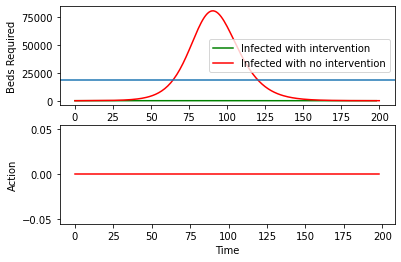

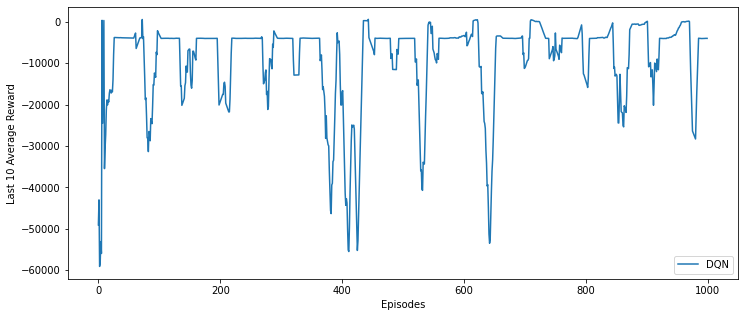

plotting reward
DQN********************************************** 9
Reward =  -4104.0
Total infected : 0.0002806310336700521
Total cost 1990
200
3.68112997362241e-05
200
3.68112997362241e-05


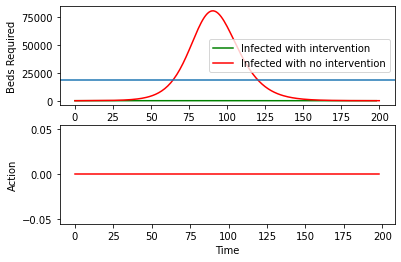

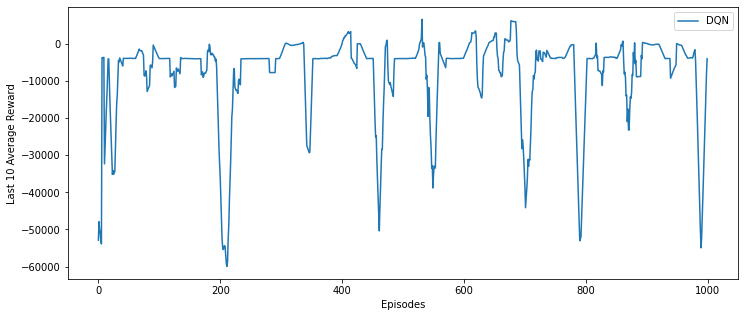

In [7]:
run_algos_plot_batch(30000,episodes=1000,number_of_times=10,name='economic_days_limit_changes_limit_capacity_1000_budget_1500')

## 3. Move the peak

In [ ]:
#DQN,PPO end of each episode
run_algos_plot(30000)

action dim== 4
episode: 1, total reward: -7574.0
episode: 2, total reward: -7590.0
episode: 3, total reward: 7900.0
episode: 4, total reward: 4708.0
episode: 5, total reward: 5890.0
episode: 6, total reward: 5212.0
episode: 7, total reward: 5872.0
episode: 8, total reward: 4930.0
episode: 9, total reward: 6346.0
episode: 10, total reward: 5654.0
episode: 11, total reward: 5568.0
episode: 12, total reward: 6370.0
episode: 13, total reward: 6156.0
episode: 14, total reward: 6062.0
episode: 15, total reward: 22386.0
episode: 16, total reward: 7084.0
episode: 17, total reward: 6042.0
episode: 18, total reward: 6562.0
episode: 19, total reward: 5802.0
episode: 20, total reward: 5646.0
episode: 21, total reward: 5888.0
episode: 22, total reward: 6372.0
episode: 23, total reward: 20380.0
episode: 24, total reward: 6514.0
episode: 25, total reward: 6198.0
episode: 26, total reward: 6772.0
episode: 27, total reward: 6164.0
episode: 28, total reward: 4476.0
episode: 29, total reward: 6064.0
epis

episode: 234, total reward: 7104.0
episode: 235, total reward: 8776.0
episode: 236, total reward: 7718.0
episode: 237, total reward: 7030.0
episode: 238, total reward: 5496.0
episode: 239, total reward: 5516.0
episode: 240, total reward: 21718.0
episode: 241, total reward: 12468.0
episode: 242, total reward: 7242.0
episode: 243, total reward: 4504.0
episode: 244, total reward: 4922.0
episode: 245, total reward: 4630.0
episode: 246, total reward: 6836.0
episode: 247, total reward: 6714.0
episode: 248, total reward: 7344.0
episode: 249, total reward: 8916.0
episode: 250, total reward: 9446.0
episode: 251, total reward: 8730.0
episode: 252, total reward: 8938.0
episode: 253, total reward: 6446.0
episode: 254, total reward: 7388.0
episode: 255, total reward: 20410.0
episode: 256, total reward: 8560.0
episode: 257, total reward: 2898.0
episode: 258, total reward: 8652.0
episode: 259, total reward: 2804.0
episode: 260, total reward: 3974.0
episode: 261, total reward: 6632.0
episode: 262, tot

action dim== 8
episode: 1, total reward: 224710.75
episode: 2, total reward: 224722.0
episode: 3, total reward: 224729.75
episode: 4, total reward: 224729.5
episode: 5, total reward: 212720.25
episode: 6, total reward: 224725.0
episode: 7, total reward: 224723.75
episode: 8, total reward: 224710.75
episode: 9, total reward: 224715.5
episode: 10, total reward: 224701.25
episode: 11, total reward: 224719.5
episode: 12, total reward: 224732.25
episode: 13, total reward: 224729.0
episode: 14, total reward: 224718.25
episode: 15, total reward: 228715.0
episode: 16, total reward: 224727.75
episode: 17, total reward: 224722.0
episode: 18, total reward: 224719.5
episode: 19, total reward: 224711.25
episode: 20, total reward: 224703.75
episode: 21, total reward: 210720.75
episode: 22, total reward: 224715.5
episode: 23, total reward: 224714.25
episode: 24, total reward: 224722.0
episode: 25, total reward: 224741.75
episode: 26, total reward: 224709.0
episode: 27, total reward: 224726.25
episode

episode: 223, total reward: 185011.75
episode: 224, total reward: 207004.0
episode: 225, total reward: 230993.0
episode: 226, total reward: 219993.5
episode: 227, total reward: 217001.5
episode: 228, total reward: 237990.0
episode: 229, total reward: 295988.75
episode: 230, total reward: 232996.0
episode: 231, total reward: 229991.75
episode: 232, total reward: 189989.25
episode: 233, total reward: 215015.75
episode: 234, total reward: 284987.0
episode: 235, total reward: 264996.5
episode: 236, total reward: 271999.75
episode: 237, total reward: 204002.25
episode: 238, total reward: 217997.0
episode: 239, total reward: 214997.75
episode: 240, total reward: 223994.75
episode: 241, total reward: 242992.75
episode: 242, total reward: 227994.25
episode: 243, total reward: 209002.0
episode: 244, total reward: 228994.25
episode: 245, total reward: 239988.25
episode: 246, total reward: 247993.5
episode: 247, total reward: 213999.5
episode: 248, total reward: 209999.5
episode: 249, total rewar

episode: 442, total reward: 191011.0
episode: 443, total reward: 196007.25
episode: 444, total reward: 183020.75
episode: 445, total reward: 186015.0
episode: 446, total reward: 193012.25
episode: 447, total reward: 221999.5
episode: 448, total reward: 188012.75
episode: 449, total reward: 192001.5
episode: 450, total reward: 226627.0
episode: 451, total reward: -160512.75
episode: 452, total reward: -167500.75
episode: 453, total reward: -167536.5
episode: 454, total reward: 181044.25
episode: 455, total reward: 181033.75
episode: 456, total reward: 184023.25
episode: 457, total reward: 197026.75
episode: 458, total reward: 180018.25
episode: 459, total reward: 193006.75
episode: 460, total reward: 189012.75
episode: 461, total reward: 197018.0
episode: 462, total reward: 183028.0
episode: 463, total reward: 187028.0
episode: 464, total reward: 183020.5
episode: 465, total reward: 186019.75
episode: 466, total reward: 183026.25
episode: 467, total reward: 180031.5
episode: 468, total 

episode: 661, total reward: 190018.5
episode: 662, total reward: 181027.75
episode: 663, total reward: 180032.0
episode: 664, total reward: 187030.25
episode: 665, total reward: 204027.75
episode: 666, total reward: 181031.0
episode: 667, total reward: 182034.25
episode: 668, total reward: 182032.0
episode: 669, total reward: 181019.0
episode: 670, total reward: 188029.0
episode: 671, total reward: 187022.0
episode: 672, total reward: 187019.5
episode: 673, total reward: 185018.5
episode: 674, total reward: 198007.0
episode: 675, total reward: 189014.0
episode: 676, total reward: 184016.75
episode: 677, total reward: 188036.0
episode: 678, total reward: 187031.5
episode: 679, total reward: 189021.0
episode: 680, total reward: 196022.0
episode: 681, total reward: 184029.75
episode: 682, total reward: 187032.0
episode: 683, total reward: 187033.25
episode: 684, total reward: 181031.75
episode: 685, total reward: 186025.5
episode: 686, total reward: 180033.0
episode: 687, total reward: 18

episode: 880, total reward: 200022.0
episode: 881, total reward: 183032.75
episode: 882, total reward: 178027.25
episode: 883, total reward: 179033.75
episode: 884, total reward: 186039.5
episode: 885, total reward: 194035.5
episode: 886, total reward: 179037.25
episode: 887, total reward: 177043.0
episode: 888, total reward: 190017.25
episode: 889, total reward: 190019.5
episode: 890, total reward: 180023.25
episode: 891, total reward: 179032.0
episode: 892, total reward: 186023.75
episode: 893, total reward: 188040.0
episode: 894, total reward: 185037.75
episode: 895, total reward: 195023.75
episode: 896, total reward: 174037.25
episode: 897, total reward: 179036.25
episode: 898, total reward: 180029.5
episode: 899, total reward: 179030.25
episode: 900, total reward: 177036.75
episode: 901, total reward: 177033.25
episode: 902, total reward: 180023.75
episode: 903, total reward: 179015.5
episode: 904, total reward: 182018.75
episode: 905, total reward: 193026.75
episode: 906, total r

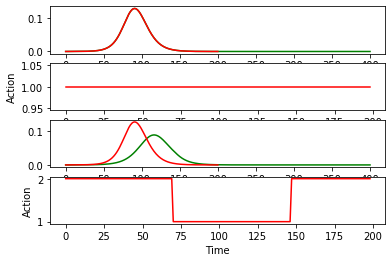

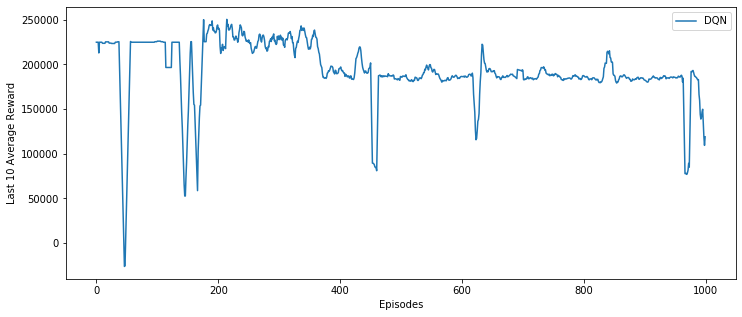

In [6]:
#DQN,PPO 200 age, 200 limit
run_algos_plot(30000)

## 4. Limiting Conditions

### 4.1  Reducing compliance -total infections

plotting reward
DQN********************************************** 0
Reward =  796.0
Total infected : 0.0002806310336700521
Total cost 1990
200
3.68112997362241e-05
200
3.68112997362241e-05


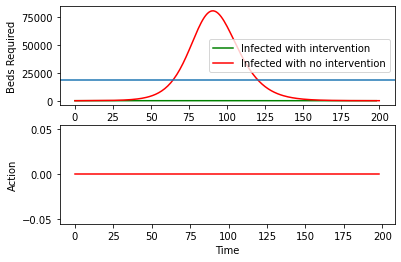

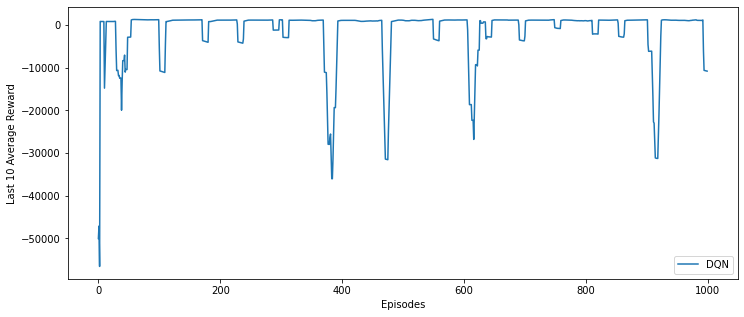

plotting reward
DQN********************************************** 1
Reward =  1112.0
Total infected : 0.02372689055681651
Total cost 1674.0
200
0.0009540231348113232
200
0.0009540231348113232


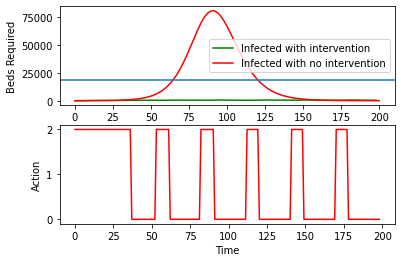

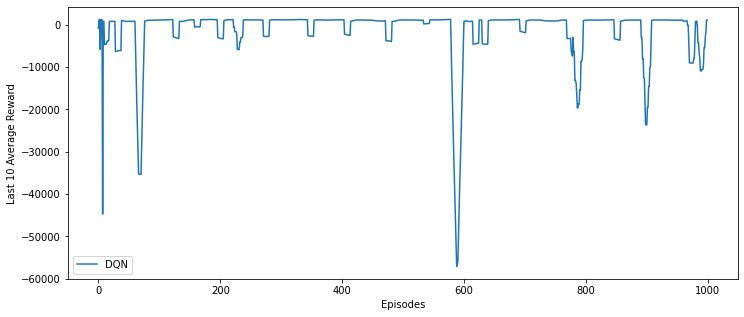

plotting reward
DQN********************************************** 2
Reward =  1422.0
Total infected : 0.5251592914368106
Total cost 1364.0
200
0.026278835437302816
200
0.026278835437302816


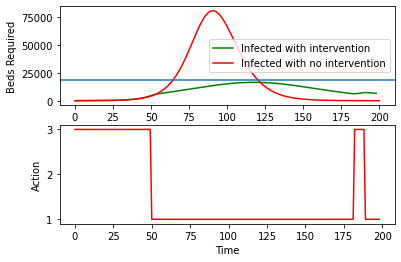

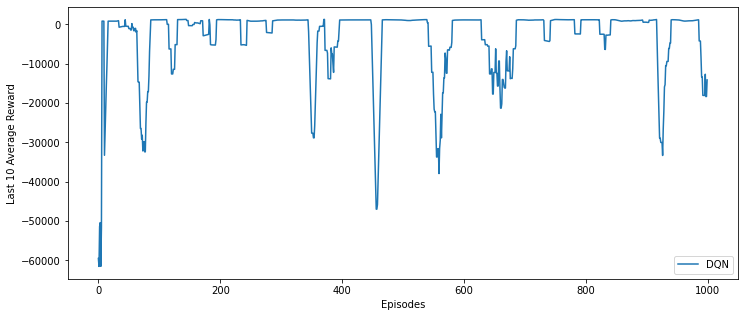

plotting reward
DQN********************************************** 3
Reward =  1172.0
Total infected : 0.05408035074986342
Total cost 1614.0
200
0.002024857066280877
200
0.002024857066280877


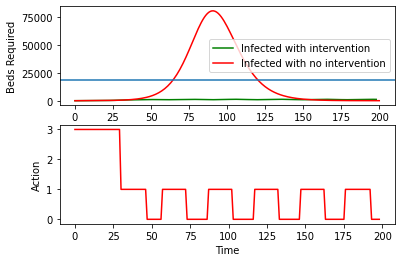

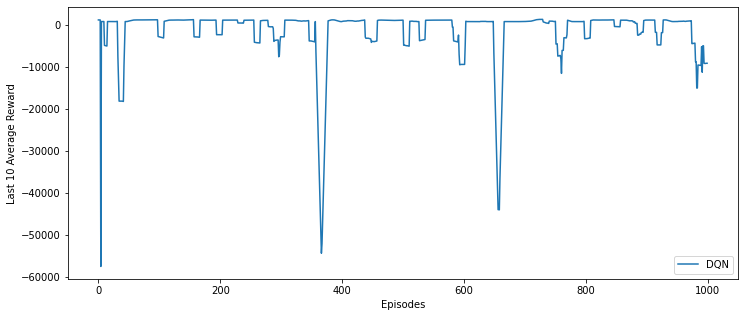

plotting reward
DQN********************************************** 4
Reward =  796.0
Total infected : 0.0002806310336700521
Total cost 1990
200
3.68112997362241e-05
200
3.68112997362241e-05


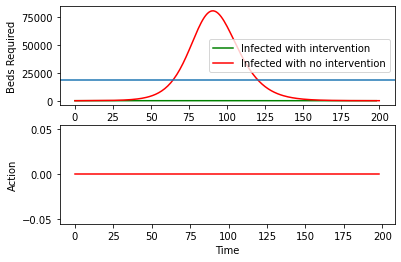

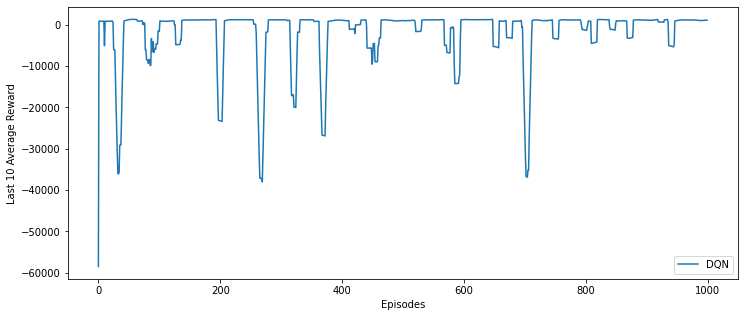

plotting reward
DQN********************************************** 5
Reward =  796.0
Total infected : 0.0002806310336700521
Total cost 1990
200
3.68112997362241e-05
200
3.68112997362241e-05


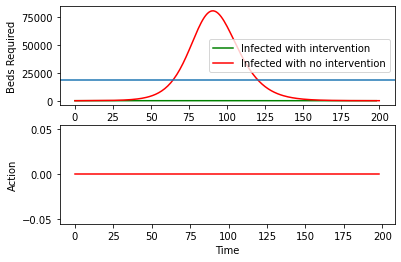

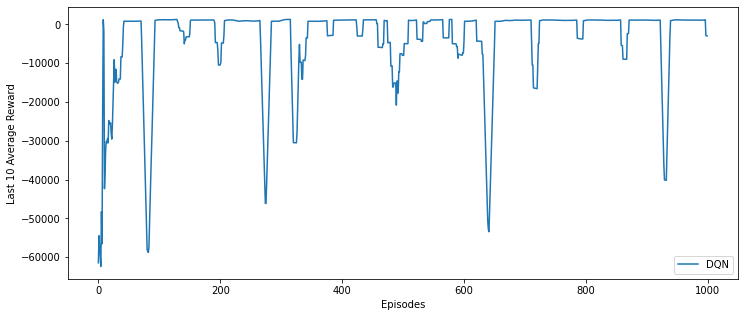

plotting reward
DQN********************************************** 6
Reward =  1120.0
Total infected : 0.03732194591708455
Total cost 1666.0
200
0.0016428126259143163
200
0.0016428126259143163


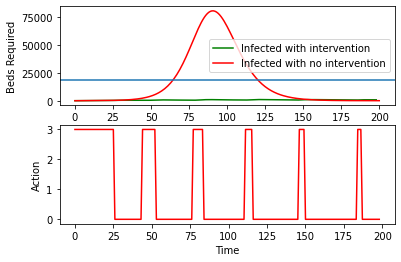

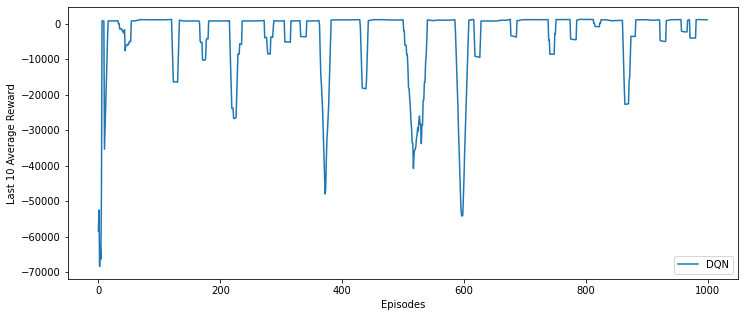

plotting reward
DQN********************************************** 7
Reward =  1168.0
Total infected : 0.08221705163460735
Total cost 1618.0
200
0.00415653150041179
200
0.00415653150041179


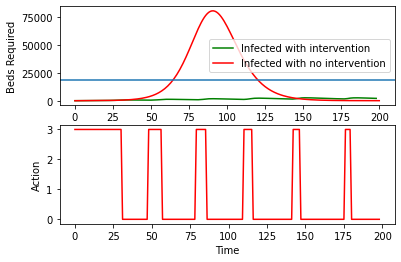

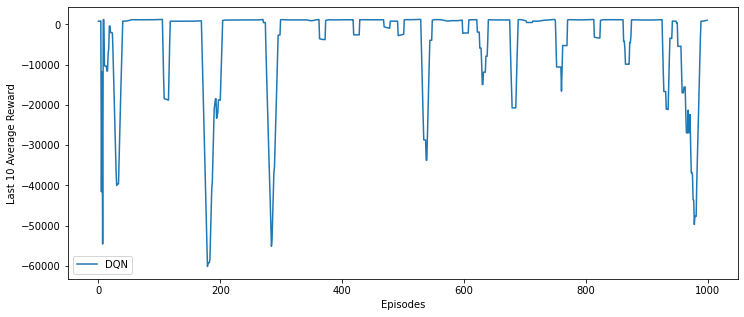

plotting reward
DQN********************************************** 8
Reward =  796.0
Total infected : 0.0002806310336700521
Total cost 1990
200
3.68112997362241e-05
200
3.68112997362241e-05


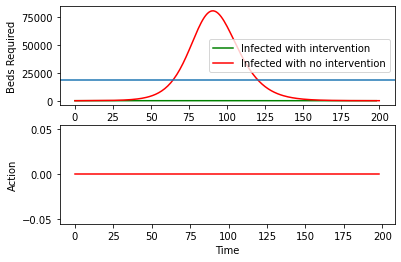

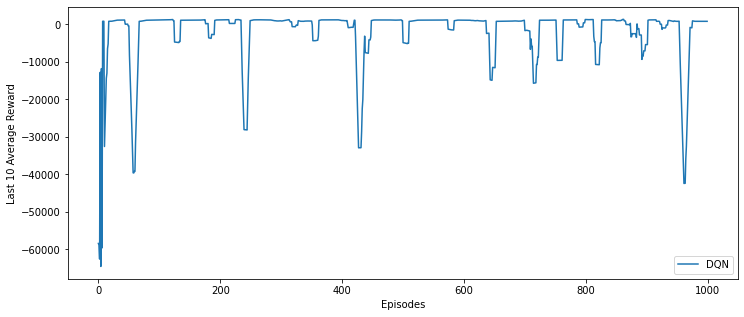

plotting reward
DQN********************************************** 9
Reward =  1144.0
Total infected : 0.06360081938464357
Total cost 1642.0
200
0.0052978938788806
200
0.0052978938788806


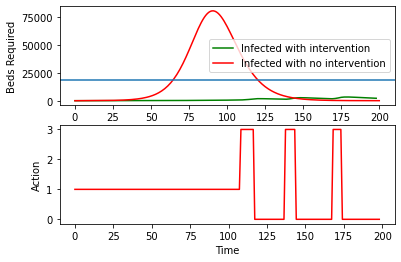

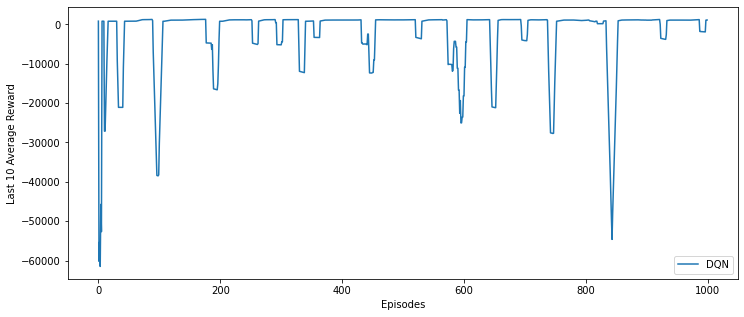

In [7]:
#DQN,PPO
run_algos_plot_batch(30000,episodes=1000,number_of_times=10,name='economic_days_limit_compliance_limit_capacity_1000')

### 4.2  Reducing changes -total infections

action dim== 4
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
diff= -44.0  total= 1544.0
2 -1450.0
episode: 1, total reward: -61420.0
diff= -446.0  total= 1946.0
2 -4470.0
episode: 2, total reward: -6440.0
diff= -454.0  total= 1954.0
2 -4550.0
episode: 3, total reward: -6520.0
diff= -458.0  total= 1958.0
2 -4590.0
episode: 4, total reward: -6560.0
diff= -462.0  total= 1962.0
2 -4630.0
episode: 5, total reward: -6600.0
diff= -444.0  total= 1944.0
2 -4450.0
episode: 6, total reward: -6420.0
diff= -466.0  total= 1

capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
diff= 484.0  total= 1016.0
1 196.61157024793388
episode: 48, total reward: -53773.38842975206
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
diff= 26.0  total= 1474.0
1 3836.153846153846
episode: 49, total reward: -50133.846153846156
diff= -482.0  total= 1982.0
2 -4830.0
episode: 50, total reward: -6800.0
diff= -466.0  total= 1966.0
2 -4670.0
episode: 51, total reward: -6640.0
diff= -480.0  total= 1980.0
2 -4810.0
episode: 52, total reward: -6780.0
diff= -470.0  total= 1970.0

diff= -480.0  total= 1980.0
2 -4810.0
episode: 128, total reward: -6780.0
diff= -476.0  total= 1976.0
2 -4770.0
episode: 129, total reward: -6740.0
diff= -472.0  total= 1972.0
2 -4730.0
episode: 130, total reward: -6700.0
diff= -468.0  total= 1968.0
2 -4690.0
episode: 131, total reward: -6660.0
diff= -486.0  total= 1986.0
2 -4870.0
episode: 132, total reward: -6840.0
diff= -472.0  total= 1972.0
2 -4730.0
episode: 133, total reward: -6700.0
diff= -484.0  total= 1984.0
2 -4850.0
episode: 134, total reward: -6820.0
diff= -470.0  total= 1970.0
2 -4710.0
episode: 135, total reward: -6680.0
diff= -462.0  total= 1962.0
2 -4630.0
episode: 136, total reward: -6600.0
diff= -488.0  total= 1988.0
2 -4890.0
episode: 137, total reward: -6860.0
diff= -478.0  total= 1978.0
2 -4790.0
episode: 138, total reward: -6760.0
diff= -476.0  total= 1976.0
2 -4770.0
episode: 139, total reward: -6740.0
diff= -490  total= 1990
2 -4910
episode: 140, total reward: -6880
diff= -460.0  total= 1960.0
2 -4610.0
episode:

diff= -90.0  total= 1590.0
2 -910.0
episode: 222, total reward: -2880.0
diff= -88.0  total= 1588.0
2 -890.0
episode: 223, total reward: -2860.0
diff= -82.0  total= 1582.0
2 -830.0
episode: 224, total reward: -2800.0
diff= -88.0  total= 1588.0
2 -890.0
episode: 225, total reward: -2860.0
diff= -84.0  total= 1584.0
2 -850.0
episode: 226, total reward: -2820.0
diff= -88.0  total= 1588.0
2 -890.0
episode: 227, total reward: -2860.0
diff= -90.0  total= 1590.0
2 -910.0
episode: 228, total reward: -2880.0
diff= -90.0  total= 1590.0
2 -910.0
episode: 229, total reward: -2880.0
diff= -94.0  total= 1594.0
2 -950.0
episode: 230, total reward: -2920.0
diff= -90.0  total= 1590.0
2 -910.0
episode: 231, total reward: -2880.0
diff= -54.0  total= 1554.0
2 -550.0
episode: 232, total reward: -2520.0
diff= -132.0  total= 1632.0
2 -1330.0
episode: 233, total reward: -3300.0
diff= -96.0  total= 1596.0
2 -970.0
episode: 234, total reward: -2940.0
diff= -82.0  total= 1582.0
2 -830.0
episode: 235, total reward

diff= -92.0  total= 1592.0
2 -930.0
episode: 321, total reward: -2900.0
diff= -82.0  total= 1582.0
2 -830.0
episode: 322, total reward: -2800.0
diff= -88.0  total= 1588.0
2 -890.0
episode: 323, total reward: -2860.0
diff= -64.0  total= 1564.0
2 -650.0
episode: 324, total reward: -2620.0
diff= 58.0  total= 1442.0
1 1714.1379310344828
episode: 325, total reward: -255.8620689655172
diff= 64.0  total= 1436.0
1 1552.5
episode: 326, total reward: -417.5
diff= 86.0  total= 1414.0
1 1152.7906976744187
episode: 327, total reward: -817.2093023255813
diff= 102.0  total= 1398.0
1 970.3921568627451
episode: 328, total reward: -999.6078431372549
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity


capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
diff= 148.0  total= 1352.0
1 665.6756756756757
episode: 386, total reward: -59304.32432432433
diff= -88.0  total= 1588.0
2 -890.0
episode: 387, total reward: -2860.0
diff= -78.0  total= 1578.0
2 -790.0
episode: 388, total reward: -2760.0
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
diff= 

diff= -476.0  total= 1976.0
2 -4770.0
episode: 439, total reward: -6740.0
diff= -476.0  total= 1976.0
2 -4770.0
episode: 440, total reward: -6740.0
diff= -478.0  total= 1978.0
2 -4790.0
episode: 441, total reward: -6760.0
diff= -124.0  total= 1624.0
2 -1250.0
episode: 442, total reward: -3220.0
diff= -86.0  total= 1586.0
2 -870.0
episode: 443, total reward: -2840.0
diff= -88.0  total= 1588.0
2 -890.0
episode: 444, total reward: -2860.0
diff= -88.0  total= 1588.0
2 -890.0
episode: 445, total reward: -2860.0
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
diff= -78.0  total= 1578.0
2 -1790.0
episode: 446, total reward: -12760.0
diff= -470.0  total= 1970.0
2 -4710.0
episode: 447, total reward: -6680.0
diff= -474.0  total= 1974.0
2 -4750.0
episode: 448, total reward: -6720.0
diff= -478.0  total= 1978.0
2 -4790.0
episode: 449, total reward: -6760.0
diff= -484.0  total= 1984.0
2 -4850.0
episode: 450, total reward: -6820.0
diff= -486.0  total= 1986.0


diff= -482.0  total= 1982.0
2 -4830.0
episode: 507, total reward: -6800.0
diff= -344.0  total= 1844.0
2 -3450.0
episode: 508, total reward: -5420.0
diff= -320.0  total= 1820.0
2 -3210.0
episode: 509, total reward: -5180.0
diff= -312.0  total= 1812.0
2 -3130.0
episode: 510, total reward: -5100.0
diff= -316.0  total= 1816.0
2 -3170.0
episode: 511, total reward: -5140.0
diff= -306.0  total= 1806.0
2 -3070.0
episode: 512, total reward: -5040.0
diff= -330.0  total= 1830.0
2 -3310.0
episode: 513, total reward: -5280.0
diff= -316.0  total= 1816.0
2 -3170.0
episode: 514, total reward: -5140.0
diff= -332.0  total= 1832.0
2 -3330.0
episode: 515, total reward: -5300.0
diff= -338.0  total= 1838.0
2 -3390.0
episode: 516, total reward: -5360.0
diff= -342.0  total= 1842.0
2 -3430.0
episode: 517, total reward: -5400.0
diff= -350.0  total= 1850.0
2 -3510.0
episode: 518, total reward: -5480.0
diff= -358.0  total= 1858.0
2 -3590.0
episode: 519, total reward: -5560.0
diff= -270.0  total= 1770.0
2 -2710.0


diff= -478.0  total= 1978.0
2 -4790.0
episode: 600, total reward: -6760.0
diff= -476.0  total= 1976.0
2 -4770.0
episode: 601, total reward: -6740.0
diff= -486.0  total= 1986.0
2 -4870.0
episode: 602, total reward: -6840.0
diff= -474.0  total= 1974.0
2 -4750.0
episode: 603, total reward: -6720.0
diff= -486.0  total= 1986.0
2 -4870.0
episode: 604, total reward: -6840.0
diff= -130.0  total= 1630.0
2 -1310.0
episode: 605, total reward: -3280.0
diff= -94.0  total= 1594.0
2 -950.0
episode: 606, total reward: -2920.0
diff= -94.0  total= 1594.0
2 -950.0
episode: 607, total reward: -2920.0
diff= -92.0  total= 1592.0
2 -930.0
episode: 608, total reward: -2900.0
diff= -86.0  total= 1586.0
2 -870.0
episode: 609, total reward: -2840.0
diff= -94.0  total= 1594.0
2 -950.0
episode: 610, total reward: -2920.0
diff= -54.0  total= 1554.0
2 -550.0
episode: 611, total reward: -2520.0
diff= -2.0  total= 1502.0
2 -30.0
episode: 612, total reward: -2000.0
capacity
capacity
capacity
capacity
capacity
capacity


capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
diff= 82.0  total= 1418.0
1 1209.5121951219512
episode: 674, total reward: -54760.48780487805
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
diff= 4.0  total= 1496.0
1 24990.0
episode: 675, total reward: 1020.0
diff= -430.0  total= 1930.0
2 -4310.0
episode: 676, total reward: -6280.0
diff= 32.0  total= 1468.0
1 3115.0
episode: 677, total reward: 1145.0
diff= 2.0  total= 1498.0
1

diff= 62.0  total= 1438.0
1 1602.9032258064515
episode: 727, total reward: -367.0967741935485
diff= 102.0  total= 1398.0
1 970.3921568627451
episode: 728, total reward: -999.6078431372549
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
diff= -2.0  total= 1502.0
2 -1030.0
episode: 729, total reward: -11000.0
diff= -82.0  total= 1582.0
2 -830.0
episode: 730, total reward: -2800.0
diff= -96.0  total= 1596.0
2 -970.0
episode: 731, total reward: -2940.0
diff= -90.0  total= 1590.0
2 -910.0
episode: 732, total reward: -2880.0
diff= -96.0  total= 1596.0
2 -970.0
episode: 733, total reward: -2940.0
diff= -92.0  total= 1592.0
2 -930.0
episode: 734, total reward: -2900.0
diff= -88.0  total= 1588.0
2 -890.0
episode: 735, total reward: -2860.0
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
diff= -74.0  total=

diff= -38.0  total= 1538.0
2 -390.0
episode: 775, total reward: -2360.0
diff= 52.0  total= 1448.0
1 1913.076923076923
episode: 776, total reward: -56.923076923076906
diff= 36.0  total= 1464.0
1 2767.777777777778
episode: 777, total reward: 797.7777777777778
diff= -164.0  total= 1664.0
2 -1650.0
episode: 778, total reward: -3620.0
diff= -130.0  total= 1630.0
2 -1310.0
episode: 779, total reward: -3280.0
diff= -88.0  total= 1588.0
2 -890.0
episode: 780, total reward: -2860.0
diff= -174.0  total= 1674.0
2 -1750.0
episode: 781, total reward: -3720.0
diff= -88.0  total= 1588.0
2 -890.0
episode: 782, total reward: -2860.0
diff= -88.0  total= 1588.0
2 -890.0
episode: 783, total reward: -2860.0
diff= -88.0  total= 1588.0
2 -890.0
episode: 784, total reward: -2860.0
diff= -86.0  total= 1586.0
2 -870.0
episode: 785, total reward: -2840.0
diff= -4.0  total= 1504.0
2 -50.0
episode: 786, total reward: -2020.0
diff= -20.0  total= 1520.0
2 -210.0
episode: 787, total reward: -2180.0
diff= -120.0  tota

diff= 138.0  total= 1362.0
1 714.6376811594203
episode: 857, total reward: -64255.362318840576
diff= 48.0  total= 1452.0
1 2073.333333333333
episode: 858, total reward: 103.33333333333303
diff= 118.0  total= 1382.0
1 837.457627118644
episode: 859, total reward: -1132.542372881356
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
capacity
diff= 172.0  total= 1328.0
1 571.3953488372093
episode: 860, t

diff= -140.0  total= 1640.0
2 -1410.0
episode: 918, total reward: -3380.0
diff= -88.0  total= 1588.0
2 -890.0
episode: 919, total reward: -2860.0
diff= -76.0  total= 1576.0
2 -770.0
episode: 920, total reward: -2740.0
diff= -138.0  total= 1638.0
2 -1390.0
episode: 921, total reward: -3360.0
diff= -156.0  total= 1656.0
2 -1570.0
episode: 922, total reward: -3540.0
diff= -138.0  total= 1638.0
2 -1390.0
episode: 923, total reward: -3360.0
diff= -92.0  total= 1592.0
2 -930.0
episode: 924, total reward: -2900.0
diff= -126.0  total= 1626.0
2 -1270.0
episode: 925, total reward: -3240.0
diff= -292.0  total= 1792.0
2 -2930.0
episode: 926, total reward: -4900.0
diff= -146.0  total= 1646.0
2 -1470.0
episode: 927, total reward: -3440.0
diff= -54.0  total= 1554.0
2 -550.0
episode: 928, total reward: -2520.0
diff= -122.0  total= 1622.0
2 -1230.0
episode: 929, total reward: -3200.0
diff= -218.0  total= 1718.0
2 -2190.0
episode: 930, total reward: -4160.0
diff= -102.0  total= 1602.0
2 -1030.0
episode:

diff= -484.0  total= 1984.0
2 -4850.0
episode: 971, total reward: -6820.0
diff= -476.0  total= 1976.0
2 -4770.0
episode: 972, total reward: -6740.0
diff= -482.0  total= 1982.0
2 -4830.0
episode: 973, total reward: -6800.0
diff= -470.0  total= 1970.0
2 -4710.0
episode: 974, total reward: -6680.0
diff= -466.0  total= 1966.0
2 -4670.0
episode: 975, total reward: -6640.0
diff= -482.0  total= 1982.0
2 -4830.0
episode: 976, total reward: -6800.0
diff= -480.0  total= 1980.0
2 -4810.0
episode: 977, total reward: -6780.0
diff= -480.0  total= 1980.0
2 -4810.0
episode: 978, total reward: -6780.0
diff= -164.0  total= 1664.0
2 -1650.0
episode: 979, total reward: -3620.0
diff= -208.0  total= 1708.0
2 -2090.0
episode: 980, total reward: -4060.0
diff= -462.0  total= 1962.0
2 -4630.0
episode: 981, total reward: -6600.0
diff= -470.0  total= 1970.0
2 -4710.0
episode: 982, total reward: -6680.0
diff= -176.0  total= 1676.0
2 -1770.0
episode: 983, total reward: -3740.0
diff= -108.0  total= 1608.0
2 -1090.0


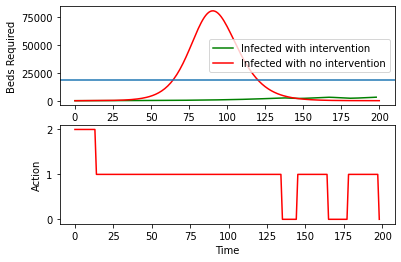

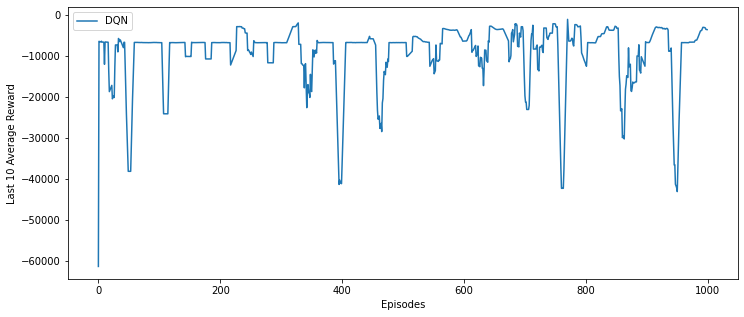

In [10]:
#DQN,PPO
#penalty for number of days

#limit on days.. budget 1500 =, no   -ve when capacity exceeded
dqn_model = run_algos_plot(30000,episodes=1000)
import pickle
filename = 'economic_days_limit_changes_limit_capacity_1000_new_budget_1500_red_rewards_no_tot.sav'
pickle.dump(dqn_model, open(filename, 'wb'))

action dim== 4
episode: 1, total reward: -64544.0
episode: 2, total reward: -774.0
episode: 3, total reward: -784.0
episode: 4, total reward: -27762.0
episode: 5, total reward: -23770.0
episode: 6, total reward: -1168.0
episode: 7, total reward: -1148.0
episode: 8, total reward: -1144.0
episode: 9, total reward: -1156.0
episode: 10, total reward: -1170.0
episode: 11, total reward: -1148.0
episode: 12, total reward: -1166.0
episode: 13, total reward: -1164.0
episode: 14, total reward: -1160.0
episode: 15, total reward: -1176.0
episode: 16, total reward: -1140.0
episode: 17, total reward: -1162.0
episode: 18, total reward: -1160.0
episode: 19, total reward: -1170.0
episode: 20, total reward: -1172.0
episode: 21, total reward: -1164.0
episode: 22, total reward: -1146.0
episode: 23, total reward: -1164.0
episode: 24, total reward: -1178.0
episode: 25, total reward: -1140.0
episode: 26, total reward: -1162.0
episode: 27, total reward: -1178.0
episode: 28, total reward: -1178.0
episode: 29, 

episode: 232, total reward: -1170.0
episode: 233, total reward: -1178.0
episode: 234, total reward: -1176.0
episode: 235, total reward: -1168.0
episode: 236, total reward: -1176.0
episode: 237, total reward: -1176.0
episode: 238, total reward: -1160.0
episode: 239, total reward: -1156.0
episode: 240, total reward: -1170.0
episode: 241, total reward: -1160.0
episode: 242, total reward: -1150.0
episode: 243, total reward: -1176.0
episode: 244, total reward: -1178.0
episode: 245, total reward: -1170.0
episode: 246, total reward: -1162.0
episode: 247, total reward: -1162.0
episode: 248, total reward: -1178.0
episode: 249, total reward: -1172.0
episode: 250, total reward: -1174.0
episode: 251, total reward: -1164.0
episode: 252, total reward: -1170.0
episode: 253, total reward: -1156.0
episode: 254, total reward: -1180.0
episode: 255, total reward: -1098.0
episode: 256, total reward: -1170.0
episode: 257, total reward: -1074.0
episode: 258, total reward: -1026.0
episode: 259, total reward: 

episode: 461, total reward: -3778.0
episode: 462, total reward: -774.0
episode: 463, total reward: -784.0
episode: 464, total reward: -786.0
episode: 465, total reward: -776.0
episode: 466, total reward: -50652.0
episode: 467, total reward: -684.0
episode: 468, total reward: -1176.0
episode: 469, total reward: -744.0
episode: 470, total reward: -630.0
episode: 471, total reward: -1164.0
episode: 472, total reward: -1120.0
episode: 473, total reward: -640.0
episode: 474, total reward: -974.0
episode: 475, total reward: -628.0
episode: 476, total reward: -1164.0
episode: 477, total reward: -23760.0
episode: 478, total reward: -786.0
episode: 479, total reward: -784.0
episode: 480, total reward: -55654.0
episode: 481, total reward: -784.0
episode: 482, total reward: -780.0
episode: 483, total reward: -784.0
episode: 484, total reward: -786.0
episode: 485, total reward: -782.0
episode: 486, total reward: -784.0
episode: 487, total reward: -778.0
episode: 488, total reward: -722.0
episode: 

episode: 691, total reward: -904.0
episode: 692, total reward: -900.0
episode: 693, total reward: -862.0
episode: 694, total reward: -836.0
episode: 695, total reward: -824.0
episode: 696, total reward: -852.0
episode: 697, total reward: -862.0
episode: 698, total reward: -868.0
episode: 699, total reward: -866.0
episode: 700, total reward: -844.0
episode: 701, total reward: -852.0
episode: 702, total reward: -886.0
episode: 703, total reward: -1032.0
episode: 704, total reward: -1058.0
episode: 705, total reward: -930.0
episode: 706, total reward: -918.0
episode: 707, total reward: -858.0
episode: 708, total reward: -892.0
episode: 709, total reward: -852.0
episode: 710, total reward: -1002.0
episode: 711, total reward: -952.0
episode: 712, total reward: -836.0
episode: 713, total reward: -1004.0
episode: 714, total reward: -1022.0
episode: 715, total reward: -1056.0
episode: 716, total reward: -924.0
episode: 717, total reward: -854.0
episode: 718, total reward: -876.0
episode: 719, 

episode: 923, total reward: -1038.0
episode: 924, total reward: -986.0
episode: 925, total reward: -1044.0
episode: 926, total reward: -1028.0
episode: 927, total reward: -1036.0
episode: 928, total reward: -1034.0
episode: 929, total reward: -872.0
episode: 930, total reward: -1052.0
episode: 931, total reward: -1028.0
episode: 932, total reward: -826.0
episode: 933, total reward: -994.0
episode: 934, total reward: -778.0
episode: 935, total reward: -868.0
episode: 936, total reward: -906.0
episode: 937, total reward: -1086.0
episode: 938, total reward: -1174.0
episode: 939, total reward: -1164.0
episode: 940, total reward: -1162.0
episode: 941, total reward: -1176.0
episode: 942, total reward: -1180.0
episode: 943, total reward: -924.0
episode: 944, total reward: -808.0
episode: 945, total reward: -782.0
episode: 946, total reward: -54616.0
episode: 947, total reward: -786.0
episode: 948, total reward: -780.0
episode: 949, total reward: -778.0
episode: 950, total reward: -786.0
episo

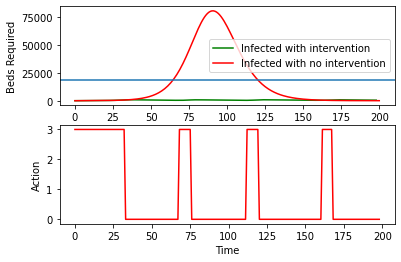

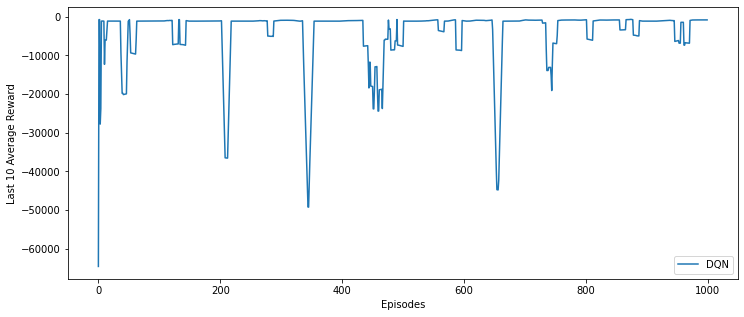

In [6]:
#DQN,PPO
#penalty for number of days
time_steps,episodes=1000,number_of_times=1,name=''
#limit on days.. budget 1500 =, no   -ve when capacity exceeded
dqn_model = run_algos_plot(30000,episodes=1000)
import pickle
filename = 'economic_days_limit_changes_limit_capacity_1000.sav'
pickle.dump(dqn_model, open(filename, 'wb'))

action dim== 4
plotting reward
DQN********************************************** 0
Reward =  796.0
Total infected : 0.0002806310336700521
Total cost 1990
200
3.68112997362241e-05
200
3.68112997362241e-05


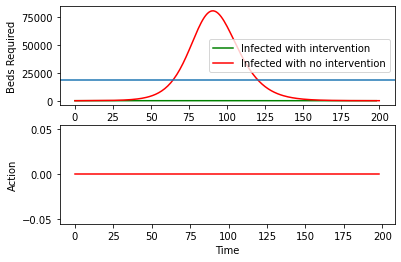

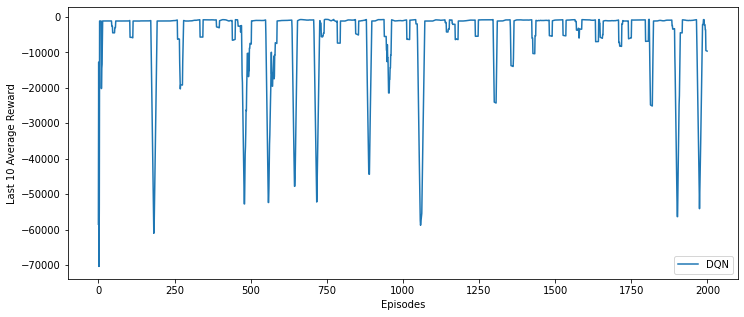

action dim== 4
plotting reward
DQN********************************************** 1
Reward =  796.0
Total infected : 0.0002806310336700521
Total cost 1990
200
3.68112997362241e-05
200
3.68112997362241e-05


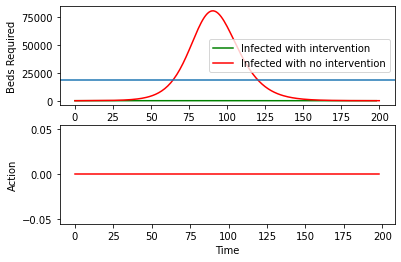

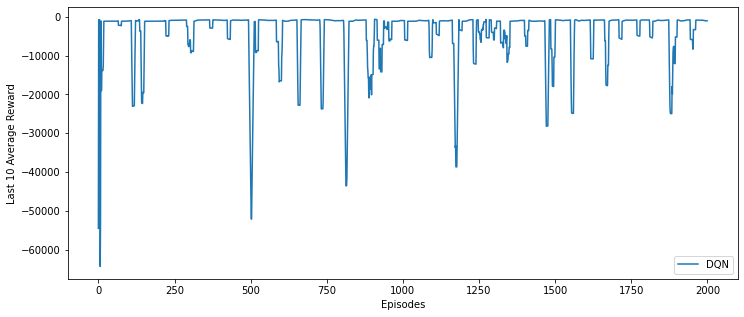

action dim== 4
plotting reward
DQN********************************************** 2
Reward =  796.0
Total infected : 0.0002806310336700521
Total cost 1990
200
3.68112997362241e-05
200
3.68112997362241e-05


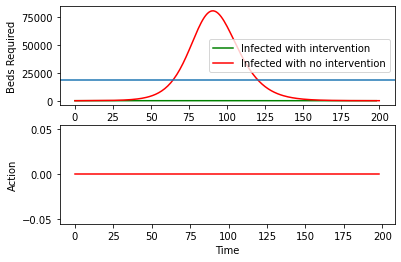

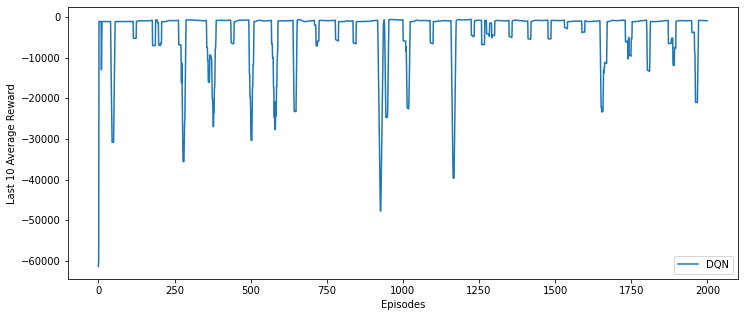

action dim== 4
plotting reward
DQN********************************************** 3
Reward =  1124.0
Total infected : 0.01943829147103232
Total cost 1662.0
200
0.0008843278801651169
200
0.0008843278801651169


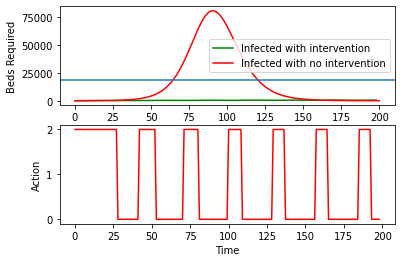

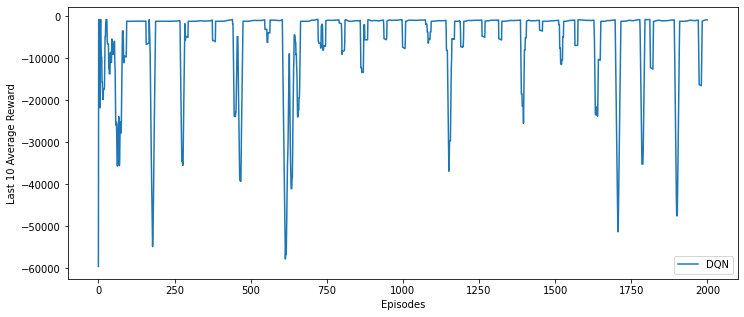

action dim== 4


KeyboardInterrupt: 

In [14]:
run_algos_plot_batch(30000,episodes=2000,number_of_times=20,name='economic_days_limit_changes_limit_capacity_1000')

action dim== 4
plotting reward
DQN********************************************** 0
Reward =  1100.0
Total infected : 0.03579334410155
Total cost 1686.0
200
0.0018834571912925268
200
0.0018834571912925268


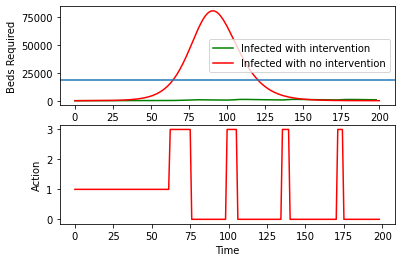

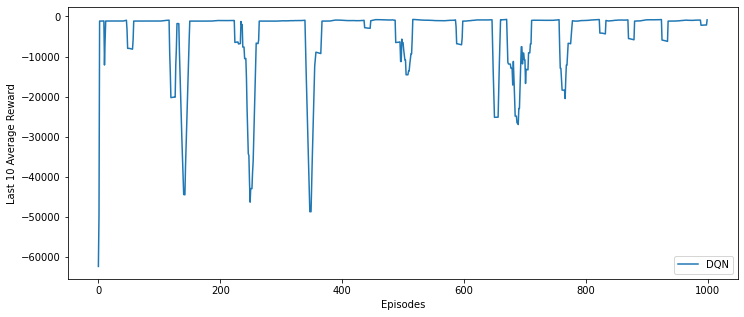

action dim== 4
plotting reward
DQN********************************************** 1
Reward =  1114.0
Total infected : 0.08734356749402192
Total cost 1672.0
200
0.004304307184095638
200
0.004304307184095638


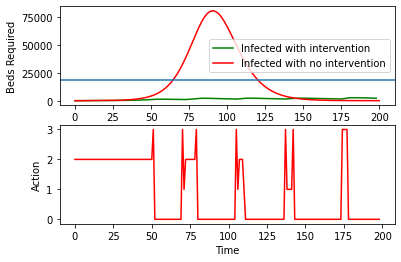

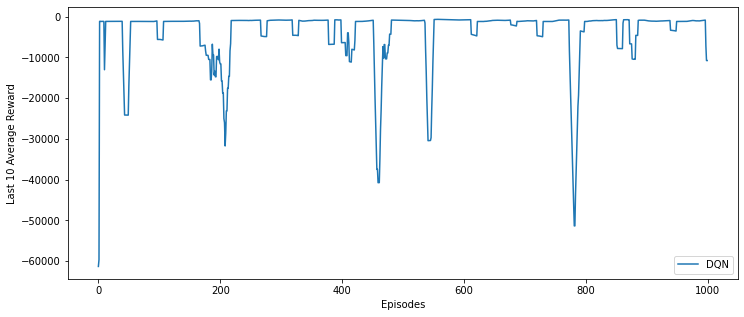

action dim== 4
plotting reward
DQN********************************************** 2
Reward =  796.0
Total infected : 0.0002806310336700521
Total cost 1990
200
3.68112997362241e-05
200
3.68112997362241e-05


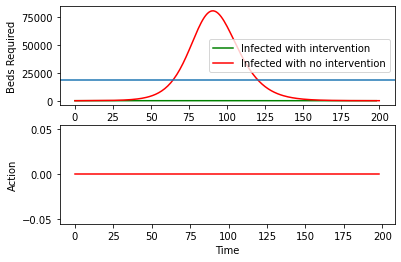

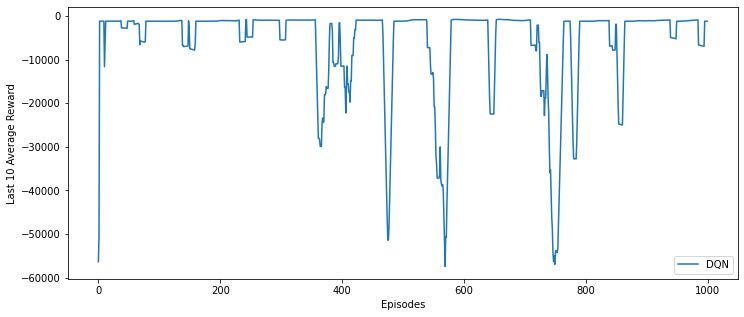

action dim== 4
plotting reward
DQN********************************************** 3
Reward =  796.0
Total infected : 0.0002806310336700521
Total cost 1990
200
3.68112997362241e-05
200
3.68112997362241e-05


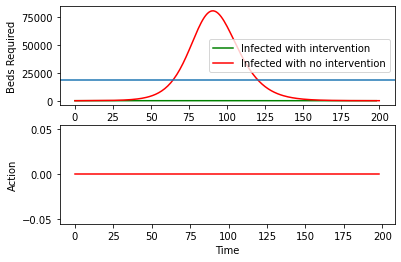

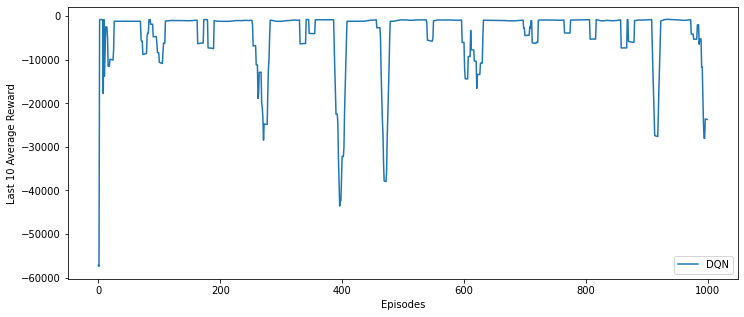

action dim== 4
plotting reward
DQN********************************************** 4
Reward =  796.0
Total infected : 0.0002806310336700521
Total cost 1990
200
3.68112997362241e-05
200
3.68112997362241e-05


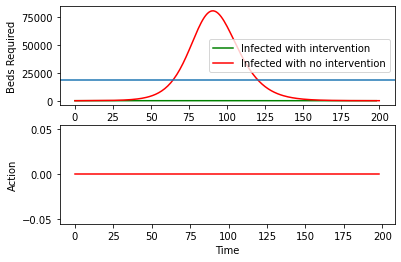

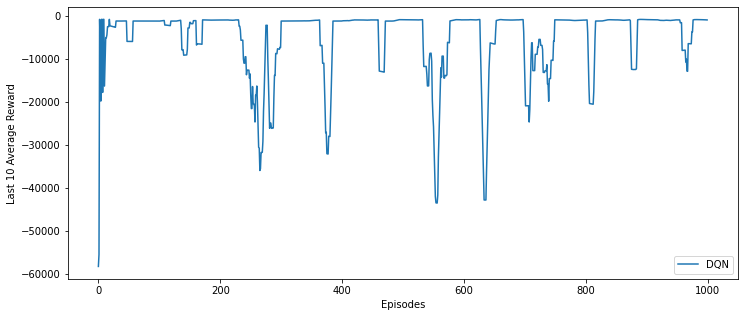

action dim== 4
plotting reward
DQN********************************************** 5
Reward =  1150.0
Total infected : 0.05851693823383732
Total cost 1636.0
200
0.0025074110936163813
200
0.0025074110936163813


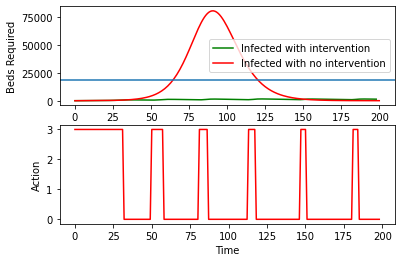

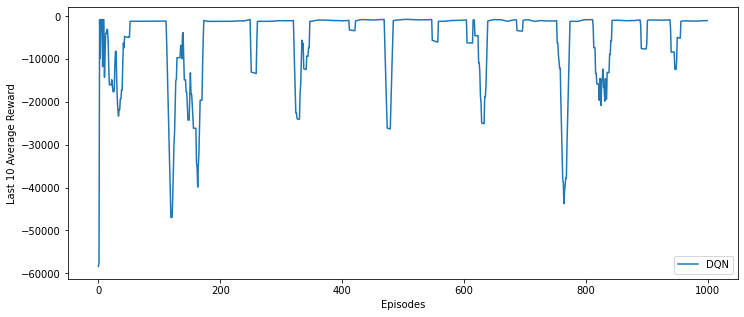

action dim== 4
plotting reward
DQN********************************************** 6
Reward =  1012.0
Total infected : 0.0021262321562801187
Total cost 1774.0
200
7.328409847748464e-05
200
7.328409847748464e-05


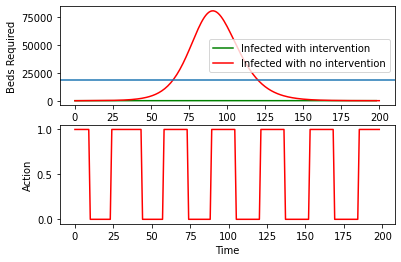

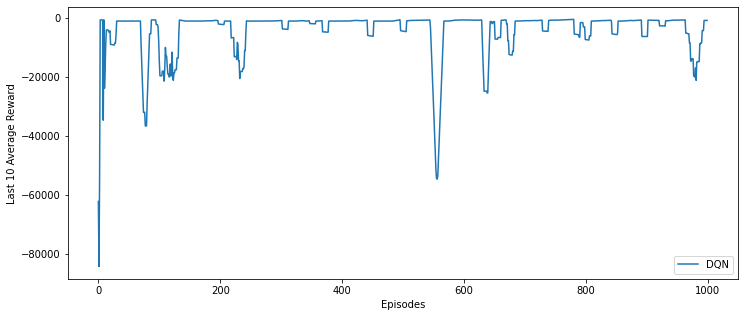

action dim== 4
plotting reward
DQN********************************************** 7
Reward =  1234.0
Total infected : 0.14561198826363106
Total cost 1552.0
200
0.007870509863582743
200
0.007870509863582743


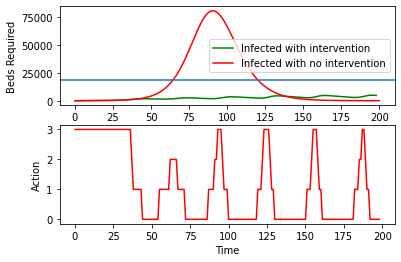

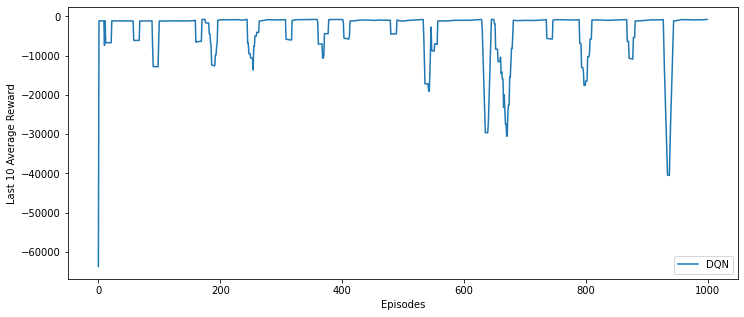

action dim== 4


KeyboardInterrupt: 

In [15]:
run_algos_plot_batch(30000,episodes=1000,number_of_times=20,name='economic_days_limit_changes_limit_capacity_1000')

## 5. Age group based

### 5.1 Single agent

action dim== 8
episode: 1, total reward: 1878.0
episode: 2, total reward: -8688.75
episode: 3, total reward: 405.5
episode: 4, total reward: 371.75
episode: 5, total reward: 380.0
episode: 6, total reward: 408.0
episode: 7, total reward: 402.0
episode: 8, total reward: 438.0
episode: 9, total reward: -8449.25
episode: 10, total reward: -8602.25
episode: 11, total reward: -8541.0
episode: 12, total reward: 399.25
episode: 13, total reward: 390.75
episode: 14, total reward: 384.0
episode: 15, total reward: 398.25
episode: 16, total reward: 382.5
episode: 17, total reward: 381.75
episode: 18, total reward: 380.75
episode: 19, total reward: 368.25
episode: 20, total reward: 387.75
episode: 21, total reward: 377.75
episode: 22, total reward: 373.5
episode: 23, total reward: 370.0
episode: 24, total reward: 392.25
episode: 25, total reward: 399.5
episode: 26, total reward: 382.5
episode: 27, total reward: 382.5
episode: 28, total reward: 396.5
episode: 29, total reward: 397.75
episode: 30, t

episode: 238, total reward: 2442.5
episode: 239, total reward: 409.75
episode: 240, total reward: -8830.25
episode: 241, total reward: 2651.25
episode: 242, total reward: 2617.0
episode: 243, total reward: 2850.0
episode: 244, total reward: 2265.75
episode: 245, total reward: -8641.5
episode: 246, total reward: 2496.25
episode: 247, total reward: 2654.5
episode: 248, total reward: 2531.75
episode: 249, total reward: 2655.25
episode: 250, total reward: 2332.75
episode: 251, total reward: 3151.25
episode: 252, total reward: 1167.5
episode: 253, total reward: 1152.75
episode: 254, total reward: 1188.5
episode: 255, total reward: -7913.0
episode: 256, total reward: 389.5
episode: 257, total reward: 381.75
episode: 258, total reward: 368.25
episode: 259, total reward: 371.25
episode: 260, total reward: 357.0
episode: 261, total reward: 370.0
episode: 262, total reward: 370.0
episode: 263, total reward: 371.75
episode: 264, total reward: 360.0
episode: 265, total reward: 371.75
episode: 266,

episode: 474, total reward: -8689.5
episode: 475, total reward: -8909.5
episode: 476, total reward: -8412.0
episode: 477, total reward: 405.75
episode: 478, total reward: 365.25
episode: 479, total reward: 362.5
episode: 480, total reward: 365.25
episode: 481, total reward: 371.25
episode: 482, total reward: 366.0
episode: 483, total reward: 386.0
episode: 484, total reward: 361.75
episode: 485, total reward: 355.25
episode: 486, total reward: 365.25
episode: 487, total reward: 360.75
episode: 488, total reward: 391.25
episode: 489, total reward: 385.25
episode: 490, total reward: 363.5
episode: 491, total reward: 381.75
episode: 492, total reward: 356.5
episode: 493, total reward: 361.25
episode: 494, total reward: 363.5
episode: 495, total reward: 373.5
episode: 496, total reward: 356.5
episode: 497, total reward: 350.0
episode: 498, total reward: 377.75
episode: 499, total reward: 370.0
episode: 500, total reward: 358.25
episode: 501, total reward: 364.0
episode: 502, total reward: 

episode: 709, total reward: 353.0
episode: 710, total reward: 364.75
episode: 711, total reward: 358.25
episode: 712, total reward: 364.75
episode: 713, total reward: 370.0
episode: 714, total reward: -8803.25
episode: 715, total reward: 2335.25
episode: 716, total reward: -8504.5
episode: 717, total reward: 2279.75
episode: 718, total reward: 2625.5
episode: 719, total reward: 2634.5
episode: 720, total reward: 2478.25
episode: 721, total reward: 2557.25
episode: 722, total reward: 3472.75
episode: 723, total reward: 1004.0
episode: 724, total reward: -6247.0
episode: 725, total reward: 430.25
episode: 726, total reward: 350.0
episode: 727, total reward: 367.0
episode: 728, total reward: 376.0
episode: 729, total reward: 2994.0
episode: 730, total reward: 2425.5
episode: 731, total reward: 3292.75
episode: 732, total reward: -8619.0
episode: 733, total reward: -8354.0
episode: 734, total reward: -7139.75
episode: 735, total reward: 2899.25
episode: 736, total reward: 2516.25
episode: 

episode: 943, total reward: 359.5
episode: 944, total reward: 358.75
episode: 945, total reward: 373.5
episode: 946, total reward: 363.0
episode: 947, total reward: 357.0
episode: 948, total reward: 376.0
episode: 949, total reward: 364.75
episode: 950, total reward: 370.5
episode: 951, total reward: 362.25
episode: 952, total reward: 363.5
episode: 953, total reward: 363.0
episode: 954, total reward: 379.5
episode: 955, total reward: 356.5
episode: 956, total reward: 361.75
episode: 957, total reward: 364.75
episode: 958, total reward: 354.75
episode: 959, total reward: 491.25
episode: 960, total reward: 2446.25
episode: 961, total reward: -8708.25
episode: 962, total reward: 2373.75
episode: 963, total reward: 2646.5
episode: 964, total reward: 2663.5
episode: 965, total reward: 1068.25
episode: 966, total reward: -8506.0
episode: 967, total reward: -8556.75
episode: 968, total reward: 398.75
episode: 969, total reward: 354.75
episode: 970, total reward: 370.0
episode: 971, total rew

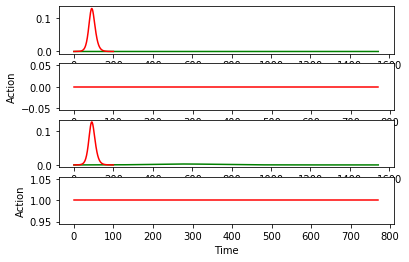

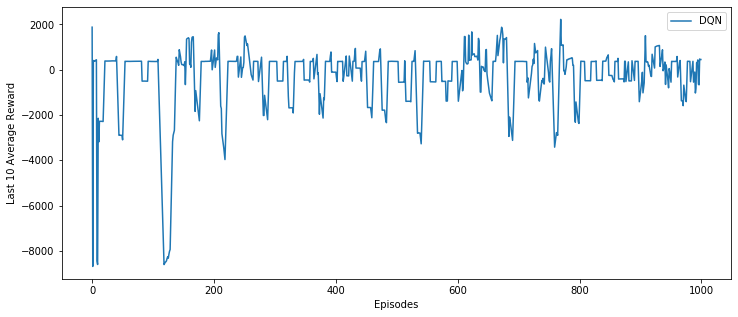

In [6]:
#DQN reward at the end -10000
run_algos_plot(30000)



### 5.2 Multi agent

In [ ]:
DQN,PPO